In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 10 14:42:55 2025

@author: Sercan
"""

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import distance
import numpy as np
import os
import glob
 
# Paths
folder = "."
savefolder = "."
parquet_dir = os.path.join(savefolder, "XY_parquet_parts")

files = sorted(glob.glob(os.path.join(parquet_dir, "*.parquet")))
# dfXY = pd.concat([pd.read_parquet(f) for f in files], ignore_index=True)
import pyarrow.parquet as pq

good_files = []
bad_files = []

for f in files:
    try:
        # This opens the footer and will fail fast if not real Parquet
        pq.ParquetFile(f)  
        good_files.append(f)
    except Exception as e:
        bad_files.append((f, str(e)))

if bad_files:
    print("Skipping invalid/corrupted files:")
    for f, e in bad_files:
        print(" -", f, "->", e)

if not good_files:
    raise RuntimeError("No valid Parquet files found in {}".format(parquet_dir))

# If schemas might differ, let pandas unify them; otherwise you can use pyarrow.dataset too.
dfXY = pd.concat([pd.read_parquet(f) for f in good_files], ignore_index=True)




In [2]:
# def _sorted_unique(series):
#     vals = series.dropna().unique().tolist()
#     try:
#         # Try numeric sort first
#         return sorted(vals, key=float)
#     except Exception:
#         # Fall back to default sort for non-numeric types
#         return sorted(vals)

# orders = _sorted_unique(dfXY['order'])
# densities = _sorted_unique(dfXY['density'])

# print("Sorted orders:", orders)
# print("Sorted densities:", densities)

# # --- Make a grid of subplots: rows=order, cols=density ---
# n_rows = len(orders)
# n_cols = len(densities)

# plt.rcParams.update({
#     'font.size': 8,
#     'ytick.major.width': 2,
#     'xtick.major.width': 2,
#     'axes.linewidth': 2,
#     'font.family': 'Arial'
# })

# fig, axes = plt.subplots(
#     n_rows, n_cols,
#     figsize=(n_cols * 1.4, n_rows * 1.4),
#     dpi=300,
#     squeeze=False
# )

# # Custom colormap (same as before)
# start_color = '#30013b'  # Dark Purple
# end_color = '#f2cf26'    # Yellow
# cmap = plt.cm.tab20#LinearSegmentedColormap.from_list('custom_cmap', [start_color, end_color])

# for r, o in enumerate(orders):
#     for c, d in enumerate(densities):
#         ax = axes[r, c]
#         df_sub = dfXY.loc[(dfXY['order'] == o) & (dfXY['density'] == d)]

#         if df_sub.empty:
#             # No data for this combo—keep frame for consistency
#             ax.set_title(f"d={d} | o={o}", fontsize=8)
#             ax.set_xlim(-8, 8)
#             ax.set_ylim(-8, 8)
#             ax.set_xticks([-8, 0, 8])
#             ax.set_yticks([-8, 0, 8])
#             ax.set_aspect('equal')
#             ax.text(0.5, 0.5, "no data", ha='center', va='center', transform=ax.transAxes, alpha=0.6)
#             continue

#         grouped = df_sub.groupby('fname', sort=False)

#         # Plot each trajectory
#         total = len(grouped)
#         # Avoid division by zero; total can't be 0 here but guard anyway
#         denom = max(total, 1)
#         for i, (_, grp) in enumerate(grouped):
#             xx = grp["X"].values
#             yy = grp["Y"].values
#             ax.plot(xx, yy, color=cmap(i / denom), linewidth=0.8)

#         # Axes formatting
#         ax.set_xlim(-8, 8)
#         ax.set_ylim(-8, 8)
#         ax.set_xticks([-8, 0, 8])
#         ax.set_yticks([-8, 0, 8])
#         ax.set_aspect('equal')
#         ax.set_title(f"d={d} | o={o}", fontsize=8)

# # Optional: nicer outer labels
# fig.suptitle("Trajectories by Order (rows) × Density (cols)", fontsize=9, y=1.02)
# fig.tight_layout()

# # Show and/or save
# plt.show()


In [3]:
np.sort(dfXY["density"].unique()), np.sort(dfXY["order"].unique())

(array([ 1,  4,  8, 16, 32, 64]), array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]))

In [4]:
dfXY["fname"].unique().shape

(470,)

In [5]:
dfXY["loss"].min(), dfXY["loss"].max()

(np.float64(0.0008416736806140523), np.float64(0.9999749997916649))

In [6]:
dfXY

X         Y          fname      loss  order  density  groups
0        -0.000020 -0.000168  20220829_1234  0.011458    0.4       16  0.4_16
1        -0.000041 -0.000345  20220829_1234  0.011458    0.4       16  0.4_16
2        -0.000062 -0.000527  20220829_1234  0.011458    0.4       16  0.4_16
3        -0.000084 -0.000719  20220829_1234  0.011458    0.4       16  0.4_16
4        -0.000106 -0.000912  20220829_1234  0.011458    0.4       16  0.4_16
...            ...       ...            ...       ...    ...      ...     ...
53226539  3.789826 -0.082112  20221104_1401  0.016808    1.0        4  1.0_04
53226540  3.789826 -0.082110  20221104_1401  0.016808    1.0        4  1.0_04
53226541  3.789826 -0.082114  20221104_1401  0.016808    1.0        4  1.0_04
53226542  3.789826 -0.082117  20221104_1401  0.016808    1.0        4  1.0_04
53226543  3.789826 -0.082125  20221104_1401  0.016808    1.0        4  1.0_04

[53226544 rows x 7 columns]

In [7]:
# ---- Rediscretize dfXY by fname (keeps order & density) ----
import numpy as np
import pandas as pd

# Optional: use numba if available
try:
    from numba import njit
except Exception:
    def njit(*args, **kwargs):
        def wrap(f): return f
        return wrap

BODY_LENGTH = 0.04
TOLERANCE = 1e-4   # max spacing for interpolation step
STEP_LENGTH = BODY_LENGTH * 6

@njit
def densely_interpolate(x, y, tolerance=TOLERANCE):
    n = len(x)
    counts = np.zeros(n-1, dtype=np.int64)

    total_points = 0
    for i in range(n - 1):
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        segment_length = np.sqrt(dx*dx + dy*dy)
        num_points = max(int(segment_length / tolerance), 2)
        counts[i] = num_points
        if i == 0:
            total_points += num_points
        else:
            total_points += (num_points - 1)

    new_x = np.empty(total_points, dtype=np.float64)
    new_y = np.empty(total_points, dtype=np.float64)

    idx = 0
    for i in range(n - 1):
        num_points = counts[i]
        seg_x = np.linspace(x[i], x[i+1], num_points)
        seg_y = np.linspace(y[i], y[i+1], num_points)
        if i == 0:
            for j in range(num_points):
                new_x[idx] = seg_x[j]
                new_y[idx] = seg_y[j]
                idx += 1
        else:
            for j in range(1, num_points):  # skip duplicate
                new_x[idx] = seg_x[j]
                new_y[idx] = seg_y[j]
                idx += 1

    return new_x, new_y

@njit
def find_next_point(x, y, start_x, start_y, step_length):
    distances = np.sqrt((x - start_x)**2 + (y - start_y)**2)
    diff = np.abs(distances - step_length)
    index = np.argmin(diff)
    return x[index], y[index], index

def rediscretize_trajectory(x, y, step_length, tolerance=TOLERANCE):
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    if x.size < 2:
        return np.array([x[0]]) if x.size == 1 else np.array([]), np.array([y[0]]) if y.size == 1 else np.array([])

    dense_x, dense_y = densely_interpolate(x, y, tolerance)
    if dense_x.size == 0:
        return np.array([]), np.array([])

    new_x = [x[0]]
    new_y = [y[0]]

    while True:
        if len(dense_x) == 0:
            break
        next_x, next_y, index = find_next_point(dense_x, dense_y, new_x[-1], new_y[-1], step_length)

        last_dx = new_x[-1] - next_x
        last_dy = new_y[-1] - next_y
        last_distance = np.sqrt(last_dx*last_dx + last_dy*last_dy)
        if last_distance < step_length - TOLERANCE:
            break

        new_x.append(next_x)
        new_y.append(next_y)

        dense_x = dense_x[index:]
        dense_y = dense_y[index:]

        if index == 0:  # no progress safeguard
            break

    return np.array(new_x), np.array(new_y)

def process_individual_group(grp, fname, step_length=STEP_LENGTH):
    """
    grp: DataFrame for a single fname from dfXY with columns X,Y,order,density
    """
    x = grp["X"].to_numpy(dtype=np.float64, copy=False)
    y = grp["Y"].to_numpy(dtype=np.float64, copy=False)

    xr, yr = rediscretize_trajectory(x, y, step_length)
    if xr.size < 2:
        return None

    dx = np.diff(xr)
    dy = np.diff(yr)
    direction = np.arctan2(dy, dx)

    o = grp["order"].iloc[0] if "order" in grp.columns else None
    d = grp["density"].iloc[0] if "density" in grp.columns else None

    out = pd.DataFrame({
        "fname": fname,
        "order": o,
        "density": d,
        "X": xr[1:],              # location at the end of each step
        "Y": yr[1:],
        "dX": dx,                 # step vectors
        "dY": dy,
        "direction": direction    # radians
    })
    return out

# ---- Distance-only filter ----
def _total_distance_m(g_after_dropna):
    dx = g_after_dropna["X"].diff()
    dy = g_after_dropna["Y"].diff()
    return float(np.hypot(dx, dy).fillna(0.0).sum())

results = []
for fname, grp_raw in dfXY.groupby("fname", sort=False):
    # Drop NA rows in X/Y for movement + rediscretization
    grp = grp_raw.dropna(subset=["X", "Y"])
    if len(grp) < 2:
        continue

    # Movement in meters
    dist_m = _total_distance_m(grp)

    # # ---- FILTER: keep only if moved ≥ MIN_DISTANCE_M and completed at least 80% of trial----
    # if dist_m < 1.0 or grp_raw["loss"].max() > 0.2:
    #     continue

    # proceed to rediscretization
    res = process_individual_group(grp, fname, step_length=STEP_LENGTH)
    if res is not None and not res.empty:
        results.append(res)

if not results:
    raise RuntimeError("No groups produced rediscretized output after filtering (check dfXY content).")

merged_df = pd.concat(results, ignore_index=True)

# Optional: numeric animal_id per (order, density, fname)
merged_df["unique_id"] = (
    merged_df["order"].astype(str) + "|" +
    merged_df["density"].astype(str) + "|" +
    merged_df["fname"].astype(str)
)
id_map = {u: i for i, u in enumerate(merged_df["unique_id"].unique())}
merged_df["animal_id"] = merged_df["unique_id"].map(id_map).astype(int)
merged_df = merged_df.drop(columns=["unique_id"])


In [8]:
merged_df

fname  order  density         X         Y        dX        dY  \
0      20220829_1234    0.4       16  0.146888 -0.189951  0.146908 -0.189784   
1      20220829_1234    0.4       16 -0.086330 -0.133167 -0.233218  0.056785   
2      20220829_1234    0.4       16 -0.310468 -0.219125 -0.224138 -0.085959   
3      20220829_1234    0.4       16 -0.434566 -0.424557 -0.124098 -0.205432   
4      20220829_1234    0.4       16 -0.623218 -0.276234 -0.188653  0.148323   
...              ...    ...      ...       ...       ...       ...       ...   
18636  20221104_1401    1.0        4  2.843251 -0.021066  0.239904 -0.005247   
18637  20221104_1401    1.0        4  3.059277  0.083800  0.216027  0.104867   
18638  20221104_1401    1.0        4  3.295434  0.041053  0.236157 -0.042747   
18639  20221104_1401    1.0        4  3.535442  0.037230  0.240008 -0.003824   
18640  20221104_1401    1.0        4  3.763924 -0.036248  0.228482 -0.073478   

       direction  animal_id  
0      -0.912061          0  
1       2.902756          0  
2      -2.775384          0  
3      -2.114212          0  
4       2.475310          0  
...          ...        ...  
18636  -0.021868        439  
18637   0.451928        439  
18638  -0.179073        439  
18639  -0.015930        439  
18640  -0.311146        439  

[18641 rows x 9 columns]

In [9]:
merged_df["animal_id"].nunique()

440

In [10]:
# # ---------- OUTLIER REMOVAL AFTER REDISCRETIZATION ----------

# import numpy as np
# import pandas as pd

# # 1) Build per-trial features from merged_df
# #    - mean sin/cos of heading (circular mean embedding)
# feat_df = merged_df.copy()

# feat_df["step_len"] = np.hypot(feat_df["dX"], feat_df["dY"])
# feat_df["sin"] = np.sin(feat_df["direction"])
# feat_df["cos"] = np.cos(feat_df["direction"])

# trial_features = (
#     feat_df
#     .groupby(["order", "density", "fname"], sort=False)
#     .agg(
#         sin=("sin", "mean"),
#         cos=("cos", "mean"),
#         dY=("dY", "mean"),
#         dX=("dX", "mean"),
#         distTotal=("step_len", "sum"),
#         n_steps=("direction", "size"),
#     )
#     .reset_index()
# )

# # 2) Mahalanobis-based outlier detection per (order, density) group
# def mahalanobis_flags(df, cols=("dY", "dX"), threshold=2.5):
#     """
#     Returns a boolean mask of outliers and the distances.
#     Robust to singular covariance via pseudo-inverse.
#     """
#     X = df.loc[:, cols].to_numpy(dtype=float)
#     mu = X.mean(axis=0)
#     # covariance; rowvar=False for features in columns
#     cov = np.cov(X, rowvar=False)
#     # numerical safety: handle 1x1 or singular covariance
#     if X.shape[0] < 3 or not np.all(np.isfinite(cov)) or np.linalg.matrix_rank(cov) < len(cols):
#         inv_cov = np.linalg.pinv(cov)
#     else:
#         inv_cov = np.linalg.inv(cov)
#     diffs = X - mu
#     # Mahalanobis distance: sqrt( (x-mu)^T Sigma^{-1} (x-mu) )
#     d2 = np.einsum("ij,jk,ik->i", diffs, inv_cov, diffs)  # squared distances
#     d = np.sqrt(np.maximum(d2, 0.0))
#     outliers = d > float(threshold)
#     return outliers, d

# trial_features["mahalanobis_distance"] = np.nan
# trial_features["outlier"] = False

# for (o, d), grp in trial_features.groupby(["order", "density"], sort=False):
#     if len(grp) < 5:
#         # too few trials to estimate a stable covariance; skip outliering
#         trial_features.loc[grp.index, "outlier"] = False
#         trial_features.loc[grp.index, "mahalanobis_distance"] = 0.0
#         continue
#     flags, dists = mahalanobis_flags(grp, cols=("dY", "dX"), threshold=2.5)
#     trial_features.loc[grp.index, "outlier"] = flags
#     trial_features.loc[grp.index, "mahalanobis_distance"] = dists

# # 3) Keep only inlier trials in the rediscretized dataframe
# inlier_fnames = set(trial_features.loc[~trial_features["outlier"], "fname"])
# filtered_merged_df = merged_df[merged_df["fname"].isin(inlier_fnames)].copy()

# # 4) Rebuild the numeric animal_id after filtering (optional; mirrors your code)
# filtered_merged_df["unique_id"] = (
#     filtered_merged_df["order"].astype(str) + "|" +
#     filtered_merged_df["density"].astype(str) + "|" +
#     filtered_merged_df["fname"].astype(str)
# )
# id_map = {u: i for i, u in enumerate(filtered_merged_df["unique_id"].unique())}
# filtered_merged_df["animal_id"] = filtered_merged_df["unique_id"].map(id_map).astype(int)
# filtered_merged_df.drop(columns=["unique_id"], inplace=True)

# print("Before outlier removal:", merged_df["fname"].nunique(), "trials")
# print("After outlier removal:", filtered_merged_df["fname"].nunique(), "trials")
# print(filtered_merged_df.head())
# # -------------------------------------------------------------------------------

In [11]:
# merged_df = filtered_merged_df.copy()

Sorted orders: [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
Sorted densities: [1, 4, 8, 16, 32, 64]


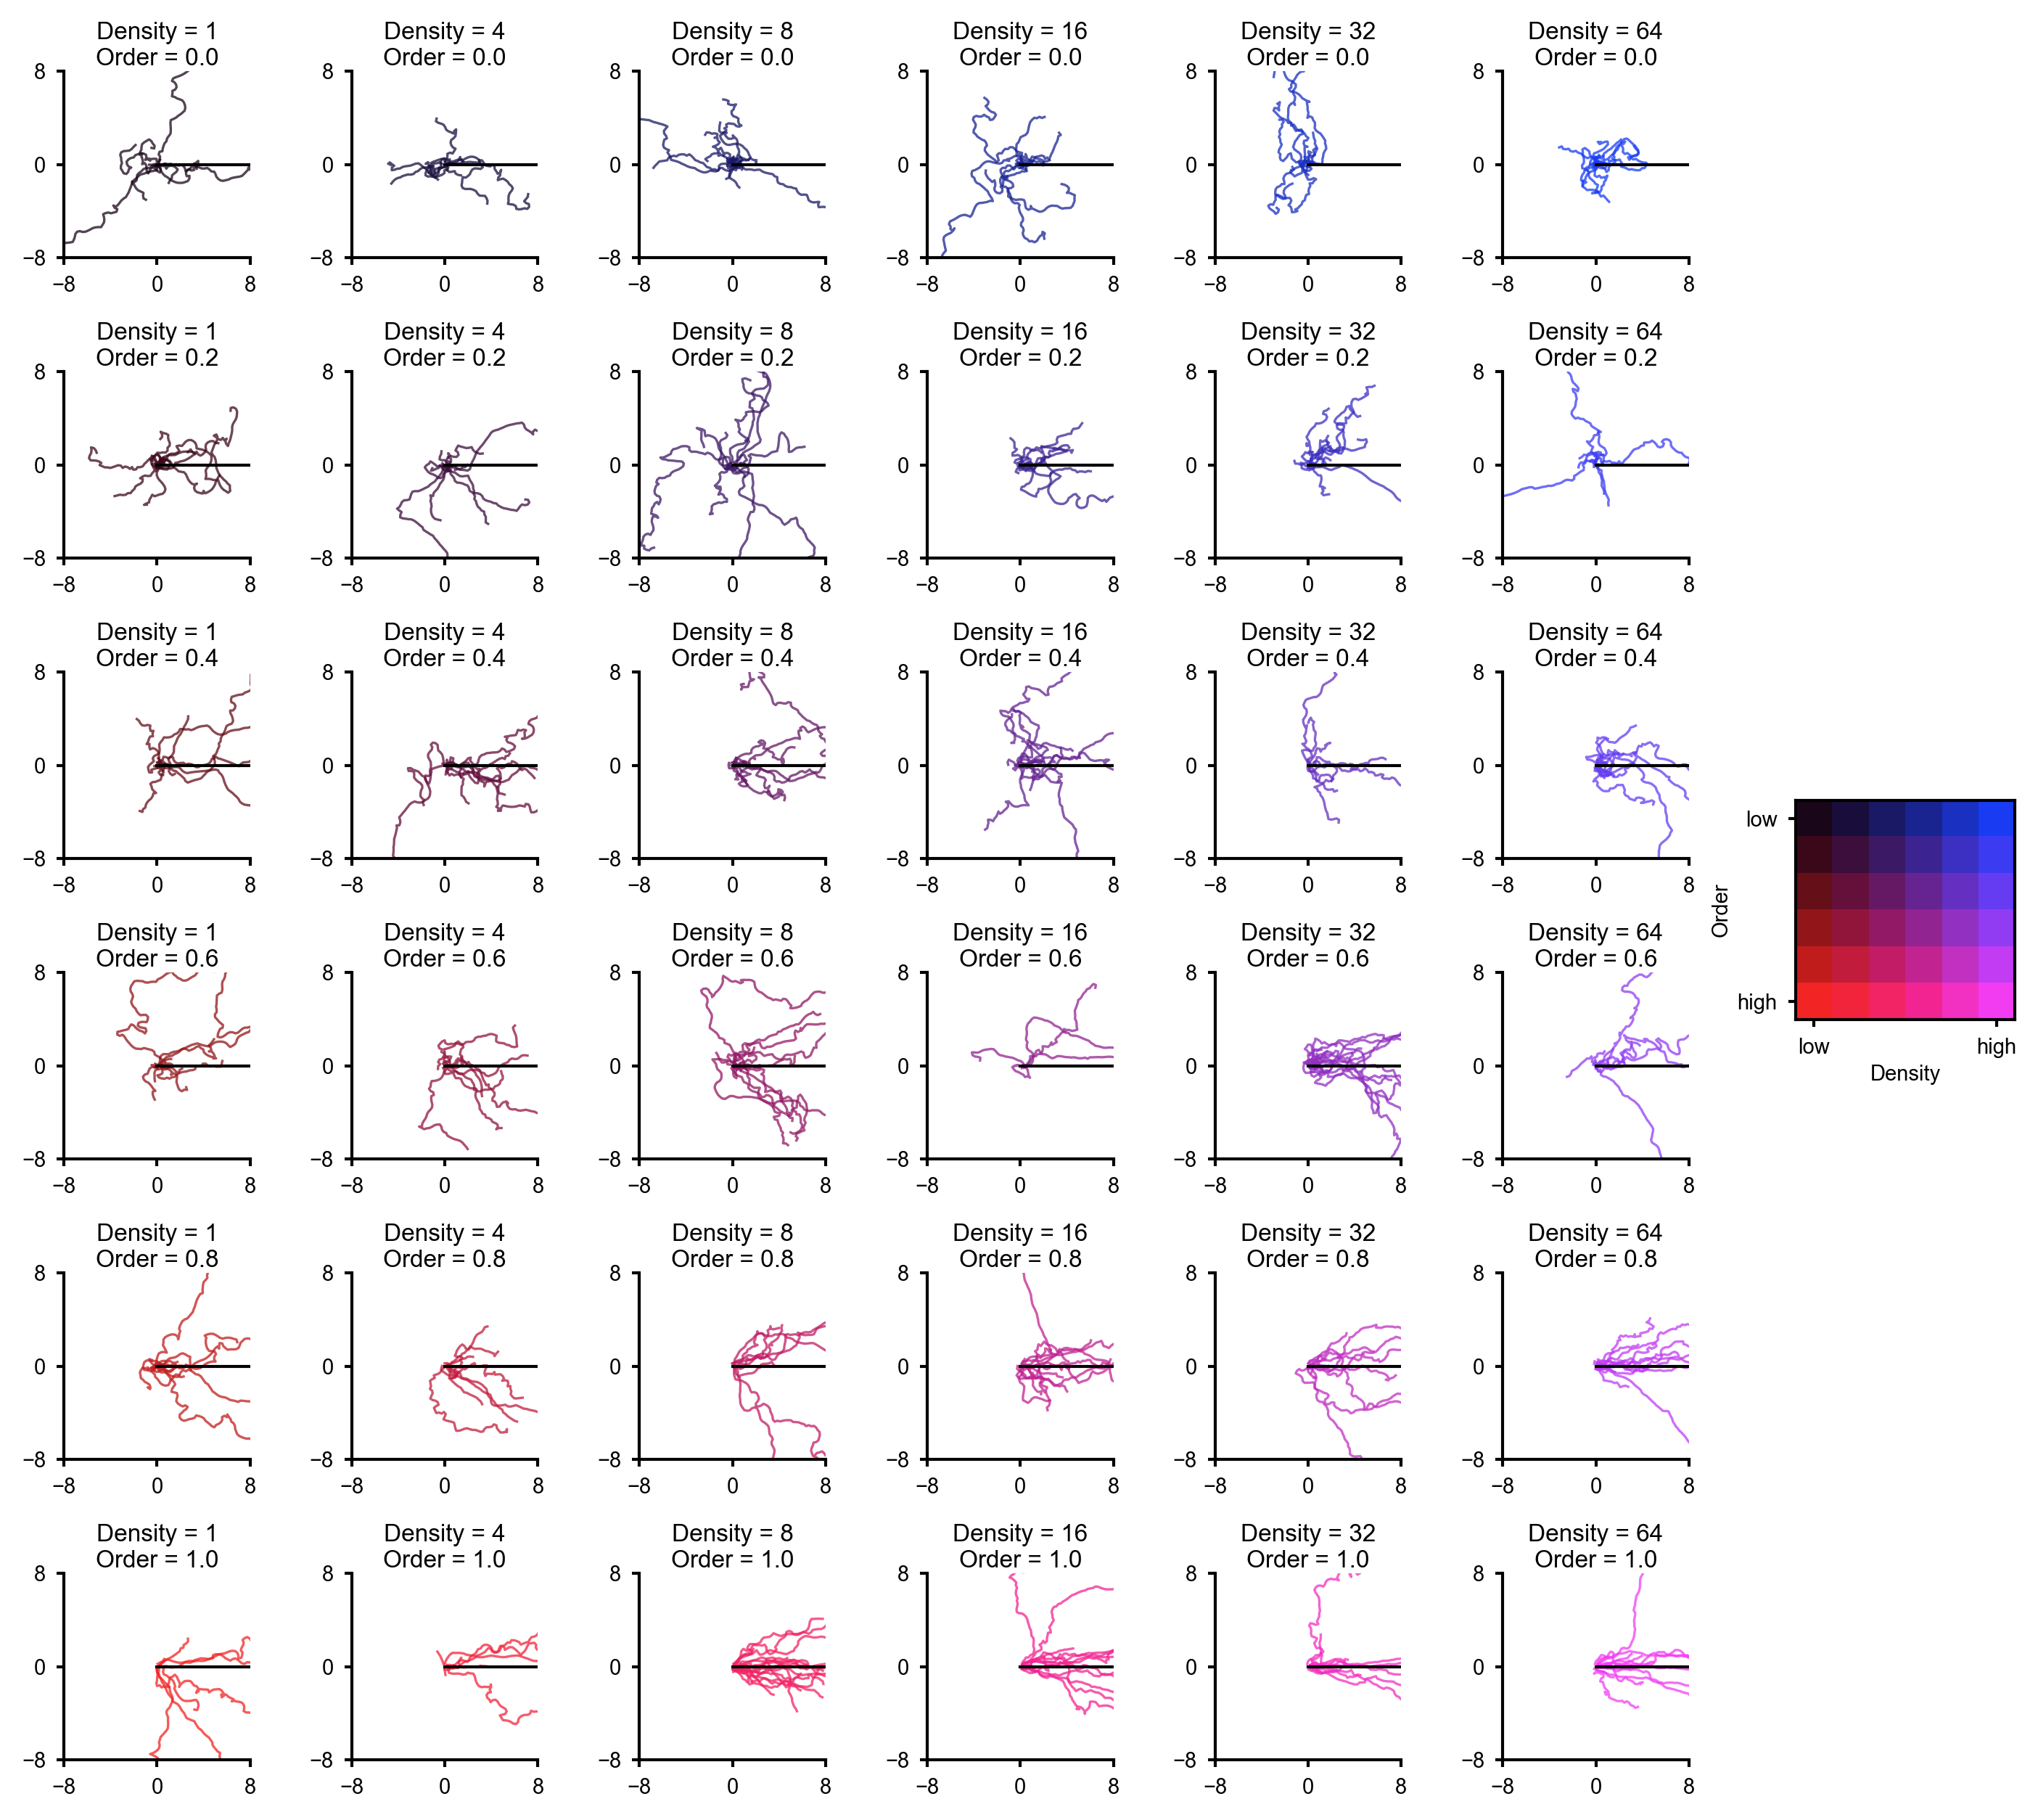

In [176]:
import numpy as np
import matplotlib.pyplot as plt

def _sorted_unique(series):
    vals = series.dropna().unique().tolist()
    try:
        return sorted(vals, key=float)
    except Exception:
        return sorted(vals)

# subplot ordering (top->bottom, left->right)
orders    = _sorted_unique(merged_df["order"])     # low at top, high at bottom (if ascending)
densities = _sorted_unique(merged_df["density"])   # low at left, high at right

print("Sorted orders:", orders)
print("Sorted densities:", densities)

n_rows = len(orders)
n_cols = len(densities)

plt.rcParams.update({
    "font.size": 8,
    "ytick.major.width": 1,
    "xtick.major.width": 1,
    "axes.linewidth": 1,
    "font.family": "Arial",
})

# -------------------------------------------------
# NEW 2D colormap: black->blue (density) + black->red (order) => deep purple
# -------------------------------------------------
def _lerp(a, b, t):
    return (1.0 - t) * np.asarray(a, float) + t * np.asarray(b, float)

def cell_color(order_idx, density_idx, n_rows, n_cols,
               tmin=0.10, tmax=0.95,
               blue=(0.10, 0.25, 1.00),
               red =(1.00, 0.15, 0.15),
               gamma=1.15,
               mix="max"):
    # row 0 = top (low order), bottom = high order
    to = (order_idx   / max(n_rows - 1, 1))
    td = (density_idx / max(n_cols - 1, 1))

    to = np.power(to, gamma)
    td = np.power(td, gamma)

    to = tmin + (tmax - tmin) * to
    td = tmin + (tmax - tmin) * td

    black = np.array([0.0, 0.0, 0.0], float)
    c_order = _lerp(black, red,  to)   # black -> red
    c_dens  = _lerp(black, blue, td)   # black -> blue

    if mix == "add":
        c = c_order + c_dens
    else:  # deep purple field (recommended)
        c = np.maximum(c_order, c_dens)

    return tuple(np.clip(c, 0, 1))

# -----------------------------
# Plot grid
# -----------------------------
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 1.4 + 1.0, n_rows * 1.4),
    dpi=300,
    squeeze=False
)

# axis limits and 0° (stimulus) line
XLIM = (-8, 8)
YLIM = (-8, 8)

for r, o in enumerate(orders):
    for c, d in enumerate(densities):
        ax = axes[r, c]
        df_sub = merged_df.loc[(merged_df["order"] == o) & (merged_df["density"] == d)]
        col = cell_color(r, c, n_rows, n_cols)

        ax.set_xlim(*XLIM)
        ax.set_ylim(*YLIM)
        ax.set_xticks([-8, 0, 8])
        ax.set_yticks([-8, 0, 8])
        ax.set_aspect("equal")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.set_title(f"Density = {d}\nOrder = {o}", fontsize=8, pad=2)

        if df_sub.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center",
                    transform=ax.transAxes, alpha=0.6)
            # still draw 0° line on top
            ax.plot([0, XLIM[1]], [0, 0], color="black", linewidth=1.0, zorder=10)
            continue

        # trajectories (behind)
        for _, grp in df_sub.groupby("fname", sort=False):
            ax.plot(grp["X"].values, grp["Y"].values,
                    color=col, linewidth=0.8, alpha=0.75, zorder=2)

        # 0° line (stimulus direction) ALWAYS ON TOP: from center to right edge
        ax.plot([0, XLIM[1]], [0, 0], color="black", linewidth=1.0, zorder=10)

# Tight layout for the grid, reserving room on the right for the key
fig.tight_layout(rect=[0.0, 0.0, 0.86, 1.0])

# -----------------------------
# 2D color key (matches panel colors)
# -----------------------------
key_size = 0.12
key_ax = fig.add_axes([0.88, 0.5 - key_size / 2, key_size, key_size])

grid = np.zeros((n_rows, n_cols, 3), float)
for rr in range(n_rows):
    for cc in range(n_cols):
        grid[rr, cc, :] = cell_color(rr, cc, n_rows, n_cols)

# origin="upper" => row 0 at TOP (low), bottom row high: matches subplot layout
key_ax.imshow(grid, origin="upper", aspect="equal")
key_ax.set_xlabel("Density", labelpad=2)
key_ax.set_ylabel("Order", labelpad=2)

key_ax.set_xticks([0, n_cols - 1] if n_cols > 1 else [0])
key_ax.set_yticks([0, n_rows - 1] if n_rows > 1 else [0])
key_ax.set_xticklabels(["low", "high"] if n_cols > 1 else [""])
key_ax.set_yticklabels(["low", "high"] if n_rows > 1 else [""])

for s in key_ax.spines.values():
    s.set_linewidth(1)

# save
fig.savefig("../figures/trajectories_order_by_density_grid.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0.01)

plt.show()


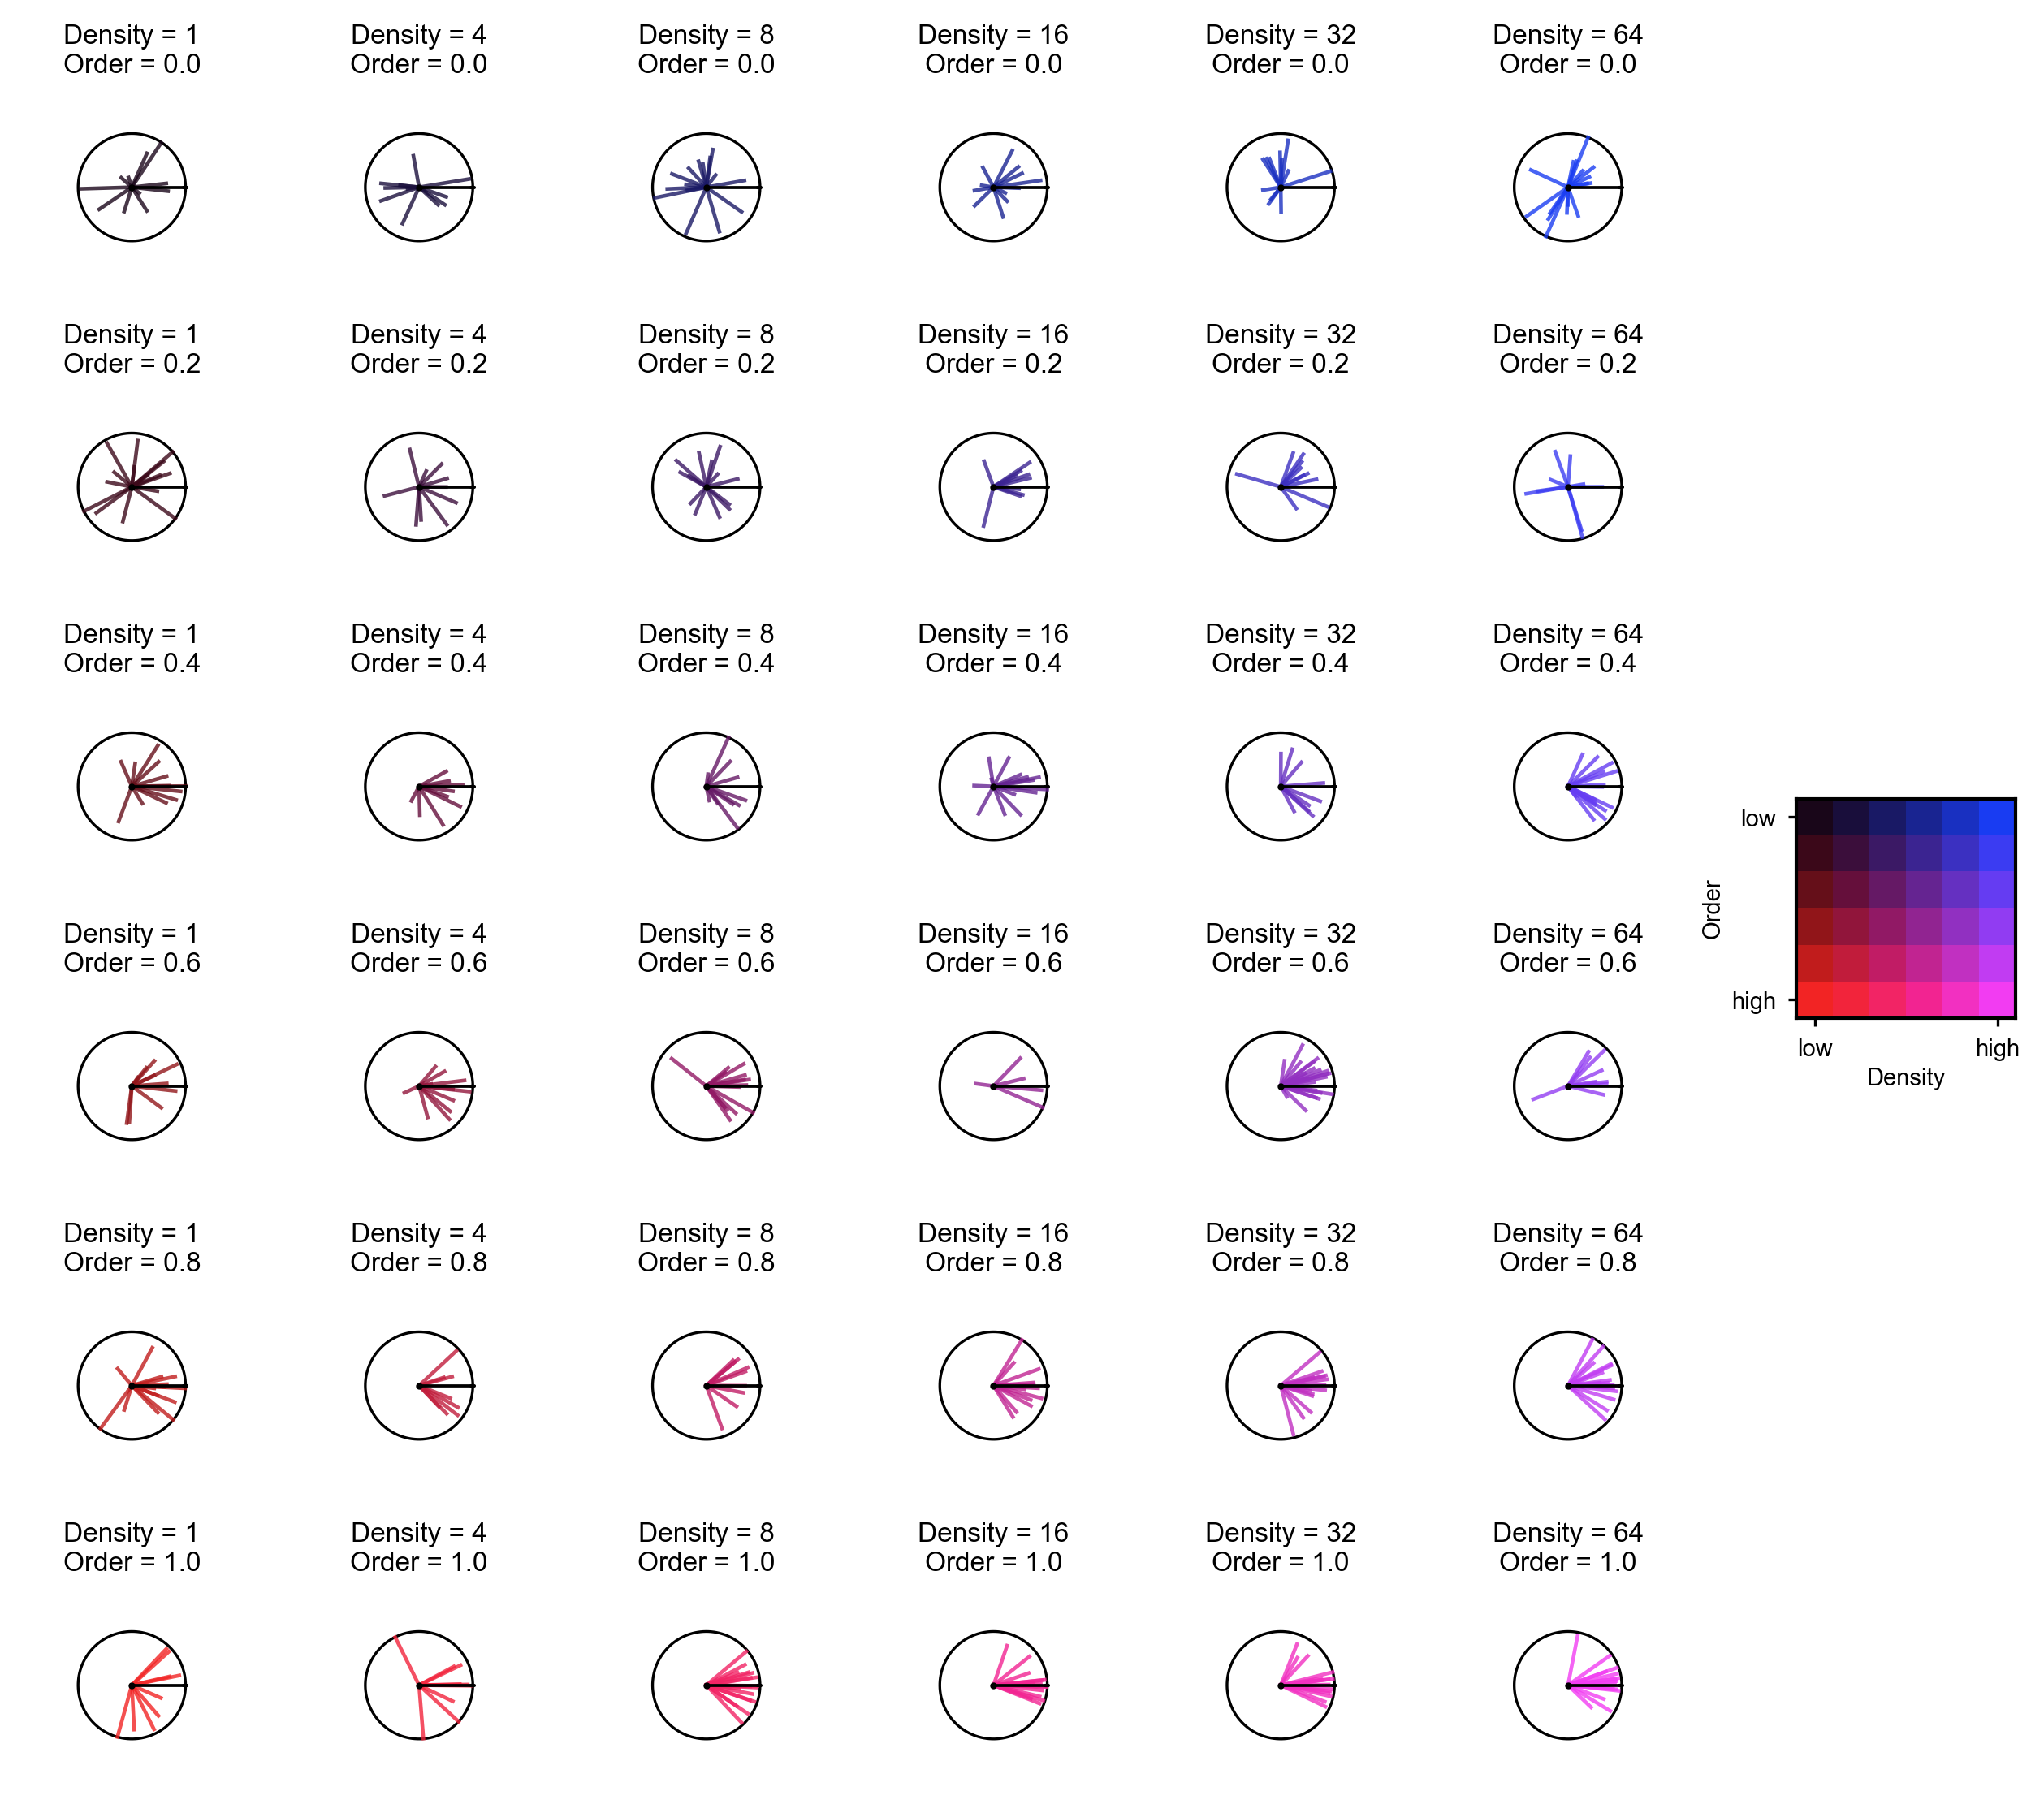

In [175]:
# --- Mean vectors per individual as lines (no axes; reference circle + 0° line; key matches panel colors) ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# In "step-length units": (dX, dY) / STEP_LENGTH
SCALE = 1 / STEP_LENGTH

def _sorted_unique(series):
    vals = series.dropna().unique().tolist()
    try:
        return sorted(vals, key=float)
    except Exception:
        return sorted(vals)

# -------------------------------------------------
# NEW 2D colormap: black->blue (density) + black->red (order) => deep purple
#   - density increases L->R  (blue channel contribution increases)
#   - order   increases T->B  (red channel contribution increases)
# -------------------------------------------------
def _lerp(a, b, t):
    return (1.0 - t) * np.asarray(a, float) + t * np.asarray(b, float)

def cell_color(order_idx, density_idx, n_rows, n_cols,
               tmin=0.10, tmax=0.95,
               blue=(0.10, 0.25, 1.00),
               red =(1.00, 0.15, 0.15),
               gamma=1.15,
               mix="max"):
    to = (order_idx   / max(n_rows - 1, 1))
    td = (density_idx / max(n_cols - 1, 1))

    to = np.power(to, gamma)
    td = np.power(td, gamma)

    to = tmin + (tmax - tmin) * to
    td = tmin + (tmax - tmin) * td

    black = np.array([0.0, 0.0, 0.0], float)
    c_order = _lerp(black, red,  to)   # black -> red
    c_dens  = _lerp(black, blue, td)   # black -> blue

    if mix == "add":
        c = c_order + c_dens
    else:  # deep purple field
        c = np.maximum(c_order, c_dens)

    return tuple(np.clip(c, 0, 1))

# 1) Compute mean vectors per (order, density, fname)
means_df = (
    merged_df
    .groupby(["order", "density", "fname"], as_index=False)[["dX", "dY"]]
    .mean()
)

if means_df.empty:
    raise RuntimeError("No mean vectors found. Check that merged_df has dX/dY and is not empty.")

# IMPORTANT: These define subplot ordering (top->bottom, left->right)
orders    = _sorted_unique(means_df["order"])     # ascending: low at top, high at bottom
densities = _sorted_unique(means_df["density"])   # ascending: low at left, high at right

n_rows = len(orders)
n_cols = len(densities)

# 2) Auto limits: symmetric around 0 using a 'nice' ceiling of global max |component|
max_abs_component = float(np.max(np.abs(means_df[["dX", "dY"]].to_numpy())))
pad = 1.10

def nice_ceil(v):
    if v <= 0:
        return 1.0
    v = v * pad
    exp = np.floor(np.log10(v))
    frac = v / (10 ** exp)
    for nice in (1.0, 2.0, 2.5, 5.0, 10.0):
        if frac <= nice:
            return nice * (10 ** exp)
    return 10.0 * (10 ** exp)

L = nice_ceil(max_abs_component * SCALE)
L = max(L, 1.15)  # ensure the radius-1 reference circle is always visible
XLIM = (-L, L)
YLIM = (-L, L)

# 3) Style
plt.rcParams.update({
    "font.size": 8,
    "axes.linewidth": 1,
    "font.family": "Arial",
})

# 4) Plot grid rows=order, cols=density
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(n_cols * 1.25 + 1.0, n_rows * 1.25),
    dpi=300,
    squeeze=False
)

# Reference circle at radius 1 (one step length) and 0° line (toward +x)
theta = np.linspace(0, 2*np.pi, 256)
circ_x = np.cos(theta)
circ_y = np.sin(theta)

for r, o in enumerate(orders):
    for c, d in enumerate(densities):
        ax = axes[r, c]
        panel = means_df[(means_df["order"] == o) & (means_df["density"] == d)]

        col = cell_color(r, c, n_rows, n_cols)

        ax.set_xlim(*XLIM)
        ax.set_ylim(*YLIM)
        ax.set_aspect("equal", "box")

        # remove axes/ticks/spines (keep title)
        ax.set_xticks([])
        ax.set_yticks([])
        for s in ax.spines.values():
            s.set_visible(False)

        # comment this out if you want a cleaner grid
        ax.set_title(f"Density = {d}\nOrder = {o}", fontsize=8, pad=2)

        # reference circle (behind vectors)
        ax.plot(circ_x, circ_y, color="black", linewidth=0.8, zorder=1)

        if panel.empty:
            ax.text(0.5, 0.5, "no data", ha="center", va="center",
                    transform=ax.transAxes, alpha=0.6)
            # still draw the stimulus direction line on top
            ax.plot([0, 1], [0, 0], color="black", linewidth=0.9, zorder=10)
            continue

        # mean vectors per individual (middle)
        for row in panel.itertuples(index=False):
            U = float(row.dX) * SCALE
            V = float(row.dY) * SCALE
            ax.plot([0.0, U], [0.0, V],
                    linewidth=1.1,
                    alpha=0.80,
                    color=col,
                    zorder=3)

        ax.plot(0, 0, ".", ms=2, color="k", zorder=4)

        # 0° direction line (stimulus direction) — ALWAYS ON TOP
        ax.plot([0, 1], [0, 0], color="black", linewidth=0.9, zorder=10)
        ax.plot([0.96, 1.02], [0.0, 0.0], color="black", lw=1.0, zorder=10, solid_capstyle="round")

# Tight layout for the grid, reserving room for the square 2D key on the right
fig.tight_layout(rect=[0.0, 0.0, 0.86, 1.0])

# ---- square 2D color key off to the side ----
key_size = 0.12
key_ax = fig.add_axes([0.88, 0.5 - key_size / 2, key_size, key_size])

grid = np.zeros((n_rows, n_cols, 3), float)
for rr in range(n_rows):
    for cc in range(n_cols):
        grid[rr, cc, :] = cell_color(rr, cc, n_rows, n_cols)

# origin="upper" puts row 0 at the TOP -> matches subplot top row
key_ax.imshow(grid, origin="upper", aspect="equal")

key_ax.set_xlabel("Density", labelpad=2)
key_ax.set_ylabel("Order", labelpad=2)

# minimalist ticks: just ends (low/high)
key_ax.set_xticks([0, n_cols - 1] if n_cols > 1 else [0])
key_ax.set_yticks([0, n_rows - 1] if n_rows > 1 else [0])
key_ax.set_xticklabels(["low", "high"] if n_cols > 1 else [""])
key_ax.set_yticklabels(["low", "high"] if n_rows > 1 else [""])

for s in key_ax.spines.values():
    s.set_linewidth(1)

# save
fig.savefig("../figures/mean_vectors_order_by_density_grid.pdf",
            dpi=300, bbox_inches="tight", pad_inches=0.01)

plt.show()


/home/jake/.local/lib/python3.10/site-packages/unwrap/bessel.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return i1(kappa) / i0(kappa) if kappa < np.inf else 1.0


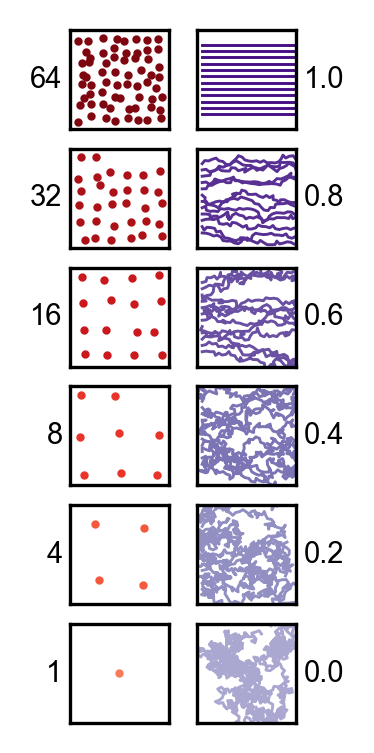

In [263]:
import numpy as np
import matplotlib.pyplot as plt
from unwrap.bessel import inverse_bessel_ratio
import matplotlib as mpl

with mpl.rc_context({
    "font.family": "Arial",
    "mathtext.fontset": "custom",
}):

    rng = np.random.default_rng(123)
    
    # -------------------------------------------------
    # Parameters (NOW: largest at the top)
    # -------------------------------------------------
    orders    = np.array([1.0, 0.8, 0.6, 0.4, 0.2, 0.0])
    densities = np.array([64, 32, 16, 8, 4, 1])
    
    n_rows = len(orders)
    n_cols = 2
    
    n_traj  = 12
    n_steps = 100
    step_L  = 0.04
    
    
    def kappa_from_order(order: float, eps: float = 1e-6) -> float:
        """
        Map 'order' (treated as mean resultant length R) -> kappa.
        eps prevents order==1.0 from hitting the invalid boundary R=1.
        """
        R = float(np.clip(order, 0.0, 1.0 - eps))
        return inverse_bessel_ratio(R)
    
    # -------------------------------------------------
    # Colors (MATCH PPC)
    #   density -> Reds, order -> Purples
    # -------------------------------------------------
    CMAP_MIN, CMAP_MAX = 0.45, 0.95
    cmap_density = plt.cm.Reds
    cmap_order   = plt.cm.Purples
    
    dens_levels  = np.sort(np.unique(densities))
    order_levels = np.sort(np.unique(orders))
    
    dens_pos  = np.linspace(CMAP_MIN, CMAP_MAX, len(dens_levels))
    order_pos = np.linspace(CMAP_MIN, CMAP_MAX, len(order_levels))
    
    dens_color_map  = {d: cmap_density(dens_pos[i]) for i, d in enumerate(dens_levels)}
    order_color_map = {o: cmap_order(order_pos[i])  for i, o in enumerate(order_levels)}
    
    # -------------------------------------------------
    # Figure
    # -------------------------------------------------
    plt.rcParams.update({
        "font.size": 7,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "font.family": "Arial",
    })
    
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(1.0, 3.0),
        dpi=300,
        squeeze=False,
    )
    
    XLIM = (0.0, 1.0)
    YLIM = (0.0, 1.0)
    
    # -------------------------------------------------
    # Row-by-row plotting
    # Column order: left = Density, right = Order
    # -------------------------------------------------
    for row, (order, dens) in enumerate(zip(orders, densities)):
    
        # ---------- LEFT: density dots (Reds) ----------
        ax_dens = axes[row, 0]
        n = int(dens)
        dot_col = dens_color_map[dens]
    
        if n == 1:
            xs = np.array([0.5]); ys = np.array([0.5])
        elif n == 4:
            xs, ys = np.meshgrid([0.25, 0.75], [0.25, 0.75])
            xs = xs.ravel(); ys = ys.ravel()
        else:
            n_side = int(np.ceil(np.sqrt(n)))
            xs, ys = np.meshgrid(
                np.linspace(0.1, 0.9, n_side),
                np.linspace(0.1, 0.9, n_side),
            )
            xs = xs.ravel()[:n]
            ys = ys.ravel()[:n]
        jitter_scale = 0.025
        xs = np.clip(xs + rng.normal(0, jitter_scale, size=xs.size), 0.075, 0.925)
        ys = np.clip(ys + rng.normal(0, jitter_scale, size=ys.size), 0.075, 0.925)
    
        ax_dens.scatter(xs, ys, s=1, color=dot_col)
        ax_dens.set_xlim(*XLIM)
        ax_dens.set_ylim(*YLIM)
        ax_dens.set_aspect("equal", "box")
        ax_dens.set_xticks([])
        ax_dens.set_yticks([])
    
        # density label outside to the left
        ax_dens.text(
            -0.08, 0.5,
            f"{dens:.0f}",
            ha="right", va="center",
            transform=ax_dens.transAxes
        )
    
        # ---------- RIGHT: trajectories (Purples) ----------
        ax_traj = axes[row, 1]
        kappa = kappa_from_order(order)
        traj_col = order_color_map[order]
    
        if order == 0.0:
            x0 = rng.uniform(0.1, 0.9, size=n_traj)
            y0 = rng.uniform(0.1, 0.9, size=n_traj)
        else:
            x0 = np.full(n_traj, 0.05)
            y0 = np.linspace(0.15, 0.85, n_traj)
    
        for i in range(n_traj):
            if order == 1.0:
                angles = np.zeros(n_steps)
            else:
                angles = rng.vonmises(mu=0.0, kappa=kappa, size=n_steps)
    
            dx = step_L * np.cos(angles)
            dy = step_L * np.sin(angles)
    
            xs = np.concatenate([[x0[i]], x0[i] + np.cumsum(dx)])
            ys = np.concatenate([[y0[i]], y0[i] + np.cumsum(dy)])
    
            ax_traj.plot(xs, ys, color=traj_col, linewidth=0.7)
    
        ax_traj.set_xlim(*XLIM)
        ax_traj.set_ylim(*YLIM)
        ax_traj.set_aspect("equal", "box")
        ax_traj.set_xticks([])
        ax_traj.set_yticks([])
    
        # order label outside to the right
        ax_traj.text(
            1.08, 0.5,
            f"{order:.1f}",
            ha="left", va="center",
            transform=ax_traj.transAxes
        )
    
    # -------------------------------------------------
    # Column headers
    # -------------------------------------------------
    # axes[0, 0].text(
    #     0.5, 1.08,
    #     "Density\n(m$^{-2}$)",
    #     ha="center", va="bottom",
    #     transform=axes[0, 0].transAxes
    # )
    
    # axes[0, 1].text(
    #     0.5, 1.08,
    #     "Order\n",
    #     ha="center", va="bottom",
    #     transform=axes[0, 1].transAxes
    # )
    
    plt.savefig("../figures/order_density_trajectories.pdf", dpi=300, bbox_inches="tight")
    plt.show()


/home/jake/.local/lib/python3.10/site-packages/unwrap/bessel.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return i1(kappa) / i0(kappa) if kappa < np.inf else 1.0


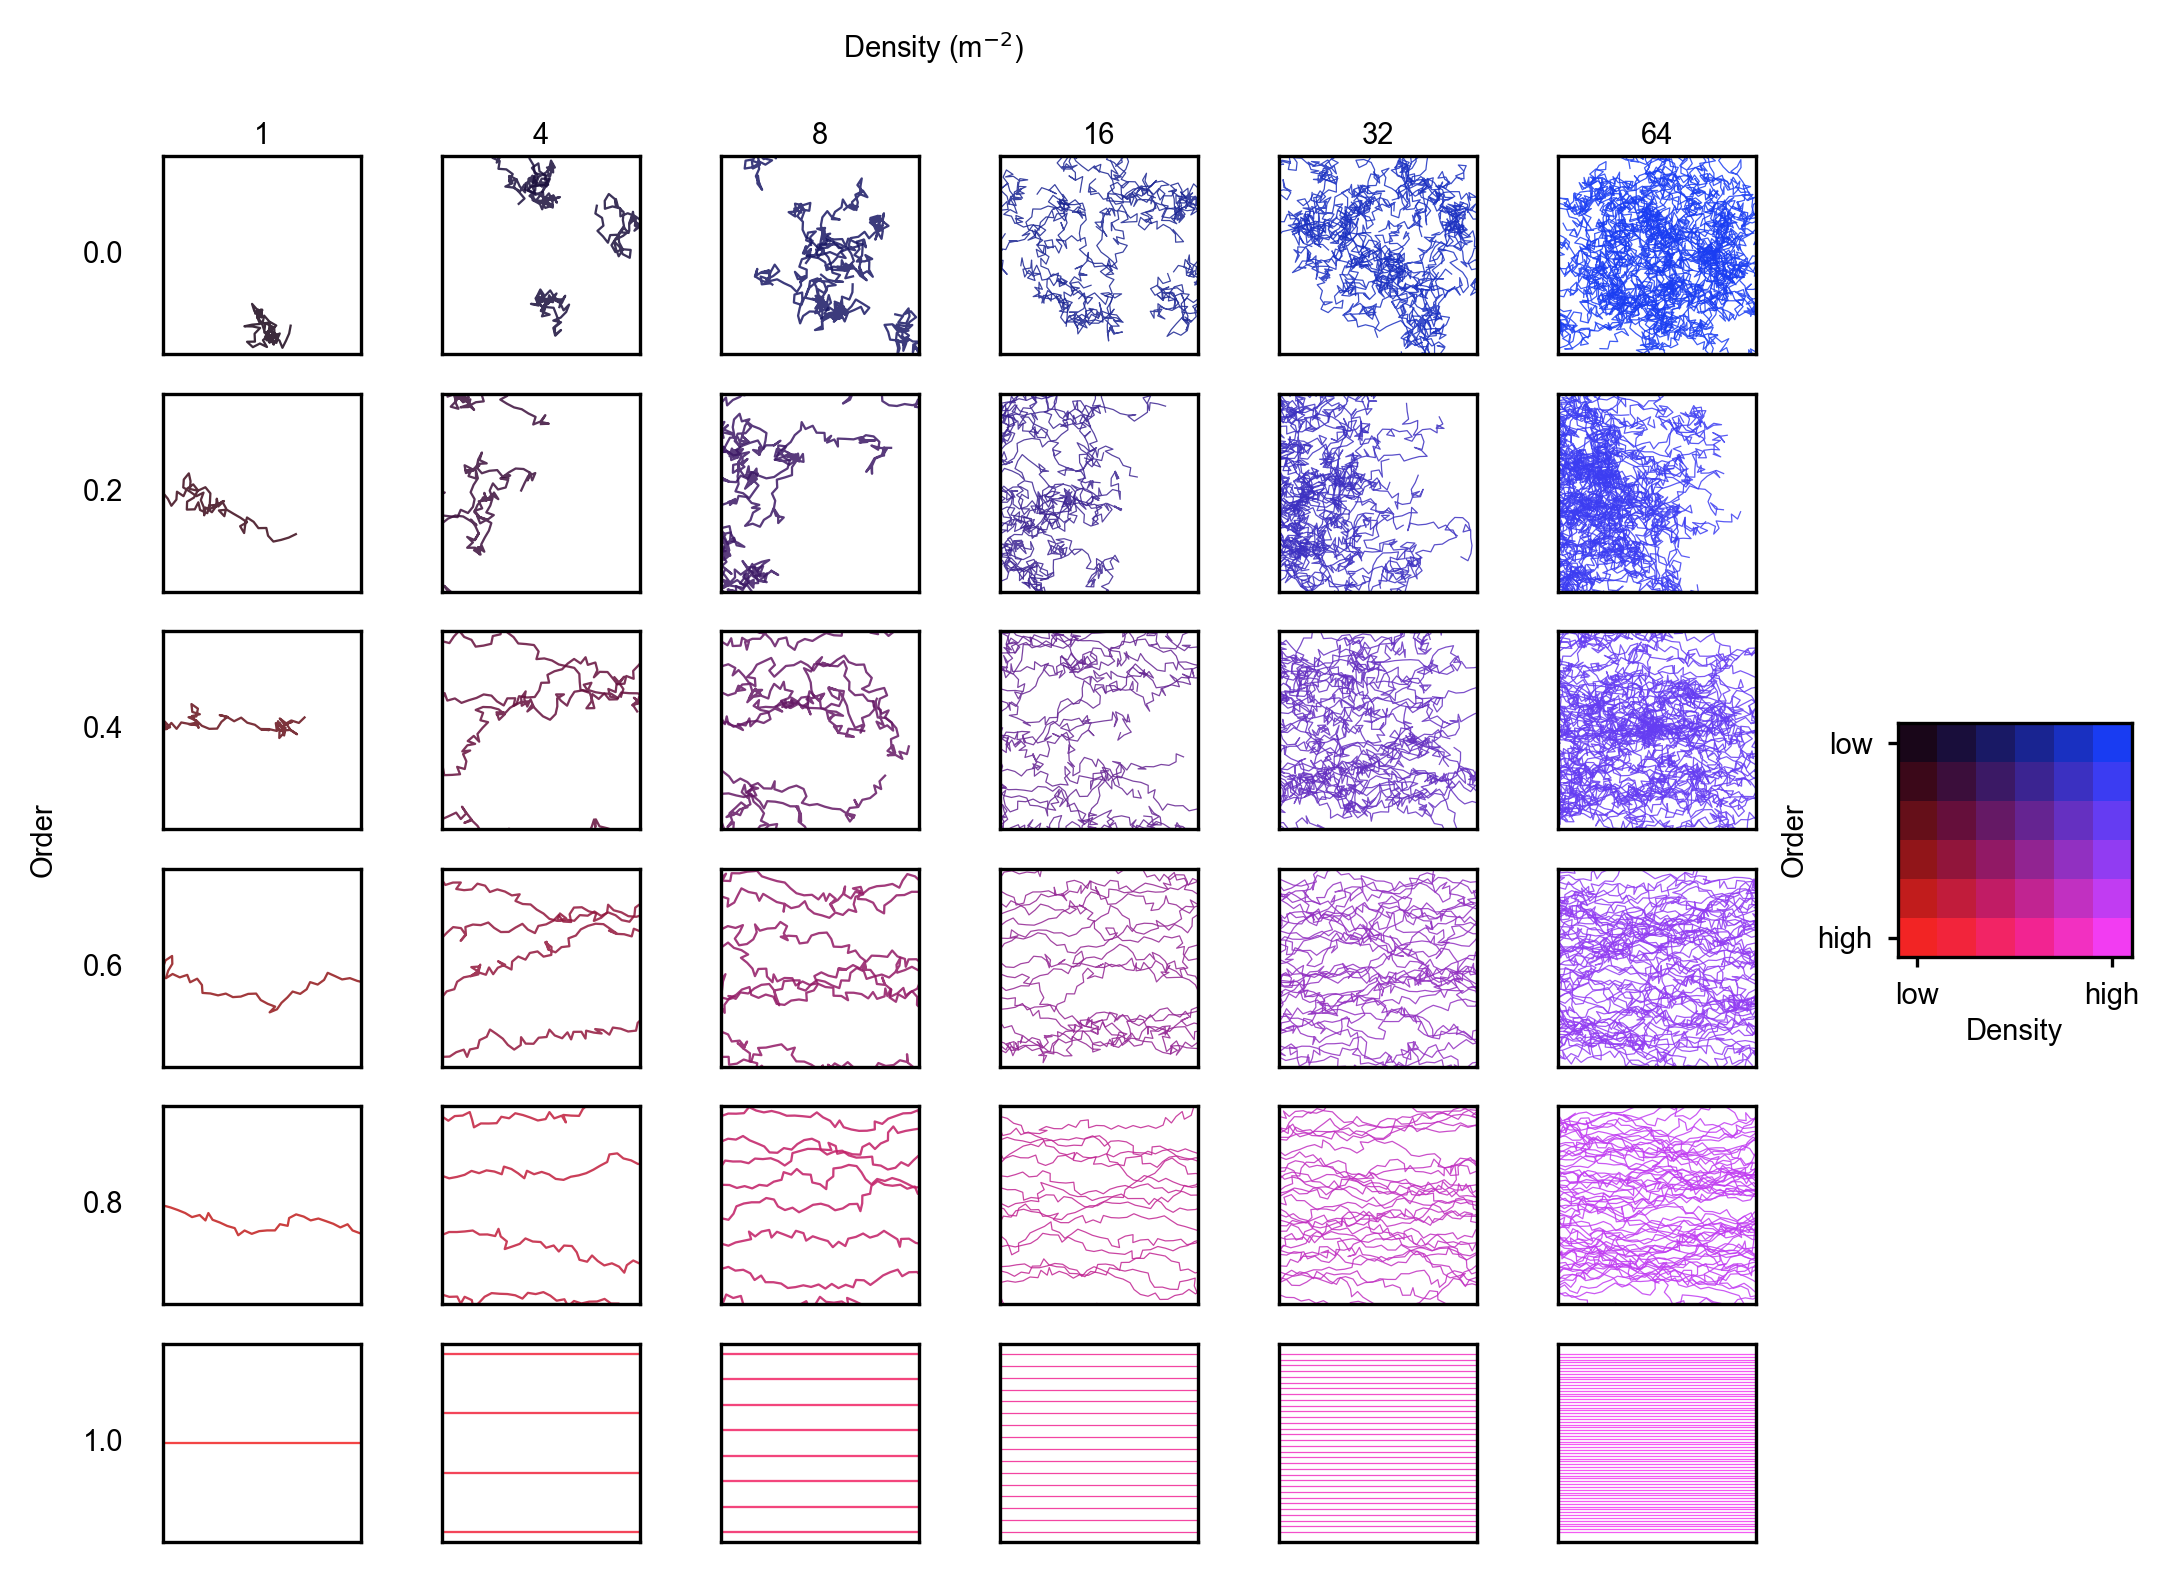

In [216]:
import numpy as np
import matplotlib.pyplot as plt
from unwrap.bessel import inverse_bessel_ratio

# -------------------------------------------------
# Parameters
# -------------------------------------------------
orders    = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
densities = np.array([1, 4, 8, 16, 32, 64])  # left->right low->high

n_rows = len(orders)
n_cols = len(densities)

n_steps = 60
step_L  = 0.04

def kappa_from_order(order: float, eps: float = 1e-6) -> float:
    """
    Map 'order' (treated as mean resultant length R) -> kappa.
    eps prevents order==1.0 from hitting the invalid boundary R=1.
    """
    R = float(np.clip(order, 0.0, 1.0 - eps))
    return inverse_bessel_ratio(R)

# -------------------------------------------------
# NEW 2D colormap: black->blue (density) + black->red (order) => deep purple
#   - density increases L->R  (blue channel contribution increases)
#   - order   increases T->B  (red channel contribution increases)
# -------------------------------------------------
def _lerp(a, b, t):
    return (1.0 - t) * np.asarray(a, float) + t * np.asarray(b, float)

def cell_color(order_idx, density_idx, n_rows, n_cols,
               tmin=0.10, tmax=0.95,
               blue=(0.10, 0.25, 1.00),
               red =(1.00, 0.15, 0.15),
               gamma=1.15,
               mix="max"):
    """
    Returns RGB tuple.

    order_idx:    0..n_rows-1   (top->bottom)
    density_idx:  0..n_cols-1   (left->right)

    mix:
      - "add": r+ b, clipped to [0,1] (can get bright quickly)
      - "max": channelwise max(red_mix, blue_mix) (keeps it deep)
    """
    # map indices to [0,1]
    to = (order_idx   / max(n_rows - 1, 1))
    td = (density_idx / max(n_cols - 1, 1))

    # perceptual tweak: slightly emphasize higher values
    to = np.power(to, gamma)
    td = np.power(td, gamma)

    # keep low end visible but still near-black
    to = tmin + (tmax - tmin) * to
    td = tmin + (tmax - tmin) * td

    black = np.array([0.0, 0.0, 0.0], float)
    c_order = _lerp(black, red,  to)   # black -> red
    c_dens  = _lerp(black, blue, td)   # black -> blue

    if mix == "add":
        c = c_order + c_dens
    else:  # "max" (default): keeps a darker, "deep purple" field
        c = np.maximum(c_order, c_dens)

    return tuple(np.clip(c, 0, 1))

# -------------------------------------------------
# Style
# -------------------------------------------------
plt.rcParams.update({
    "font.size": 7,
    "axes.linewidth": 0.8,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,
    "font.family": "Arial",
})

# -------------------------------------------------
# Figure
# -------------------------------------------------
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(6.0 + 1.0, 6.0),  # extra width for the 2D key
    dpi=300,
    squeeze=False,
)

XLIM = (0.0, 1.0)
YLIM = (0.0, 1.0)

# -------------------------------------------------
# Pairwise grid: trajectories only (n_traj == density)
# -------------------------------------------------
for r, order in enumerate(orders):
    for c, dens in enumerate(densities):
        ax = axes[r, c]
        cell_rng = np.random.default_rng(123 + 1000*r + 10*c)

        n_traj = int(dens)  # EXACTLY match density
        kappa  = kappa_from_order(order)
        col    = cell_color(r, c, n_rows, n_cols)  # <- updated palette

        # ---- start positions ----
        if order == 0.0:
            x0 = cell_rng.uniform(0.10, 0.90, size=n_traj)
            y0 = cell_rng.uniform(0.10, 0.90, size=n_traj)
        else:
            x0 = np.full(n_traj, 0.0)
            if n_traj == 1:
                y0 = np.array([0.5])  # vertically centered
            else:
                y0 = np.linspace(0.05, 0.95, n_traj)

        # ---- trajectories ----
        lw = 0.30 if n_traj >= 16 else 0.55

        for i in range(n_traj):
            if order == 1.0:
                angles = np.zeros(n_steps)
            else:
                angles = cell_rng.vonmises(mu=0.0, kappa=kappa, size=n_steps)

            dx = step_L * np.cos(angles)
            dy = step_L * np.sin(angles)

            xs = np.concatenate([[x0[i]], x0[i] + np.cumsum(dx)])
            ys = np.concatenate([[y0[i]], y0[i] + np.cumsum(dy)])

            ax.plot(xs, ys, color=col, linewidth=lw, alpha=0.85)

        # ---- formatting ----
        ax.set_xlim(*XLIM)
        ax.set_ylim(*YLIM)
        ax.set_aspect("equal", "box")
        ax.set_xticks([])
        ax.set_yticks([])

        for spine in ax.spines.values():
            spine.set_color("black")

        # Row labels (order)
        if c == 0:
            ax.text(-0.20, 0.5, f"{order:.1f}",
                    ha="right", va="center",
                    transform=ax.transAxes)

        # Column labels (density)
        if r == 0:
            ax.set_title(f"{dens:.0f}", pad=3)

# Global labels
fig.text(0.5, 0.95, "Density (m$^{-2}$)", ha="center", va="top")
fig.text(0.07, 0.5, "Order", ha="left", va="center", rotation=90)

# -------------------------------------------------
# 2D colormap key on the right
# -------------------------------------------------
key_size = 0.13
key_ax = fig.add_axes([0.95, 0.5 - key_size / 2, key_size, key_size])

grid = np.zeros((n_rows, n_cols, 3), float)
for rr in range(n_rows):
    for cc in range(n_cols):
        grid[rr, cc, :] = cell_color(rr, cc, n_rows, n_cols)

# origin="upper" => row 0 at TOP (low), bottom row high, matching subplot layout
key_ax.imshow(grid, origin="upper", aspect="equal")
key_ax.set_xlabel("Density", labelpad=2)
key_ax.set_ylabel("Order", labelpad=2)

key_ax.set_xticks([0, n_cols - 1] if n_cols > 1 else [0])
key_ax.set_yticks([0, n_rows - 1] if n_rows > 1 else [0])
key_ax.set_xticklabels(["low", "high"] if n_cols > 1 else [""])
key_ax.set_yticklabels(["low", "high"] if n_rows > 1 else [""])

# -------------------------------------------------
# Save
# -------------------------------------------------
plt.savefig("../figures/order_density_pairwise_trajectories_only.pdf",
            dpi=300, bbox_inches="tight")
plt.show()


In [15]:
# # --- Circular KDE per animal_id on the circle edge (no angular distortion) ---
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# # CONFIG
# ID_COL = 'animal_id'          # change to 'fname' if that's your per-individual column
# KAPPA = 20.0                  # von Mises concentration (bigger = smoother)
# N_ANG = 360                   # angular resolution for the curve
# THICKNESS = 0.25              # how far density can extend outward from r=1 (panel autoscale accounts for this)
# LINEWIDTH = 0.5               # curve width for each animal’s KDE
# BASE_CIRCLE_ALPHA = 0.25      # visibility of the reference unit circle

# # 0) Safety checks
# required = {'order','density',ID_COL,'dX','dY'}
# missing = required - set(merged_df.columns)
# if missing:
#     raise RuntimeError(f"merged_df is missing columns: {missing}")

# # 1) Compute heading angles (wrap in [-pi, pi))
# angles = np.arctan2(merged_df['dY'].to_numpy(), merged_df['dX'].to_numpy())
# merged_angles = merged_df.assign(theta=angles)

# # 2) Small helper for sorting
# def _sorted_unique(series):
#     vals = series.dropna().unique().tolist()
#     try:
#         return sorted(vals, key=float)
#     except Exception:
#         return sorted(vals)

# orders    = _sorted_unique(merged_angles['order'])
# densities = _sorted_unique(merged_angles['density'])

# # 3) von Mises circular KDE
# #    f(theta) = (1/n) * sum_i VM_kappa(theta - theta_i), VM_kappa(Δ) = exp(kappa*cos(Δ)) / (2π I0(kappa))
# def circular_kde_vm(sample_angles, thetas_eval, kappa=KAPPA):
#     sample_angles = np.asarray(sample_angles, dtype=float)
#     if sample_angles.size == 0:
#         return np.zeros_like(thetas_eval)
#     # pairwise differences (broadcast)
#     d = thetas_eval[:, None] - sample_angles[None, :]
#     num = np.exp(kappa * np.cos(d))
#     denom = 2.0 * np.pi * np.i0(kappa)  # I0 is the modified Bessel of first kind, order 0
#     f = num.sum(axis=1) / (denom * sample_angles.size)
#     return f

# thetas_eval = np.linspace(-np.pi, np.pi, N_ANG, endpoint=False)

# # 4) Shared limits/ticks (circle + outward thickness)
# L = 1.0 + THICKNESS + 0.05  # padding beyond max radius
# XLIM = (-L, L)
# YLIM = (-L, L)
# N_TICKS = 3
# XTICKS = np.linspace(-L, L, N_TICKS)
# YTICKS = np.linspace(-L, L, N_TICKS)

# print(f"Auto limits set to XLIM={XLIM}, YLIM={YLIM}")
# print(f"Auto ticks set to XTICKS={XTICKS}, YTICKS={YTICKS}")

# # 5) Plot grid rows=order, cols=density
# plt.rcParams.update({
#     'font.size': 8,
#     'ytick.major.width': 1,
#     'xtick.major.width': 1,
#     'axes.linewidth': 1,
#     'font.family': 'Arial'
# })

# n_rows = len(orders)
# n_cols = len(densities)

# fig, axes = plt.subplots(
#     n_rows, n_cols,
#     figsize=(n_cols * 1.6, n_rows * 1.6),
#     dpi=300,
#     squeeze=False
# )

# cmap = plt.cm.tab20

# for r, o in enumerate(orders):
#     for c, d in enumerate(densities):
#         ax = axes[r, c]
#         panel = merged_angles[(merged_angles['order'] == o) & (merged_angles['density'] == d)]

#         # empty panel?
#         if panel.empty:
#             ax.set_title(f"d={d} | o={o}", fontsize=8)
#             ax.set_xlim(*XLIM); ax.set_ylim(*YLIM)
#             ax.set_xticks(XTICKS); ax.set_yticks(YTICKS)
#             ax.set_aspect('equal')
#             ax.text(0.5, 0.5, "no data", ha='center', va='center',
#                     transform=ax.transAxes, alpha=0.6)
#             continue

#         # draw the base unit circle (r=1)
#         t = np.linspace(0, 2*np.pi, 512)
#         ax.plot(np.cos(t), np.sin(t), lw=0.8, alpha=BASE_CIRCLE_ALPHA, color='k')

#         # loop animals in this panel
#         animals = _sorted_unique(panel[ID_COL])
#         for i, aid in enumerate(animals):
#             angs = panel.loc[panel[ID_COL] == aid, 'theta'].to_numpy()

#             # KDE on the unit circle, then normalize per animal (for visual comparability within panel)
#             f = circular_kde_vm(angs, thetas_eval, kappa=KAPPA)
#             if np.allclose(f.max(), 0):
#                 continue
#             f_norm = f / f.max()  # scale peak to 1

#             # put density on the edge (r=1) and extend outward only by THICKNESS
#             r_curve = 0.5 + THICKNESS * f_norm
#             x = r_curve * np.cos(thetas_eval)
#             y = r_curve * np.sin(thetas_eval)

#             ax.plot(x, y, linewidth=LINEWIDTH, alpha=0.95, color=cmap(i / max(len(animals), 1)))

#         # aesthetics
#         ax.set_xlim(*XLIM); ax.set_ylim(*YLIM)
#         ax.set_xticks(XTICKS); ax.set_yticks(YTICKS)
#         ax.set_aspect('equal')
#         ax.set_title(f"d={d} | o={o}", fontsize=8)

# fig.suptitle(
#     "Per-animal circular KDEs by Order (rows) × Density (cols)\n"
#     "(density starts at r=1 and grows outward; no angular distortion)",
#     fontsize=9, y=1.02
# )
# fig.tight_layout()
# plt.show()


In [16]:
# # --- Population circular KDE per condition (hierarchical bootstrap) with SEAMLESS WRAP on polar axes ---
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.patches import Circle
# from joblib import Parallel, delayed
# from tqdm.auto import tqdm

# # =========================
# # Config
# # =========================
# ID_COL       = 'animal_id'   # change to 'fname' if needed
# COND_COLS    = ['order','density']
# KAPPA        = 30.0          # von Mises concentration
# N_POINTS     = 360           # angular resolution
# N_BOOT       = 1000
# CI_LO, CI_HI = 2.5, 97.5
# EDGE_R       = 1.0           # start density at the circle edge
# THICKNESS    = 0.35          # visual outward thickness at peak
# RIB_ALPHA    = 0.25
# MED_LINE_W   = 1.6

# # =========================
# # Utilities
# # =========================
# def _sorted_unique(series):
#     vals = series.dropna().unique().tolist()
#     try:
#         return sorted(vals, key=float)
#     except Exception:
#         return sorted(vals)

# def bootstrap_summary_stats(bootstrap_samples, axis=0, lower=2.5, upper=97.5):
#     p = np.percentile(bootstrap_samples, [lower, 50, upper], axis=axis)
#     lo, med, hi = p
#     return {'median': med, 'lower_bounds': lo, 'upper_bounds': hi}

# def hierarchical_bootstrap(data, labels, compute_func, n_bootstraps=10000, n_jobs=-1, random_state=None):
#     data = np.asarray(data); labels = np.asarray(labels)
#     rng = np.random.default_rng(random_state)
#     uniq, inv = np.unique(labels, return_inverse=True)
#     buckets = [np.flatnonzero(inv == i) for i in range(len(uniq))]
#     nL = len(uniq)

#     def one(seed):
#         r = np.random.default_rng(seed)
#         Lids = r.integers(0, nL, size=nL, endpoint=False)
#         perL = []
#         for lid in Lids:
#             idx = buckets[lid]
#             boot_idx = idx[r.integers(0, len(idx), size=len(idx), endpoint=False)]
#             perL.append(compute_func(data[boot_idx]))
#         return np.mean(np.asarray(perL), axis=0)

#     seeds = rng.integers(0, np.iinfo(np.int32).max, size=n_bootstraps, endpoint=False)
#     out = Parallel(n_jobs=n_jobs)(delayed(one)(int(s)) for s in tqdm(seeds, desc="Hierarchical bootstrapping"))
#     return np.asarray(out)

# def von_mises_kde(data, pts, kappa):
#     c = 1.0 / (2.0 * np.pi * np.i0(kappa))
#     return c * np.exp(kappa * np.cos(pts[:, None] - data[None, :])).mean(axis=1)

# def bootstrap_von_mises_kde(data, labels, kappa, n_bootstraps=4000, n_points=360):
#     data = (data + np.pi) % (2*np.pi) - np.pi
#     ang = np.linspace(-np.pi, np.pi, n_points, endpoint=False)
#     def comp(samp): return von_mises_kde(samp, ang, kappa)
#     boots = hierarchical_bootstrap(data, labels, comp, n_bootstraps=n_bootstraps, n_jobs=-1)
#     return {'angles': ang, 'bootstrap_kdes': boots}

# # --- wrap helpers to avoid seam gaps on polar ---
# def _to_0_2pi(theta):
#     """Map [-pi,pi) -> [0,2pi) and return sorted angles + order index."""
#     t = (theta + 2*np.pi) % (2*np.pi)
#     order = np.argsort(t)
#     return t[order], order

# def _wrap_curve(theta, r):
#     """
#     Ensure continuity across seam for plot() by appending the first point at +2π.
#     theta must already be in [0, 2π) **and sorted**.
#     """
#     return np.r_[theta, theta[0] + 2*np.pi], np.r_[r, r[0]]

# def _wrap_ribbon(theta, r_lo, r_hi):
#     """
#     Produce a single closed path (theta_hi ++ theta_lo[::-1], same for r) for fill_between on polar.
#     Inputs theta in [0,2π) sorted. We also append seam points.
#     """
#     th_hi, r_hi2 = _wrap_curve(theta, r_hi)
#     th_lo, r_lo2 = _wrap_curve(theta, r_lo)
#     th = np.r_[th_hi, th_lo[::-1]]
#     rr = np.r_[r_hi2, r_lo2[::-1]]
#     return th, rr

# # =========================
# # Prepare data
# # =========================
# # ensure we have directions
# if 'direction' not in merged_df.columns:
#     if {'dX','dY'}.issubset(merged_df.columns):
#         merged_df = merged_df.assign(direction=np.arctan2(merged_df['dY'].to_numpy(),
#                                                           merged_df['dX'].to_numpy()))
#     else:
#         raise RuntimeError("Provide 'direction' or ('dX','dY') in merged_df.")

# if ID_COL not in merged_df.columns:
#     ID_COL = 'fname' if 'fname' in merged_df.columns else ID_COL
#     if ID_COL not in merged_df.columns:
#         raise RuntimeError(f"Could not find ID column ('animal_id' or 'fname').")

# for col in COND_COLS:
#     if col not in merged_df.columns:
#         raise RuntimeError(f"Missing condition column '{col}' in merged_df.")

# orders    = _sorted_unique(merged_df[COND_COLS[0]])
# densities = _sorted_unique(merged_df[COND_COLS[1]])

# # =========================
# # Figure scaffold (polar grid)
# # =========================
# plt.rcParams['ytick.major.width'] = 2
# plt.rcParams['xtick.major.width'] = 2
# plt.rcParams['axes.linewidth'] = 2
# plt.rcParams['font.family'] = 'Arial'
# plt.rcParams.update({'font.size': 8})

# n_rows, n_cols = len(orders), len(densities)
# fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'},
#                          figsize=(n_cols*2.2, n_rows*2.2), dpi=300, squeeze=False)

# # ticks at [-π, -π/2, 0, π/2, π] but mapped into [0, 2π)
# tick_angles = np.array([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
# tick_angles_02 = (tick_angles + 2*np.pi) % (2*np.pi)
# tick_labels = [r"", r"$-\frac{1}{2}\pi$", r"$0$", r"$\frac{1}{2}\pi$", r"$\pm\pi$"]

# for r_i, o in enumerate(orders):
#     for c_i, d in enumerate(densities):
#         ax = axes[r_i, c_i]
#         panel = merged_df[(merged_df[COND_COLS[0]] == o) & (merged_df[COND_COLS[1]] == d)]

#         # base styling
#         ax.set_theta_zero_location("E")   # 0 at +x axis (like Cartesian), optional
#         ax.set_theta_direction(-1)        # increase clockwise to match many compass-like plots, optional
#         ax.set_xticks(tick_angles_02)
#         ax.set_xticklabels(tick_labels, fontsize=10)
#         ax.set_yticks([])
#         ax.spines['polar'].set_visible(False)
#         ax.set_title(f"d={d} | o={o}", va='bottom', fontsize=8)

#         if panel.empty:
#             # draw just the edge circle
#             ax.plot(np.linspace(0, 2*np.pi, 361, endpoint=True),
#                     np.full(361, EDGE_R), color="black", linewidth=0.5)
#             ax.text(np.deg2rad(90), EDGE_R+0.1, "no data", ha='center', va='center', alpha=0.6)
#             continue

#         # outer reference edge (r=1)
#         ax.plot(np.linspace(0, 2*np.pi, 361, endpoint=True),
#                 np.full(361, EDGE_R), color="black", linewidth=0.5)

#         # data & labels for this condition
#         th = panel['direction'].to_numpy()
#         ids = panel[ID_COL].to_numpy()

#         # hierarchical bootstrap KDE
#         boot = bootstrap_von_mises_kde(th, ids, kappa=KAPPA, n_bootstraps=N_BOOT, n_points=N_POINTS)
#         summ = bootstrap_summary_stats(boot['bootstrap_kdes'], axis=0, lower=CI_LO, upper=CI_HI)
#         ang = boot['angles']                          # in [-π, π)
#         med, lo, hi = summ['median'], summ['lower_bounds'], summ['upper_bounds']

#         # panel-wise normalization so max(hi) reaches THICKNESS
#         scale = np.max(hi) if np.max(hi) > 0 else 1.0
#         med_n, lo_n, hi_n = med/scale, lo/scale, hi/scale

#         # radii (start at EDGE_R and grow outward)
#         r_med = EDGE_R + THICKNESS * med_n
#         r_lo  = EDGE_R + THICKNESS * lo_n
#         r_hi  = EDGE_R + THICKNESS * hi_n

#         # map to [0,2π), sort, and build wrapped paths
#         ang02, order = _to_0_2pi(ang)
#         r_med_s = r_med[order]; r_lo_s = r_lo[order]; r_hi_s = r_hi[order]

#         th_curve, r_curve = _wrap_curve(ang02, r_med_s)
#         th_ribbon, r_ribbon = _wrap_ribbon(ang02, r_lo_s, r_hi_s)

#         # draw CI ribbon and median line (seamless)
#         ax.fill(th_ribbon, r_ribbon, color='tab:blue', alpha=RIB_ALPHA, linewidth=0)
#         ax.plot(th_curve, r_curve, color='tab:blue', linewidth=MED_LINE_W)

#         # radial limit
#         ax.set_rlim(0, EDGE_R + THICKNESS * 1.2)

# # (Optional) Shared legend proxy (one panel)
# # You can build a custom legend like your example using handler_map/customer_handler if you have it defined.
# # Here’s a minimal version without custom handlers:
# from matplotlib.lines import Line2D
# legend_handles = [
#     Line2D([0],[0], color='tab:blue', lw=MED_LINE_W, label='KDE (median)'),
#     Line2D([0],[0], color='tab:blue', lw=8, alpha=RIB_ALPHA, label='KDE 95% CI')
# ]
# axes[0,0].legend(handles=legend_handles, bbox_to_anchor=(1, 1), frameon=False, loc="center left")

# fig.suptitle('Population-Level Circular KDE per Condition (hierarchical bootstrap)\n'
#              'Density starts at r=1 and grows outward; curves/ribbons wrap seamlessly',
#              y=1.02, fontsize=9)
# plt.tight_layout()
# plt.show()


In [17]:
# --- Angles of mean vectors per (order, density, fname) ---
import numpy as np
import pandas as pd

# Mean (dX, dY) per individual per condition
angles_df = (
    merged_df
    .copy()
    .groupby(['order', 'density', 'fname'], as_index=False)[['dX', 'dY']]
    .mean()
    .rename(columns={'dX': 'mean_dX', 'dY': 'mean_dY'})
)

# Angle (no normalization), magnitude for reference
angles_df['angle_rad'] = np.arctan2(angles_df['mean_dY'], angles_df['mean_dX'])
angles_df['angle_deg'] = np.degrees(angles_df['angle_rad'])
angles_df['magnitude'] = np.hypot(angles_df['mean_dX'], angles_df['mean_dY'])

# Optional: sort nicely
angles_df = angles_df.sort_values(['order', 'density', 'fname'], kind='stable').reset_index(drop=True)

print(angles_df.head())
# Optional: save
# angles_df.to_csv('mean_vector_angles_by_condition.csv', index=False)


   order  density          fname   mean_dX   mean_dY  angle_rad   angle_deg  \
0    0.0        1  20220831_1031 -0.227052 -0.006860  -3.111391 -178.269551   
1    0.0        1  20220831_1631 -0.014402  0.043188   1.892666  108.441761   
2    0.0        1  20220902_1816  0.033093 -0.026388  -0.673137  -38.567935   
3    0.0        1  20220907_1101  0.153444  0.016937   0.109937    6.298902   
4    0.0        1  20220910_1300 -0.145857 -0.098390  -2.548141 -145.997741   

   magnitude  
0   0.227156  
1   0.045526  
2   0.042326  
3   0.154376  
4   0.175940  


In [18]:
from math import pi
import numpy as np
import pandas as pd
import bambi as bmb

# Links & priors from unwrap (as in your example)
from unwrap.prior import CircularUniformPrior
from unwrap.link.bambi import circular_modulo, softplus
from unwrap.link import inverse_softplus

# ----------------------------
# Transform helpers (your defs)
# ----------------------------
def normalize(x):
    return x * 2.0 - 1.0

def log2_scale(x, min_size=1., max_size=64.):
    return np.log2(x / min_size) / np.log2(max_size / min_size)

def inv_log2_scale(x, min_size=1., max_size=64.):
    inv = x * np.log2(max_size / min_size)
    inv = 2**inv
    inv *= min_size
    return inv

def inv_normalize(x):
    return (x + 1.0) / 2.0

def exp_scale(x, min_size=1., max_size=64.):
    return (x - min_size) / (max_size - min_size)

# ----------------------------
# Build modeling table
# ----------------------------
# angles_df must have: ['order','density','fname','angle_rad'] from the previous step
df = angles_df.copy()

# Make sure y is wrapped to (-pi, pi]
df["y"] = ((df["angle_rad"] + np.pi) % (2 * np.pi)) - np.pi

# Choose scaling bounds for density (adjust to your experiment if needed)
DENS_MIN, DENS_MAX = 1.0, 64.0  # <- change these to your actual density range

# Transform predictors
# df["t_density"] = normalize(exp_scale(df["density"].astype(float), DENS_MIN, DENS_MAX))
df["t_density"] = normalize(log2_scale(df["density"].astype(float), DENS_MIN, DENS_MAX))
df["t_order"]   = normalize(df["order"].astype(float))

# (Optional) sanity checks
assert df["t_density"].between(-1, 1).all()
assert df["t_order"].between(-1, 1).all()

# ----------------------------
# Specify the model
# ----------------------------
# μ depends on both predictors and their interaction.
# κ depends on both predictors (you can add the interaction if you need it).
formula = bmb.Formula("y ~ t_density * t_order",
                      "kappa ~ t_density * t_order"
                     )

priors = {
    # μ parameters (circular)
    "Intercept":  bmb.Prior("VonMises", mu=0.0, kappa=1e-6),                      # U(-pi, pi]
    "t_density": bmb.Prior("Normal", mu=0.0, sigma=0.5*pi),   # slope priors on μ
    "t_order":   bmb.Prior("Normal", mu=0.0, sigma=0.5*pi),
    "t_density:t_order": bmb.Prior("Normal", mu=0.0, sigma=0.5*pi),

    # κ parameters (on pre-link scale)
    "kappa": {
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2.0), sigma=1.0),  # baseline κ≈1
        "t_density": bmb.Prior("Normal", mu=0.0, sigma=1.0),
        "t_order":   bmb.Prior("Normal", mu=0.0, sigma=1.0),
        "t_density:t_order":   bmb.Prior("Normal", mu=0.0, sigma=1.0),
    },
}

model = bmb.Model(
    formula=formula,
    data=df,
    family="vonmises",
    priors=priors,
    link={"mu": circular_modulo, "kappa": softplus},
    center_predictors=False,
)

# Fit
idata = model.fit(idata_kwargs=dict(log_likelihood = True))

# Quick summary
print(model)
print(idata)
# bmb.summary(idata)  # or arviz.summary(idata)


Initializing NUTS using jitter+adapt_diag...
/home/jake/.local/lib/python3.10/site-packages/pytensor/link/c/cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, t_density, t_order, t_density:t_order, kappa_Intercept, kappa_t_density, kappa_t_order, kappa_t_density:t_order]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


       Formula: y ~ t_density * t_order
                kappa ~ t_density * t_order
        Family: vonmises
          Link: mu = circular_modulo
                kappa = softplus
  Observations: 440
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ VonMises(mu: 0.0, kappa: 0.0)
            t_density ~ Normal(mu: 0.0, sigma: 1.5708)
            t_order ~ Normal(mu: 0.0, sigma: 1.5708)
            t_density:t_order ~ Normal(mu: 0.0, sigma: 1.5708)
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 1.0)
            kappa_t_density ~ Normal(mu: 0.0, sigma: 1.0)
            kappa_t_order ~ Normal(mu: 0.0, sigma: 1.0)
            kappa_t_density:t_order ~ Normal(mu: 0.0, sigma: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()
Inference data with groups:
	> posterior
	

In [19]:
import arviz as az
az.summary(idata, circ_var_names=["Intercept"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                0.043  0.078  -0.101    0.190      0.002    0.001   
kappa_Intercept          1.373  0.170   1.065    1.702      0.003    0.003   
kappa_t_density          0.804  0.251   0.344    1.286      0.004    0.004   
kappa_t_density:t_order  1.021  0.391   0.276    1.735      0.006    0.006   
kappa_t_order            2.517  0.282   2.000    3.044      0.005    0.004   
t_density                0.071  0.111  -0.131    0.282      0.002    0.002   
t_density:t_order        0.144  0.157  -0.166    0.421      0.003    0.002   
t_order                 -0.117  0.106  -0.312    0.080      0.002    0.001   

                         ess_bulk  ess_tail  r_hat  
Intercept                  2261.0    2522.0    1.0  
kappa_Intercept            3748.0    3112.0    1.0  
kappa_t_density            3802.0    2796.0    1.0  
kappa_t_density:t_order    3680.0    2980.0    1.0  
kappa_t_order              2727.0    2394.0    1.0  
t_density                  2123.0    2390.0    1.0  
t_density:t_order          2127.0    2606.0    1.0  
t_order                    2234.0    2536.0    1.0

/tmp/ipykernel_539555/1905449422.py:72: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi68 = az.hdi(align, hdi_prob=0.68, skipna=True)
/tmp/ipykernel_539555/1905449422.py:72: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi68 = az.hdi(align, hdi_prob=0.68, skipna=True)
/tmp/ipykernel_539555/1905449422.py:72: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi68 = az.hdi(align, hdi_prob=0.68, skipna=True)
/tmp/ipykernel_539555/1905449422.py:72: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi68 = az.hdi(align, hdi_prob=0.68, skipna=True)


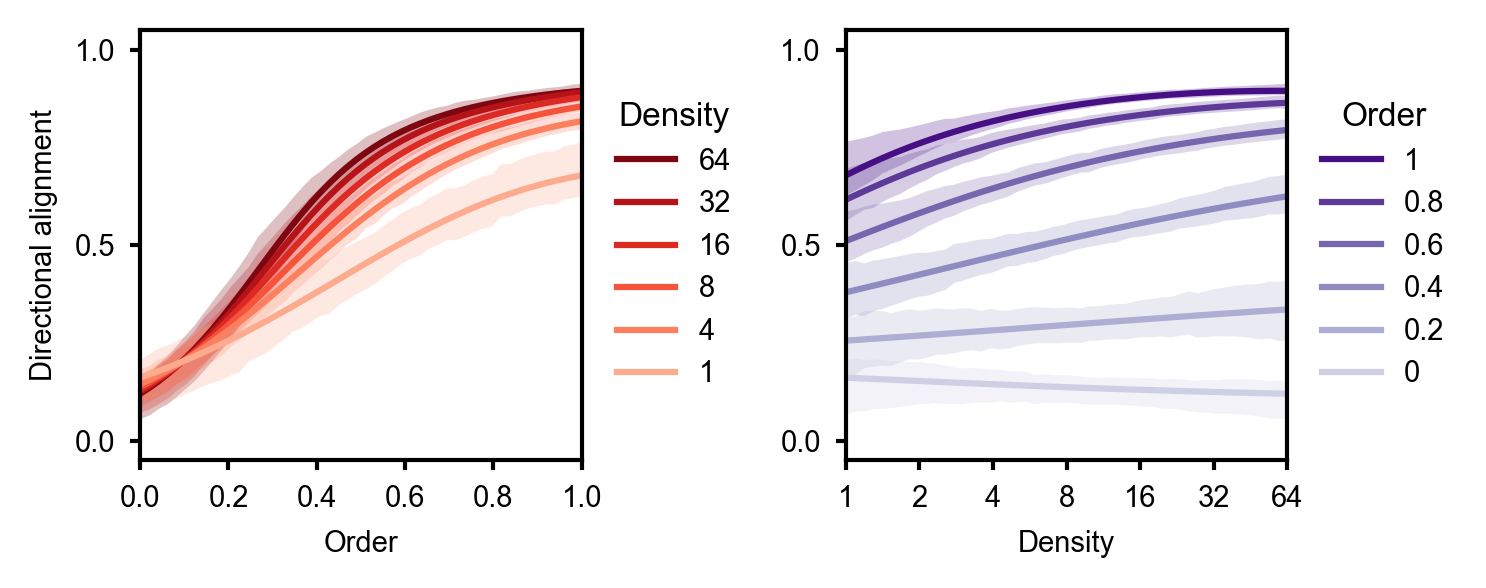

In [167]:
# --- Predict directional alignment = A(kappa) * cos(mu) and replicate two panels ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from scipy.special import i0, i1  # A(kappa) = I1/I0

# same transforms you used in the model
from math import pi
def normalize(x): return x * 2.0 - 1.0
def log2_scale(x, min_size=1., max_size=64.):
    return np.log2(x / min_size) / np.log2(max_size / min_size)

DENS_MIN, DENS_MAX = 1.0, 64.0  # match training bounds

def softplus(x):
    return np.log1p(np.exp(x))

def circular_modulo(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def A_of_kappa(kappa):
    return i1(kappa) / i0(kappa)

def posterior_linpred(idata, prefix, X_df):
    post = idata.posterior
    if prefix:
        coefs = [v for v in post.data_vars if v.startswith(prefix)]
        key_intercept = f"{prefix}Intercept"
    else:
        coefs = [v for v in post.data_vars if (not v.startswith("kappa_"))]
        key_intercept = "Intercept"

    if key_intercept not in post:
        raise ValueError(f"Intercept for prefix '{prefix}' not found in posterior.")

    def flat(name):
        return post[name].stack(sample=("chain", "draw")).values

    n = len(X_df)
    eta = np.tile(flat(key_intercept)[:, None], (1, n))

    for coef in coefs:
        if coef == key_intercept:
            continue
        col = coef.replace(prefix, "")
        if col in X_df.columns:
            eta += flat(coef)[:, None] * X_df[col].to_numpy()[None, :]

    return eta

def make_X(order_vals, density_vals, idata):
    X = pd.DataFrame({"order": order_vals, "density": density_vals})
    X["t_order"]   = normalize(X["order"].astype(float))
    X["t_density"] = normalize(log2_scale(X["density"].astype(float), DENS_MIN, DENS_MAX))
    if ("t_density:t_order" in idata.posterior.data_vars or
        "kappa_t_density:t_order" in idata.posterior.data_vars):
        X["t_density:t_order"] = X["t_density"] * X["t_order"]
    return X

def posterior_alignment(idata, X):
    eta_mu    = posterior_linpred(idata, prefix="",       X_df=X)
    eta_kappa = posterior_linpred(idata, prefix="kappa_", X_df=X)

    mu    = circular_modulo(eta_mu)
    kappa = softplus(eta_kappa)

    A = A_of_kappa(kappa)
    align = A * np.cos(mu)

    mean = align.mean(axis=0)
    hdi68 = az.hdi(align, hdi_prob=0.68, skipna=True)
    return {"mean": mean, "low": hdi68[:, 0], "high": hdi68[:, 1]}

# ---- prediction grids ----
# DESCENDING so legends list largest -> smallest (top -> bottom)
dens_levels  = np.sort(merged_df["density"].unique())[::-1]
order_levels = np.sort(merged_df["order"].unique())[::-1]

order_grid   = np.linspace(order_levels.min(), order_levels.max(), 50)
density_grid = np.geomspace(max(dens_levels.min(), 1e-6), dens_levels.max(), 50)

# Panel (i): vs Order, colored by Density
pred_i = {}
for d in dens_levels:
    X = make_X(order_grid, np.full_like(order_grid, d, dtype=float), idata)
    keep_cols = ["t_order", "t_density"] + (["t_density:t_order"] if "t_density:t_order" in X.columns else [])
    pred_i[d] = posterior_alignment(idata, X[keep_cols])

# Panel (ii): vs Density, colored by Order
pred_ii = {}
for o in order_levels:
    X = make_X(np.full_like(density_grid, o, dtype=float), density_grid, idata)
    keep_cols = ["t_order", "t_density"] + (["t_density:t_order"] if "t_density:t_order" in X.columns else [])
    pred_ii[o] = posterior_alignment(idata, X[keep_cols])

# ---- plot with legends (same style) ----
plt.rcParams.update({
    "font.size": 8, "ytick.major.width": 1, "xtick.major.width": 1,
    "axes.linewidth": 1, "font.family": "Arial"
})

fig, axs = plt.subplots(1, 2, figsize=(5, 2), dpi=300)
ax1, ax2 = axs

cmap_density = plt.cm.Reds
cmap_order   = plt.cm.Purples

# Panel i: Alignment vs Order (colored by Density) — descending legend, but KEEP color mapping (high = darker)
colors_d = np.linspace(0.95, 0.3, len(dens_levels))  # first (highest density) darkest
h_i, l_i = [], []
for i, d in enumerate(dens_levels):
    col = cmap_density(colors_d[i])
    y = pred_i[d]["mean"]; lo = pred_i[d]["low"]; hi = pred_i[d]["high"]
    line, = ax1.plot(order_grid, y, color=col, lw=1.5)
    ax1.fill_between(order_grid, lo, hi, color=col, alpha=0.25, linewidth=0)
    h_i.append(line); l_i.append(f"{d:g}")
ax1.set_xlabel("Order"); ax1.set_ylabel("Directional alignment")
ax1.set_xlim(order_grid.min(), order_grid.max())
ax1.set_ylim(-0.05, 1.05); ax1.set_yticks([0.0, 0.5, 1.0])
ax1.legend(h_i, l_i, title="Density", loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

# Panel ii: Alignment vs Density (colored by Order) — descending legend, KEEP color mapping (high = darker)
colors_o = np.linspace(0.95, 0.3, len(order_levels))  # first (highest order) darkest
h_ii, l_ii = [], []
for i, o in enumerate(order_levels):
    col = cmap_order(colors_o[i])
    y = pred_ii[o]["mean"]; lo = pred_ii[o]["low"]; hi = pred_ii[o]["high"]
    line, = ax2.plot(density_grid, y, color=col, lw=1.5)
    ax2.fill_between(density_grid, lo, hi, color=col, alpha=0.25, linewidth=0)
    h_ii.append(line); l_ii.append(f"{o:.1f}" if (o % 1) else f"{int(o)}")
ax2.set_xscale("log", base=2)
ax2.set_xlabel("Density"); ax2.set_xlim(density_grid.min(), density_grid.max())
ax2.set_xticks([1, 2, 4, 8, 16, 32, 64])
ax2.set_xticklabels([1, 2, 4, 8, 16, 32, 64])
ax2.set_ylim(-0.05, 1.05); ax2.set_yticks([0.0, 0.5, 1.0])
ax2.legend(h_ii, l_ii, title="Order", loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

fig.tight_layout()
plt.show()


In [21]:
# # --- put these near the top with your imports ---
# from math import pi
# import numpy as np
# import pandas as pd
# import arviz as az
# import matplotlib.pyplot as plt
# import bambi as bmb

# from unwrap.prior import CircularUniformPrior
# from unwrap.link.bambi import circular_modulo, softplus
# from unwrap.link import inverse_softplus

# # -----------------------------
# # κ model set (your exact names)
# # -----------------------------
# KAPPA_MODELS = [
#     ("Intercept-only", []),
#     ("Density", ["t_density"]),
#     ("Order", ["t_order"]),
#     ("Density + Order", ["t_density", "t_order"]),
#     ("Density × Order", ["t_density", "t_order", "t_density:t_order"]),
# ]

# # -----------------------------
# # Build formula / priors helpers
# # -----------------------------
# def build_formula(kappa_terms):
#     # μ is ALWAYS intercept-only
#     mu_rhs = "t_density * t_order"
#     k_rhs = " + ".join(kappa_terms) if kappa_terms else "1"
#     return bmb.Formula(f"y ~ {mu_rhs}", f"kappa ~ {k_rhs}")

# # Prior templates
# # μ intercept prior: circular uniform
# # κ priors live on the pre-link (inverse-softplus) scale
# K_INTERCEPT_PRIOR = bmb.Prior("Normal", mu=inverse_softplus(1.0), sigma=1.0)
# K_SLOPE_PRIOR     = bmb.Prior("Normal", mu=0.0, sigma=1.0)

# def build_priors(kappa_terms):
#     pri = {}

#     # μ (intercept-only)
#     pri["Intercept"] = CircularUniformPrior()

#     # κ (intercept + optional terms)
#     pri["kappa"] = {"Intercept": K_INTERCEPT_PRIOR}
#     for term in kappa_terms:
#         if term == "1":
#             continue
#         pri["kappa"][term] = K_SLOPE_PRIOR

#     return pri

# def _grab(obj, *names):
#     """Robustly extract fields from arviz ELPD objects across versions."""
#     for n in names:
#         if hasattr(obj, n):
#             return getattr(obj, n)
#     for n in names:
#         try:
#             return obj[n]
#         except Exception:
#             pass
#     return None

# # ---------------------------------------
# # Fit + PSIS-LOO for κ-only model sweep
# # ---------------------------------------
# results = []
# models  = []
# idatas  = []

# for pretty_name, kappa_terms in KAPPA_MODELS:
#     print(f"\n=== Fitting {pretty_name} ===")

#     formula = build_formula(kappa_terms)
#     priors  = build_priors(kappa_terms)

#     mdl = bmb.Model(
#         formula=formula,
#         data=df,                 # assumes df already exists
#         family="vonmises",
#         priors=priors,
#         link={"mu": circular_modulo, "kappa": softplus},
#     )

#     fit_idata = mdl.fit(
#         draws=1000,
#         chains=4,
#         target_accept=0.9,
#         idata_kwargs={"log_likelihood": True},
#     )

#     loo_res = az.loo(fit_idata)

#     elpd = _grab(loo_res, "elpd_loo", "elpd")
#     se   = _grab(loo_res, "elpd_loo_se", "se", "elpd_se")
#     p_eff= _grab(loo_res, "p_loo", "p_eff")

#     results.append({
#         "pretty_name": pretty_name,
#         "kappa_terms": kappa_terms,
#         "elpd": float(elpd) if elpd is not None else float("nan"),
#         "se": float(se) if se is not None else float("nan"),
#         "p_eff": float(p_eff) if p_eff is not None else float("nan"),
#     })

#     models.append(mdl)
#     idatas.append(fit_idata)

# # Results table (rank by ELPD; higher is better)
# res_df = pd.DataFrame(results).sort_values("elpd", ascending=False).reset_index(drop=True)

# print("\n=== Model ranking by ELPD (higher is better) ===")
# print(res_df[["pretty_name", "elpd", "se", "p_eff"]].to_string(index=False))

# # Save results (optional)
# res_df.to_parquet("kappa_only_model_sweep_results.parquet", index=False)


In [22]:
from math import pi
import numpy as np
import pandas as pd
import arviz as az
import bambi as bmb

from unwrap.prior import CircularUniformPrior
from unwrap.link.bambi import circular_modulo, softplus
from unwrap.link import inverse_softplus

# -----------------------------
# Model set (same predictors for μ and κ)
# -----------------------------
MODELS = [
    ("Intercept-only", []),
    ("Density", ["t_density"]),
    ("Order", ["t_order"]),
    ("Density + Order", ["t_density", "t_order"]),
    ("Density × Order", ["t_density", "t_order", "t_density:t_order"]),
]

def rhs_from_terms(terms):
    return "1" if not terms else ("1 + " + " + ".join(terms))

def build_formulas(terms):
    mu_rhs = rhs_from_terms(terms)
    k_rhs  = rhs_from_terms(terms)
    mu_formula = f"y ~ {mu_rhs}"
    k_formula  = f"kappa ~ {k_rhs}"
    return mu_formula, k_formula, bmb.Formula(mu_formula, k_formula)

# Priors
MU_INTERCEPT_PRIOR = CircularUniformPrior()
MU_SLOPE_PRIOR     = bmb.Prior("Normal", mu=0.0, sigma=0.5 * np.pi)

K_INTERCEPT_PRIOR  = bmb.Prior("Normal", mu=inverse_softplus(2.0), sigma=1.0)
K_SLOPE_PRIOR      = bmb.Prior("Normal", mu=0.0, sigma=1.0)

def build_priors(terms):
    pri = {}
    pri["Intercept"] = MU_INTERCEPT_PRIOR
    for term in (terms or []):
        pri[term] = MU_SLOPE_PRIOR

    pri["kappa"] = {"Intercept": K_INTERCEPT_PRIOR}
    for term in (terms or []):
        pri["kappa"][term] = K_SLOPE_PRIOR
    return pri

def elpd_diff_from_pointwise(model_loo_i, base_loo_i):
    diff_i = (np.asarray(model_loo_i) - np.asarray(base_loo_i)).reshape(-1)
    n = diff_i.size
    elpd_diff = float(diff_i.sum())
    se_diff = float(np.sqrt(n * np.var(diff_i, ddof=1))) if n > 1 else float("nan")
    return elpd_diff, se_diff

# ---------------------------------------
# Fit + pointwise LOO storage
# ---------------------------------------
meta_rows = []
loo_i_by_name = {}

for pretty_name, terms in MODELS:
    print(f"\n=== Fitting {pretty_name} ===")

    mu_str, k_str, formula = build_formulas(terms)
    priors = build_priors(terms)

    mdl = bmb.Model(
        formula=formula,
        data=df,  # assumes df exists
        family="vonmises",
        priors=priors,
        link={"mu": circular_modulo, "kappa": softplus},
    )

    fit_idata = mdl.fit(
        draws=1000,
        chains=4,
        target_accept=0.9,
        idata_kwargs={"log_likelihood": True},
    )

    loo = az.loo(fit_idata, pointwise=True)

    loo_i = np.asarray(loo.loo_i).reshape(-1)
    loo_i_by_name[pretty_name] = loo_i

    meta_rows.append({
        "pretty_name": pretty_name,
        "terms": terms,
        "mu_formula": mu_str,
        "kappa_formula": k_str,
        "elpd": float(loo.elpd_loo),
        "se_elpd": float(loo.se),
        "p_eff": float(loo.p_loo),
        "pareto_k_max": float(np.max(np.asarray(loo.pareto_k))),
    })

meta_df = pd.DataFrame(meta_rows)

# ---------------------------------------
# Manual pointwise ΔELPD vs BEST (highest elpd)
# ΔELPD = model - best  (best = 0, others <= 0)
# ---------------------------------------
best_name = meta_df.loc[meta_df["elpd"].idxmax(), "pretty_name"]
base_loo_i = loo_i_by_name[best_name]

meta_df["best_model"] = best_name

deltas = []
dse = []
for name in meta_df["pretty_name"]:
    d, se = elpd_diff_from_pointwise(loo_i_by_name[name], base_loo_i)
    deltas.append(d)
    dse.append(se)

meta_df["delta_elpd"] = deltas
meta_df["se_delta_elpd"] = dse

# sort best-first (delta 0 at top)
meta_df = meta_df.sort_values("delta_elpd", ascending=False).reset_index(drop=True)

OUT_PATH = "mu_kappa_matched_model_sweep_pointwise_delta.parquet"
meta_df.to_parquet(OUT_PATH, index=False)
print(f"\nBest model: {best_name}")
print(f"Saved: {OUT_PATH}")

meta_df


Initializing NUTS using jitter+adapt_diag...



=== Fitting Intercept-only ===


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, kappa_Intercept]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Initializing NUTS using jitter+adapt_diag...



=== Fitting Density ===


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, t_density, kappa_Intercept, kappa_t_density]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Initializing NUTS using jitter+adapt_diag...



=== Fitting Order ===


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, t_order, kappa_Intercept, kappa_t_order]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.



=== Fitting Density + Order ===


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, t_density, t_order, kappa_Intercept, kappa_t_density, kappa_t_order]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.



=== Fitting Density × Order ===


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, t_density, t_order, t_density:t_order, kappa_Intercept, kappa_t_density, kappa_t_order, kappa_t_density:t_order]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.



Best model: Density × Order
Saved: mu_kappa_matched_model_sweep_pointwise_delta.parquet


pretty_name                                    terms  \
0  Density × Order  [t_density, t_order, t_density:t_order]   
1  Density + Order                     [t_density, t_order]   
2            Order                                [t_order]   
3          Density                              [t_density]   
4   Intercept-only                                       []   

                                        mu_formula  \
0  y ~ 1 + t_density + t_order + t_density:t_order   
1                      y ~ 1 + t_density + t_order   
2                                  y ~ 1 + t_order   
3                                y ~ 1 + t_density   
4                                            y ~ 1   

                                       kappa_formula        elpd    se_elpd  \
0  kappa ~ 1 + t_density + t_order + t_density:t_... -590.667657  17.539596   
1                    kappa ~ 1 + t_density + t_order -592.910828  17.465736   
2                                kappa ~ 1 + t_order -599.760660  18.007523   
3                              kappa ~ 1 + t_density -666.410289  16.771237   
4                                          kappa ~ 1 -669.276441  16.516145   

      p_eff  pareto_k_max       best_model  delta_elpd  se_delta_elpd  
0  8.045284      0.287320  Density × Order    0.000000       0.000000  
1  6.337501      0.217270  Density × Order   -2.243171       2.654880  
2  4.181128      0.242104  Density × Order   -9.093003       5.747258  
3  4.236836      0.106757  Density × Order  -75.742632      11.605621  
4  2.130514      0.079849  Density × Order  -78.608784      11.645056

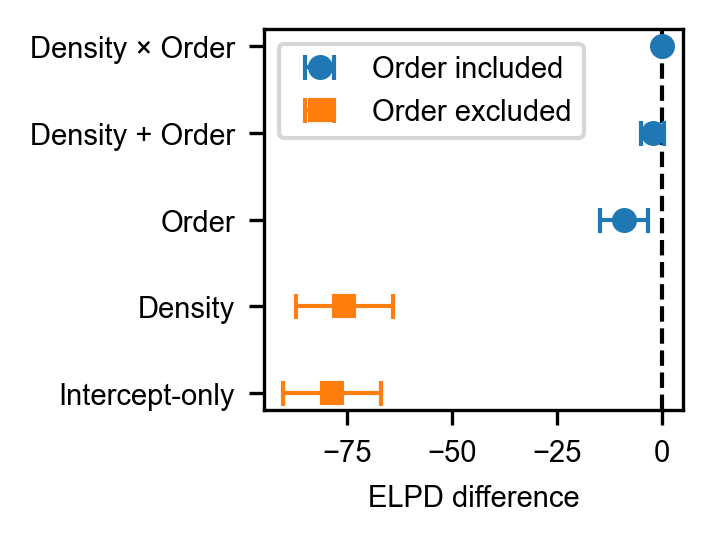

    pretty_name        elpd  delta_elpd  se_delta_elpd  pareto_k_max      best_model
Density × Order -590.667657    0.000000       0.000000      0.287320 Density × Order
Density + Order -592.910828   -2.243171       2.654880      0.217270 Density × Order
          Order -599.760660   -9.093003       5.747258      0.242104 Density × Order
        Density -666.410289  -75.742632      11.605621      0.106757 Density × Order
 Intercept-only -669.276441  -78.608784      11.645056      0.079849 Density × Order


In [75]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

RES_PATH = "mu_kappa_matched_model_sweep_pointwise_delta.parquet"
res_df = pd.read_parquet(RES_PATH)

def wrap_label(s, width=40):
    return textwrap.fill(str(s), width=width)

def _as_list(x):
    if x is None:
        return []
    if isinstance(x, (list, tuple)):
        return list(x)
    if isinstance(x, np.ndarray):
        return x.ravel().tolist()
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            if isinstance(v, np.ndarray):
                return v.ravel().tolist()
            if isinstance(v, (list, tuple)):
                return list(v)
        except Exception:
            return [x]
        return [x]
    try:
        if pd.isna(x):
            return []
    except Exception:
        pass
    return [str(x)]

res_df["has_order"] = res_df["terms"].apply(lambda t: any("t_order" in s for s in _as_list(t)))

# already sorted best-first in sweep, but keep safe:
res_df = res_df.sort_values("delta_elpd", ascending=False).reset_index(drop=True)

y = np.arange(len(res_df))
y_labels = [wrap_label(n, 40) for n in res_df["pretty_name"]]

g_incl = res_df[res_df["has_order"]].copy()
g_excl = res_df[~res_df["has_order"]].copy()
g_incl["y"] = g_incl.index.to_numpy()
g_excl["y"] = g_excl.index.to_numpy()

use_se = "se_delta_elpd" in res_df.columns and (not res_df["se_delta_elpd"].isna().all())

plt.figure(figsize=(1.8, 0.33 * len(res_df)), dpi=300)

if use_se:
    plt.errorbar(g_incl["delta_elpd"], g_incl["y"], xerr=g_incl["se_delta_elpd"],
                 fmt="o", capsize=3, elinewidth=1, markersize=5, label="Order included")
    plt.errorbar(g_excl["delta_elpd"], g_excl["y"], xerr=g_excl["se_delta_elpd"],
                 fmt="s", capsize=3, elinewidth=1, markersize=5, label="Order excluded")
else:
    plt.plot(g_incl["delta_elpd"], g_incl["y"], "o", label="Order included")
    plt.plot(g_excl["delta_elpd"], g_excl["y"], "s", label="Order excluded")

plt.axvline(0.0, linestyle="--", linewidth=1, color="k", zorder=0)
plt.yticks(y, y_labels)
plt.gca().invert_yaxis()
plt.xlabel("ELPD difference")
plt.legend(loc="upper left", frameon=True)
# plt.tight_layout()
plt.savefig("../figures/order_density_model_selection.pdf", dpi=300, bbox_inches="tight")
plt.show()

print(res_df[["pretty_name", "elpd", "delta_elpd", "se_delta_elpd", "pareto_k_max", "best_model"]].to_string(index=False))


In [24]:
# import ast
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import textwrap

# # ---------- load ----------
# RES_PATH = "kappa_only_model_sweep_results.parquet"
# res_df = pd.read_parquet(RES_PATH)

# # Backward compatibility
# if "pretty_name" not in res_df.columns and "name" in res_df.columns:
#     res_df = res_df.rename(columns={"name": "pretty_name"})

# # ---------- helpers ----------
# def _as_list(x):
#     """Coerce stored kappa_terms into a Python list."""
#     if x is None:
#         return []
#     if isinstance(x, (list, tuple)):
#         return list(x)
#     if isinstance(x, np.ndarray):
#         return x.ravel().tolist()
#     if isinstance(x, str):
#         # try parsing a stringified list first
#         try:
#             v = ast.literal_eval(x)
#             if isinstance(v, np.ndarray):
#                 return v.ravel().tolist()
#             if isinstance(v, (list, tuple)):
#                 return list(v)
#         except Exception:
#             pass
#         # fallback: treat string as a single token
#         return [x]
#     try:
#         if pd.isna(x):
#             return []
#     except Exception:
#         pass
#     return [str(x)]

# def _has_order_from_terms(terms):
#     terms = _as_list(terms)
#     return any(("t_order" in t) for t in terms if t != "1")

# def _has_order_from_name(name):
#     return isinstance(name, str) and ("order" in name.lower())

# # Determine grouping (prefer explicit kappa_terms)
# if "kappa_terms" in res_df.columns:
#     res_df["has_order"] = res_df["kappa_terms"].apply(_has_order_from_terms)
# else:
#     res_df["has_order"] = res_df["pretty_name"].apply(_has_order_from_name)

# # ---------- sort + ΔELPD ----------
# res_df = res_df.sort_values("elpd", ascending=False).reset_index(drop=True)
# best_elpd = float(res_df["elpd"].iloc[0])
# res_df["delta_elpd"] = res_df["elpd"] - best_elpd

# use_se = ("se" in res_df.columns) and (not res_df["se"].isna().all())

# # ---------- labels ----------
# def wrap_label(s, width=40):
#     return textwrap.fill(str(s), width=width)

# y = np.arange(len(res_df))
# y_labels = [wrap_label(n, width=40) for n in res_df["pretty_name"]]

# # ---------- split groups ----------
# g_incl = res_df[res_df["has_order"]].copy()
# g_excl = res_df[~res_df["has_order"]].copy()

# # keep y positions consistent with the global sorted table
# g_incl["y"] = g_incl.index.to_numpy()
# g_excl["y"] = g_excl.index.to_numpy()

# # ---------- plot ----------
# plt.figure(figsize=(4, 0.5 * len(res_df)), dpi=300)

# # Order included
# if use_se:
#     plt.errorbar(
#         g_incl["delta_elpd"], g_incl["y"],
#         xerr=g_incl["se"],
#         fmt="o", capsize=3, elinewidth=1, markersize=6,
#         label="Order included"
#     )
# else:
#     plt.plot(g_incl["delta_elpd"], g_incl["y"], "o", label="Order included")

# # Order excluded
# if use_se:
#     plt.errorbar(
#         g_excl["delta_elpd"], g_excl["y"],
#         xerr=g_excl["se"],
#         fmt="s", capsize=3, elinewidth=1, markersize=5,
#         label="Order excluded"
#     )
# else:
#     plt.plot(g_excl["delta_elpd"], g_excl["y"], "s", label="Order excluded")

# plt.axvline(0.0, linestyle="--", linewidth=1)
# plt.yticks(y, y_labels)
# plt.gca().invert_yaxis()
# plt.xlabel("ΔELPD vs best (PSIS-LOO)")
# plt.legend(loc="upper left", frameon=True)
# plt.tight_layout()
# plt.show()


In [25]:
# from math import pi
# import numpy as np
# import pandas as pd
# import bambi as bmb
# import pymc as pm

# # Links & priors from unwrap (as in your example)
# from unwrap.prior import CircularUniformPrior
# from unwrap.link.bambi import circular_modulo, softplus
# from unwrap.link import inverse_softplus
# from pymc.distributions.transforms import LogExpM1 as Softplus

# # ----------------------------
# # Transform helpers (your defs)
# # ----------------------------
# def normalize(x):
#     return (x * 2.0) - 1.0

# def log2_scale(x, min_size=1., max_size=64.):
#     return np.log2(x / min_size) / np.log2(max_size / min_size)

# def inv_log2_scale(x, min_size=1., max_size=64.):
#     inv = x * np.log2(max_size / min_size)
#     inv = 2**inv
#     inv *= min_size
#     return inv

# def inv_normalize(x):
#     return (x - 1.0) / 2.0

# def exp_scale(x, min_size=1., max_size=64.):
#     return (x - min_size) / (max_size - min_size)

# # ----------------------------
# # Build modeling table
# # ----------------------------
# # >>> subsample per individual <<<

# n_samples_per_id = 20      # set the cap you want (or None to disable)
# rng_seed = 42              # for reproducibility
# if n_samples_per_id is not None:
#     df = (
#         merged_df
#         .groupby("animal_id", group_keys=False, observed=True)
#         .apply(
#             lambda g: g.sample(
#                 n=min(n_samples_per_id, len(g)),
#                 replace=False,
#                 random_state=rng_seed
#             ),
#             include_groups=True,
#         )
#         .reset_index()                 # animal_id comes back as an index -> column
#         .rename(columns={"index": "row_id"})  # optional, if you want to keep the old index
#     )
# else:
#     df = merged_df.copy()

# print(f"num_samples: {df.shape[0]}")

# # Ensure categorical id
# df["animal_id"] = df["animal_id"].astype("category")

# # Wrap y to (-pi, pi]
# df["y"] = ((df["direction"] + np.pi) % (2 * np.pi)) - np.pi

# # Choose scaling bounds for density (adjust to your experiment if needed)
# DENS_MIN, DENS_MAX = 1.0, 64.0  # <- change these to your actual density range

# # Transform predictors
# df["t_density"] = normalize(log2_scale(df["density"].astype(float), DENS_MIN, DENS_MAX))
# df["t_order"]   = normalize(df["order"].astype(float))

# # ----------------------------
# # Specify the hierarchical model
# # ----------------------------
# formula = bmb.Formula(
#     # "y ~ 1 + (1 | animal_id)",
#     "y ~ t_density * t_order + (1 | animal_id)",
#     "kappa ~ t_density * t_order + (1 | animal_id)"
# )


# priors = {
#     # μ parameters
#     "Intercept": bmb.Prior("VonMises", mu=0.0, kappa=3.0),
#     "t_density": bmb.Prior("Normal", mu=0.0, sigma=0.3),
#     "t_order":   bmb.Prior("Normal", mu=0.0, sigma=0.3),
#     "t_density:t_order": bmb.Prior("Normal", mu=0.0, sigma=0.2),
#     "1|animal_id": bmb.Prior(
#         "VonMises", mu=0.0,
#         kappa=bmb.Prior("Normal", mu=inverse_softplus(30.0), sigma=0.1, transform=Softplus())
#     ),
#     # κ parameters (pre-softplus)
#     "kappa": {
#         "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2.0), sigma=0.5),
#         "t_density": bmb.Prior("Normal", mu=0.0, sigma=0.5),
#         "t_order":   bmb.Prior("Normal", mu=0.0, sigma=0.5),
#         "t_density:t_order": bmb.Prior("Normal", mu=0.0, sigma=0.25),
#         "1|animal_id": bmb.Prior(
#             "Normal", mu=0.0,
#             sigma=bmb.Prior("Normal", mu=inverse_softplus(1.0), sigma=0.25, transform=Softplus())
#         ),
#     },
# }

# model = bmb.Model(
#     formula=formula,
#     data=df,
#     family="vonmises",
#     priors=priors,
#     link={"mu": circular_modulo, "kappa": softplus},
#     center_predictors=True,
#     categorical="animal_id",
#     dropna=True,

# )
# model.build()
# # # Fit
# # # Increase draws/tune as needed; add target_accept=0.9 if you see divergences.
# print(model)
# idata_hierarchical = model.fit(
#     draws=1000, tune=1000, chains=4, cores=4,
#     target_accept=0.9, init="jitter+adapt_diag",
#     idata_kwargs=dict(
#         log_likelihood=True,
#         include_transformed=True,
#     ),
# )

In [26]:
from math import pi
import numpy as np
import pandas as pd
import bambi as bmb
import pymc as pm

# For LOO
import arviz as az
import xarray as xr
from scipy.special import i0e

# Links & priors from unwrap (as in your example)
from unwrap.prior import CircularUniformPrior
from unwrap.link.bambi import circular_modulo, softplus
from unwrap.link import inverse_softplus
from pymc.distributions.transforms import LogExpM1 as Softplus

# ----------------------------
# Transform helpers (your defs)
# ----------------------------
def normalize(x):
    return (x * 2.0) - 1.0

def log2_scale(x, min_size=1.0, max_size=64.0):
    return np.log2(x / min_size) / np.log2(max_size / min_size)

def inv_log2_scale(x, min_size=1.0, max_size=64.0):
    inv = x * np.log2(max_size / min_size)
    inv = 2**inv
    inv *= min_size
    return inv

def inv_normalize(x):
    return (x - 1.0) / 2.0

def exp_scale(x, min_size=1.0, max_size=64.0):
    return (x - min_size) / (max_size - min_size)

# ----------------------------
# Build modeling table
# ----------------------------
n_samples_per_id = None
rng_seed = 123

if n_samples_per_id is not None:
    df = (
        merged_df
        .copy()
        .groupby("animal_id", group_keys=False, observed=True)
        .apply(lambda g: g.sample(
            n=min(n_samples_per_id, len(g)),
            replace=False,
            random_state=rng_seed
        ))
        .reset_index(drop=True)
    )
else:
    df = merged_df.copy()

print(f"num_samples: {df.shape[0]}")

# Ensure categorical id
df["animal_id"] = df["animal_id"].astype("category")

# Wrap y to (-pi, pi]
df["y"] = ((df["direction"] + np.pi) % (2 * np.pi)) - np.pi

# Choose scaling bounds for density (adjust to your experiment if needed)
DENS_MIN, DENS_MAX = 1.0, 64.0

# Transform predictors
df["t_density"] = normalize(log2_scale(df["density"].astype(float), DENS_MIN, DENS_MAX))
df["t_order"]   = normalize(df["order"].astype(float))

# ----------------------------
# Specify the hierarchical model
# ----------------------------
formula = bmb.Formula(
    "y ~ t_density * t_order + (1 | animal_id)",
    "kappa ~ t_density * t_order + (1 | animal_id)",
)

priors = {
    # μ parameters
    "Intercept": bmb.Prior("VonMises", mu=0.0, kappa=3.0),
    "t_density": bmb.Prior("Normal", mu=0.0, sigma=0.5*np.pi),
    "t_order":   bmb.Prior("Normal", mu=0.0, sigma=0.5*np.pi),
    "t_density:t_order": bmb.Prior("Normal", mu=0.0, sigma=0.25*np.pi),

    # μ random intercept
    "1|animal_id": bmb.Prior(
        "VonMises", mu=0.0,
        kappa=bmb.Prior("Normal", mu=inverse_softplus(30.0), sigma=0.1, transform=Softplus())
    ),

    # κ parameters (pre-softplus)
    "kappa": {
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2.0), sigma=0.5),
        "t_density": bmb.Prior("Normal", mu=0.0, sigma=0.6),
        "t_order":   bmb.Prior("Normal", mu=0.0, sigma=0.6),
        "t_density:t_order": bmb.Prior("Normal", mu=0.0, sigma=0.4),

        # κ random intercept
        "1|animal_id": bmb.Prior(
            "Normal", mu=0.0,
            sigma=bmb.Prior("Normal", mu=inverse_softplus(1.0), sigma=0.3, transform=Softplus())
        ),
    },
}

model = bmb.Model(
    formula=formula,
    data=df,
    family="vonmises",
    priors=priors,
    link={"mu": circular_modulo, "kappa": softplus},
    center_predictors=True,
    categorical="animal_id",
    dropna=True,
)
model.build()

print(model)

# ----------------------------
# Fit WITHOUT PyMC's automatic log_likelihood (it breaks w/ transformed RV names)
# ----------------------------
# Optional: seed numpy for any downstream randomness you might add
np.random.seed(rng_seed)

idata_hierarchical = model.fit(
    draws=1000, tune=2000, chains=4, cores=4,
    target_accept=0.9,
    init="jitter+adapt_diag",
    random_seed=rng_seed,
    idata_kwargs=dict(
        log_likelihood=False,
        include_transformed=True,
    ),
)

# ----------------------------
# Add pointwise log-likelihood manually for elpd_loo
# ----------------------------
# Get posterior draws of response params at each observation
preds = model.predict(idata_hierarchical, kind="response_params", inplace=False)

# These should exist for vonmises with your links
mu    = preds.posterior["mu"]     # dims: (chain, draw, __obs__ or similar)
kappa = preds.posterior["kappa"]  # dims: (chain, draw, __obs__ or similar)

# Find the observation dimension name used by bambi/preds
obs_dim = [d for d in mu.dims if d not in ("chain", "draw")][0]

# Observed y aligned to that obs dimension
y = xr.DataArray(
    df["y"].to_numpy(),
    dims=[obs_dim],
    coords={obs_dim: mu.coords[obs_dim]},
)

# von Mises logpdf: k*cos(y-mu) - log(2π) - log(I0(k))
# stable log(I0(k)) using i0e: I0(k) = i0e(k)*exp(k)
logI0 = np.log(i0e(kappa)) + kappa
loglik = kappa * np.cos(y - mu) - np.log(2 * np.pi) - logI0

# Attach to idata in the ArviZ-standard location
idata_hierarchical.add_groups({"log_likelihood": xr.Dataset({"y": loglik})})

# ----------------------------
# Example: LOO / elpd_loo
# ----------------------------
loo = az.loo(idata_hierarchical, var_name="y")
print(loo)


num_samples: 18641
       Formula: y ~ t_density * t_order + (1 | animal_id)
                kappa ~ t_density * t_order + (1 | animal_id)
        Family: vonmises
          Link: mu = circular_modulo
                kappa = softplus
  Observations: 18641
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ VonMises(mu: 0.0, kappa: 3.0)
            t_density ~ Normal(mu: 0.0, sigma: 1.5708)
            t_order ~ Normal(mu: 0.0, sigma: 1.5708)
            t_density:t_order ~ Normal(mu: 0.0, sigma: 0.7854)
        
        Group-level effects
            1|animal_id ~ VonMises(mu: 0.0, kappa: Normal(mu: 30.0, sigma: 0.1, transform: log_exp_m1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 0.5)
            kappa_t_density ~ Normal(mu: 0.0, sigma: 0.6)
            kappa_t_order ~ Normal(mu: 0.0, sigma: 0.6)
            kappa_t_density:t_order ~ Normal(mu: 0.0, sigma: 0.4)
        
        Group-leve

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, t_density, t_order, t_density:t_order, 1|animal_id_kappa_log_exp, 1|animal_id, kappa_Intercept, kappa_t_density, kappa_t_order, kappa_t_density:t_order, kappa_1|animal_id_sigma_log_exp, kappa_1|animal_id_offset]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 746 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/home/jake/.local/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 18641 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -23672.15   116.38
p_loo      548.93        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)     18566   99.6%
   (0.70, 1]   (bad)         41    0.2%
   (1, Inf)   (very bad)    34    0.2%



In [42]:
loo = az.loo(idata_hierarchical, var_name="y")
p_eff = float(loo.p_loo)
N = 18641
print("p_loo (effective params):", p_eff)
print("N / p_loo:", N / p_eff)


/home/jake/.local/lib/python3.10/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


p_loo (effective params): 548.9301104189544
N / p_loo: 33.95878572915743


In [46]:
print("fraction k>0.7:", np.mean(loo.pareto_k.values > 0.7))

fraction k>0.7: 0.0040233893031489725


In [27]:
import arviz as az
summary_df = az.summary(idata_hierarchical, circ_var_names=["Intercept", "1|animal_id"])

In [28]:
summary_df

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|animal_id[0]           0.000  0.189  -0.333    0.372      0.002    0.004   
1|animal_id[1]           0.012  0.181  -0.303    0.379      0.003    0.003   
1|animal_id[2]          -0.382  0.156  -0.673   -0.096      0.001    0.003   
1|animal_id[3]          -0.290  0.176  -0.595    0.054      0.001    0.003   
1|animal_id[4]           0.145  0.225  -0.274    0.571      0.003    0.004   
...                        ...    ...     ...      ...        ...      ...   
kappa_t_density:t_order  0.469  0.224   0.037    0.883      0.007    0.004   
kappa_t_order            2.535  0.167   2.236    2.862      0.006    0.003   
t_density                0.101  0.032   0.042    0.163      0.001    0.001   
t_density:t_order        0.045  0.046  -0.048    0.125      0.002    0.001   
t_order                 -0.139  0.031  -0.196   -0.080      0.001    0.001   

                         ess_bulk  ess_tail  r_hat  
1|animal_id[0]             9090.0    2667.0   1.00  
1|animal_id[1]             8270.0    2946.0   1.00  
1|animal_id[2]             4936.0    2915.0   1.00  
1|animal_id[3]             4886.0    2962.0   1.00  
1|animal_id[4]             5077.0    2729.0   1.00  
...                           ...       ...    ...  
kappa_t_density:t_order     966.0    1773.0   1.01  
kappa_t_order               725.0    1676.0   1.00  
t_density                   929.0    1972.0   1.00  
t_density:t_order           715.0    1352.0   1.00  
t_order                     751.0    1491.0   1.00  

[890 rows x 9 columns]

In [29]:
summary_df[(summary_df["ess_bulk"]<400) | (summary_df["ess_tail"]<400)]

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|animal_id[154]        0.039  1.196  -0.347   -3.104      0.574    0.568   
kappa_1|animal_id[154] -2.718  3.238  -6.272    3.273      1.557    0.839   

                        ess_bulk  ess_tail  r_hat  
1|animal_id[154]            27.0      28.0   1.53  
kappa_1|animal_id[154]       7.0      29.0   1.53

In [30]:
summary_df[(summary_df["r_hat"]>1.01)]

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|animal_id[154]        0.039  1.196  -0.347   -3.104      0.574    0.568   
kappa_1|animal_id[154] -2.718  3.238  -6.272    3.273      1.557    0.839   

                        ess_bulk  ess_tail  r_hat  
1|animal_id[154]            27.0      28.0   1.53  
kappa_1|animal_id[154]       7.0      29.0   1.53

In [31]:
# az.plot_trace(idata_hierarchical, var_names=["Intercept", "t_order", "t_density", "t_density:t_order"])
# plt.tight_layout();

In [32]:
# az.plot_trace(idata_hierarchical, var_names=["1|animal_id_kappa", "kappa_Intercept", "kappa_t_order", "kappa_t_density", "kappa_t_density:t_order"])
# plt.tight_layout();

In [33]:
# az.plot_posterior(idata_hierarchical, var_names=["1|animal_id_kappa", "kappa_Intercept", "kappa_t_order", "kappa_t_density", "kappa_t_density:t_order", "kappa_1|animal_id_sigma"]);
# az.plot_posterior(idata_hierarchical, var_names=["Intercept", "1|animal_id"], circular=True);

In [34]:
# az.plot_posterior(idata_hierarchical, var_names=["kappa_1|animal_id"]);


In [35]:
# # --- Predict directional alignment = A(kappa) * cos(mu) and replicate two panels ---
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import arviz as az
# from scipy.special import i0, i1  # A(kappa) = I1/I0

# # same transforms you used in the model
# from math import pi
# def normalize(x): return x * 2.0 - 1.0
# def log2_scale(x, min_size=1., max_size=64.):
#     return np.log2(x / min_size) / np.log2(max_size / min_size)

# DENS_MIN, DENS_MAX = 1.0, 64.0  # match training bounds

# def softplus(x):
#     # numerically stable softplus
#     return np.log1p(np.exp(x))

# def circular_modulo(x):
#     # wrap to (-pi, pi]
#     return (x + np.pi) % (2 * np.pi) - np.pi

# def A_of_kappa(kappa):
#     return i1(kappa) / i0(kappa)

# def posterior_linpred(idata, prefix, X_df):
#     """
#     Build linear predictor from posterior samples for parameter set `prefix`.
#     prefix == "" for mu terms (e.g., 'Intercept', 't_density', ...).
#     prefix == "kappa_" for kappa terms (e.g., 'kappa_Intercept', ...).
#     Returns array shape (S, n_rows).
#     """
#     post = idata.posterior
#     # collect relevant coef names
#     if prefix:
#         coefs = [v for v in post.data_vars if v.startswith(prefix)]
#         key_intercept = f"{prefix}Intercept"
#     else:
#         # mu coefs are the base names (no prefix)
#         coefs = [v for v in post.data_vars if (not v.startswith("kappa_"))]
#         key_intercept = "Intercept"

#     if key_intercept not in post:
#         raise ValueError(f"Intercept for prefix '{prefix}' not found in posterior.")

#     def flat(name):
#         return post[name].stack(sample=("chain", "draw")).values  # (S,)
#     S = post.sizes["chain"] * post.sizes["draw"]

#     n = len(X_df)
#     eta = np.tile(flat(key_intercept)[:, None], (1, n))  # (S, n)

#     for coef in coefs:
#         if coef == key_intercept:
#             continue
#         col = coef.replace(prefix, "")  # strip prefix for kappa
#         if col in X_df.columns:
#             eta += flat(coef)[:, None] * X_df[col].to_numpy()[None, :]

#     return eta  # (S, n)

# # Build design matrices for both μ and κ submodels you fit:
# # μ: y ~ t_density + t_order + t_density:t_order
# # κ: kappa ~ t_density + t_order   (add interaction here if you included it)
# def make_X(order_vals, density_vals, idata):
#     X = pd.DataFrame({"order": order_vals, "density": density_vals})
#     X["t_order"]   = normalize(X["order"].astype(float))
#     X["t_density"] = normalize(log2_scale(X["density"].astype(float), DENS_MIN, DENS_MAX))
#     # include interaction column if present in posterior for either submodel
#     if ("t_density:t_order" in idata.posterior.data_vars or
#         "kappa_t_density:t_order" in idata.posterior.data_vars):
#         X["t_density:t_order"] = X["t_density"] * X["t_order"]
#     return X

# def posterior_alignment(idata, X):
#     """
#     Returns dict of posterior summaries for alignment = A(kappa) * cos(mu).
#     """
#     # Linear predictors
#     eta_mu    = posterior_linpred(idata, prefix="",       X_df=X)  # (S, n)
#     eta_kappa = posterior_linpred(idata, prefix="kappa_", X_df=X)  # (S, n)

#     # Links
#     mu    = circular_modulo(eta_mu)     # (-pi, pi]
#     kappa = softplus(eta_kappa)         # > 0

#     # Alignment = mean resultant length * cos(mu - h); here h = 0
#     A = A_of_kappa(kappa)               # (S, n)
#     align = A * np.cos(mu)              # (S, n)

#     mean = align.mean(axis=0)
#     hdi68 = az.hdi(align, hdi_prob=0.68, skipna=True)  # shape (n, 2)
#     return {"mean": mean, "low": hdi68[:, 0], "high": hdi68[:, 1]}

# # ---- prediction grids ----
# dens_levels  = np.sort(merged_df["density"].unique())
# order_levels = np.sort(merged_df["order"].unique())
# order_grid   = np.linspace(order_levels.min(), order_levels.max(), 50)
# density_grid = np.geomspace(max(dens_levels.min(), 1e-6), dens_levels.max(), 50)

# # Panel (i): vs Order, colored by Density
# pred_i = {}
# for d in dens_levels:
#     X = make_X(order_grid, np.full_like(order_grid, d, dtype=float), idata_hierarchical)
#     # keep only cols that appear in posterior names
#     keep_cols = ["t_order", "t_density"] + ([ "t_density:t_order" ] if "t_density:t_order" in X.columns else [])
#     pred_i[d] = posterior_alignment(idata_hierarchical, X[keep_cols])

# # Panel (ii): vs Density, colored by Order
# pred_ii = {}
# for o in order_levels:
#     X = make_X(np.full_like(density_grid, o, dtype=float), density_grid, idata_hierarchical)
#     keep_cols = ["t_order", "t_density"] + ([ "t_density:t_order" ] if "t_density:t_order" in X.columns else [])
#     pred_ii[o] = posterior_alignment(idata_hierarchical, X[keep_cols])

# # ---- plot with legends (same style) ----
# plt.rcParams.update({
#     "font.size": 8, "ytick.major.width": 1, "xtick.major.width": 1,
#     "axes.linewidth": 1, "font.family": "Arial"
# })

# fig, axs = plt.subplots(1, 2, figsize=(6.2, 2.2), dpi=300)
# ax1, ax2 = axs

# cmap_density = plt.cm.Reds     # for density series (panel i)
# cmap_order   = plt.cm.Purples  # for order series (panel ii)

# # Panel i: Alignment vs Order (colored by Density)
# colors_d = np.linspace(0.3, 0.95, len(dens_levels))
# h_i, l_i = [], []
# for i, d in enumerate(dens_levels):
#     col = cmap_density(colors_d[i])
#     y = pred_i[d]["mean"]; lo = pred_i[d]["low"]; hi = pred_i[d]["high"]
#     line, = ax1.plot(order_grid, y, color=col, lw=1.5)
#     ax1.fill_between(order_grid, lo, hi, color=col, alpha=0.25, linewidth=0)
#     h_i.append(line); l_i.append(f"{d:g}")
# ax1.set_xlabel("Order"); ax1.set_ylabel("Directional alignment")
# ax1.set_xlim(order_grid.min(), order_grid.max())
# ax1.set_yticks([-0.5, 0.0, 0.5, 1.0]); ax1.set_ylim(-0.05, 1.05) 
# ax1.legend(h_i, l_i, title="Density", loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

# # Panel ii: Alignment vs Density (colored by Order)
# colors_o = np.linspace(0.3, 0.95, len(order_levels))
# h_ii, l_ii = [], []
# for i, o in enumerate(order_levels):
#     col = cmap_order(colors_o[i])
#     y = pred_ii[o]["mean"]; lo = pred_ii[o]["low"]; hi = pred_ii[o]["high"]
#     line, = ax2.plot(density_grid, y, color=col, lw=1.5)
#     ax2.fill_between(density_grid, lo, hi, color=col, alpha=0.25, linewidth=0)
#     h_ii.append(line); l_ii.append(f"{o:.1f}" if (o % 1) else f"{int(o)}")
# ax2.set_xscale("log", base=2)
# ax2.set_xlabel("Density"); ax2.set_xlim(density_grid.min(), density_grid.max())
# ax2.set_xticks([1, 2, 4, 8, 16, 32, 64])
# ax2.set_xticklabels([1, 2, 4, 8, 16, 32, 64])
# ax2.set_yticks([-0.5, 0.0, 0.5, 1.0]); ax2.set_ylim(-0.05, 1.05)
# ax2.legend(h_ii, l_ii, title="Order", loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

# fig.tight_layout()
# plt.show()


/tmp/ipykernel_539555/3874013992.py:143: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(align, hdi_prob=0.9, skipna=True)
/tmp/ipykernel_539555/3874013992.py:143: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(align, hdi_prob=0.9, skipna=True)
/tmp/ipykernel_539555/3874013992.py:143: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(align, hdi_prob=0.9, skipna=True)
/tmp/ipykernel_539555/3874013992.py:143: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(align, hdi_prob=0.9, skipna=True)
/tmp/ipy

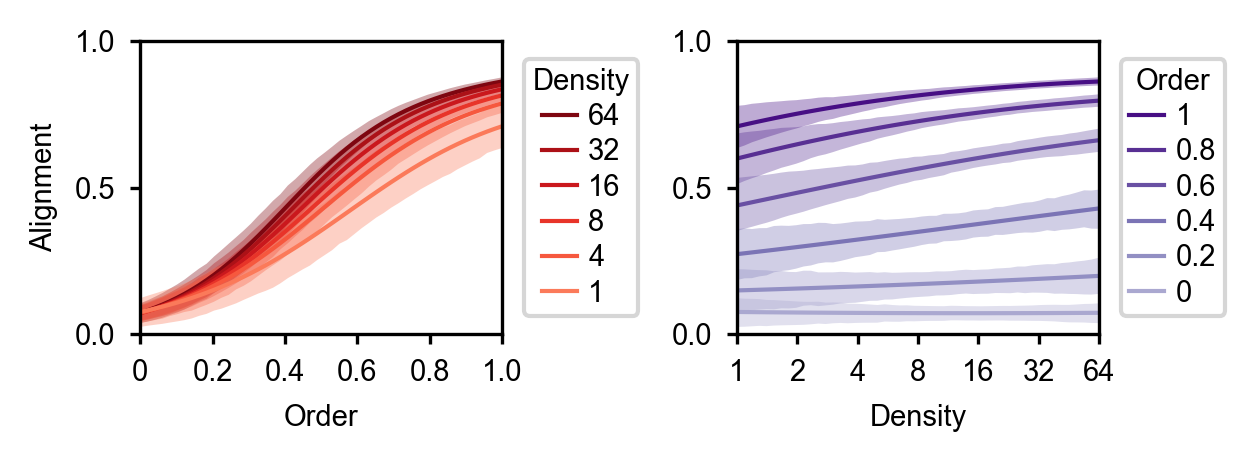

In [186]:
# ============================================================
# Plot 3 — Predicted alignment = A(kappa) * cos(mu)
# Two panels; width matches the 2-subplot figure, height set to look nice.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az
from scipy.special import i0, i1

# ----------------------------
# Style
# ----------------------------
DPI = 300
AX_LW     = 0.8
TICK_LW   = 0.8
TICK_LEN  = 2.5
LINE_LW   = 1.0
FONT_SIZE = 7

mpl.rcParams.update({
    "font.size": FONT_SIZE,
    "axes.labelsize": FONT_SIZE,
    "axes.titlesize": FONT_SIZE,
    "legend.fontsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,

    "axes.linewidth": AX_LW,
    "lines.linewidth": LINE_LW,

    "xtick.major.width": TICK_LW,
    "ytick.major.width": TICK_LW,
    "xtick.major.size": TICK_LEN,
    "ytick.major.size": TICK_LEN,

    "savefig.dpi": DPI,
    "figure.dpi": DPI,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

def _style_axis(ax):
    for s in ax.spines.values():
        s.set_linewidth(AX_LW)

# ----------------------------
# transforms
# ----------------------------
def normalize(x): 
    return x * 2.0 - 1.0

def log2_scale(x, min_size=1., max_size=64.):
    return np.log2(x / min_size) / np.log2(max_size / min_size)

DENS_MIN, DENS_MAX = 1.0, 64.0

def softplus(x):
    x = np.asarray(x)
    return np.where(x > 20, x, np.log1p(np.exp(x)))

def circular_modulo(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def A_of_kappa(kappa):
    return i1(kappa) / i0(kappa)

def posterior_linpred(idata, prefix, X_df):
    post = idata.posterior

    if prefix:
        coefs = [v for v in post.data_vars if v.startswith(prefix)]
        key_intercept = f"{prefix}Intercept"
    else:
        coefs = [v for v in post.data_vars if (not v.startswith("kappa_"))]
        key_intercept = "Intercept"

    if key_intercept not in post:
        raise ValueError(f"Intercept for prefix '{prefix}' not found in posterior.")

    def flat(name):
        return post[name].stack(sample=("chain", "draw")).values

    n = len(X_df)
    eta = flat(key_intercept)[:, None] * np.ones((1, n), dtype=float)

    for coef in coefs:
        if coef == key_intercept:
            continue
        col = coef.replace(prefix, "")
        if col in X_df.columns:
            eta += flat(coef)[:, None] * X_df[col].to_numpy()[None, :]

    return eta

def _compute_training_means(merged_df):
    t_order = normalize(merged_df["order"].astype(float).to_numpy())
    t_density = normalize(
        log2_scale(merged_df["density"].astype(float).to_numpy(), DENS_MIN, DENS_MAX)
    )
    return {"t_order": np.mean(t_order), "t_density": np.mean(t_density)}

TRAIN_MEANS = _compute_training_means(merged_df)

def make_X(order_vals, density_vals, idata, center_predictors=True, interaction_from_centered=True):
    X = pd.DataFrame({"order": order_vals, "density": density_vals})
    X["t_order"]   = normalize(X["order"].astype(float))
    X["t_density"] = normalize(log2_scale(X["density"].astype(float), DENS_MIN, DENS_MAX))

    if center_predictors:
        X["t_order"]   = X["t_order"]   - TRAIN_MEANS["t_order"]
        X["t_density"] = X["t_density"] - TRAIN_MEANS["t_density"]

    has_interaction = (
        ("t_density:t_order" in idata.posterior.data_vars) or
        ("kappa_t_density:t_order" in idata.posterior.data_vars)
    )
    if has_interaction:
        if interaction_from_centered:
            X["t_density:t_order"] = X["t_density"] * X["t_order"]
        else:
            X_raw_order   = normalize(pd.Series(order_vals).astype(float))
            X_raw_density = normalize(
                log2_scale(pd.Series(density_vals).astype(float), DENS_MIN, DENS_MAX)
            )
            X["t_density:t_order"] = np.asarray(X_raw_density) * np.asarray(X_raw_order)

    return X

def posterior_alignment(idata, X):
    eta_mu    = posterior_linpred(idata, prefix="",       X_df=X)
    eta_kappa = posterior_linpred(idata, prefix="kappa_", X_df=X)

    mu    = circular_modulo(eta_mu)
    kappa = softplus(eta_kappa)

    A = A_of_kappa(kappa)
    align = A * np.cos(mu)

    mean = align.mean(axis=0)
    hdi = az.hdi(align, hdi_prob=0.9, skipna=True)
    return {"mean": mean, "low": hdi[:, 0], "high": hdi[:, 1]}

# -----------------------------
# prediction grids
# -----------------------------
# DESCENDING so legends list largest -> smallest
dens_levels  = np.sort(merged_df["density"].unique())[::-1]
order_levels = np.sort(merged_df["order"].unique())[::-1]

order_grid   = np.linspace(order_levels.min(), order_levels.max(), 50)
density_grid = np.geomspace(max(dens_levels.min(), 1e-6), dens_levels.max(), 50)

pred_i = {}
for d in dens_levels:
    X = make_X(
        order_grid,
        np.full_like(order_grid, d, dtype=float),
        idata_hierarchical,
        center_predictors=True,
        interaction_from_centered=True,
    )
    keep_cols = ["t_order", "t_density"] + (["t_density:t_order"] if "t_density:t_order" in X.columns else [])
    pred_i[d] = posterior_alignment(idata_hierarchical, X[keep_cols])

pred_ii = {}
for o in order_levels:
    X = make_X(
        np.full_like(density_grid, o, dtype=float),
        density_grid,
        idata_hierarchical,
        center_predictors=True,
        interaction_from_centered=True,
    )
    keep_cols = ["t_order", "t_density"] + (["t_density:t_order"] if "t_density:t_order" in X.columns else [])
    pred_ii[o] = posterior_alignment(idata_hierarchical, X[keep_cols])

# -----------------------------
# plot sizing
# -----------------------------
FIG_W = 1.8 * 2 + 0.6
FIG_H = 1.55

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(FIG_W, FIG_H), dpi=DPI)

cmap_density = plt.cm.Reds
cmap_order   = plt.cm.Purples

FILL_ALPHA = 0.35
CMAP_MIN, CMAP_MAX = 0.45, 0.95

# Panel i (density legend: high -> low; keep high darker)
colors_d = np.linspace(CMAP_MAX, CMAP_MIN, len(dens_levels))
h_i, l_i = [], []
for i, d in enumerate(dens_levels):
    col = cmap_density(colors_d[i])
    y  = pred_i[d]["mean"]
    lo = pred_i[d]["low"]
    hi = pred_i[d]["high"]

    ax1.fill_between(order_grid, lo, hi, color=col, alpha=FILL_ALPHA, edgecolor="none", zorder=1)
    line, = ax1.plot(order_grid, y, color=col, lw=LINE_LW, zorder=2)
    h_i.append(line); l_i.append(f"{d:g}")

ax1.set_xlabel("Order")
ax1.set_ylabel("Alignment")
ax1.set_xlim(order_grid.min(), order_grid.max())
ax1.set_ylim(-0.0, 1.0)
ax1.set_yticks([0.0, 0.5, 1.0])

# >>> requested order ticks <<<
ax1.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"])

_style_axis(ax1)
ax1.legend(
    h_i, l_i, title="Density",
    loc="center left", bbox_to_anchor=(1.02, 0.5),
    frameon=True, handlelength=1.2, borderpad=0.3,
    labelspacing=0.25, handletextpad=0.4
)

# Panel ii (order legend: high -> low; keep high darker)
colors_o = np.linspace(CMAP_MAX, CMAP_MIN, len(order_levels))
h_ii, l_ii = [], []
for i, o in enumerate(order_levels):
    col = cmap_order(colors_o[i])
    y  = pred_ii[o]["mean"]
    lo = pred_ii[o]["low"]
    hi = pred_ii[o]["high"]

    ax2.fill_between(density_grid, lo, hi, color=col, alpha=FILL_ALPHA, edgecolor="none", zorder=1)
    line, = ax2.plot(density_grid, y, color=col, lw=LINE_LW, zorder=2)
    h_ii.append(line)
    l_ii.append(f"{o:.1f}" if (o % 1) else f"{int(o)}")

ax2.set_xscale("log", base=2)
ax2.set_xlabel("Density")
ax2.set_xlim(density_grid.min(), density_grid.max())
ax2.set_xticks([1, 2, 4, 8, 16, 32, 64])
ax2.set_xticklabels([1, 2, 4, 8, 16, 32, 64])
ax2.set_yticks([0.0, 0.5, 1.0])
ax2.set_ylim(-0.0, 1.0)
_style_axis(ax2)
ax2.legend(
    h_ii, l_ii, title="Order",
    loc="center left", bbox_to_anchor=(1.02, 0.5),
    frameon=True, handlelength=1.2, borderpad=0.3,
    labelspacing=0.25, handletextpad=0.4
)

fig.tight_layout()
fig.savefig("../figures/order_density_alignment.pdf", dpi=DPI, bbox_inches="tight", pad_inches=0.01)
plt.show()


/tmp/ipykernel_539555/1765491952.py:152: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_log  = az.hdi(logp0, hdi_prob=hdi_prob, skipna=True)
/tmp/ipykernel_539555/1765491952.py:152: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_log  = az.hdi(logp0, hdi_prob=hdi_prob, skipna=True)
/tmp/ipykernel_539555/1765491952.py:152: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_log  = az.hdi(logp0, hdi_prob=hdi_prob, skipna=True)
/tmp/ipykernel_539555/1765491952.py:152: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_log  = az.hdi(logp0, 

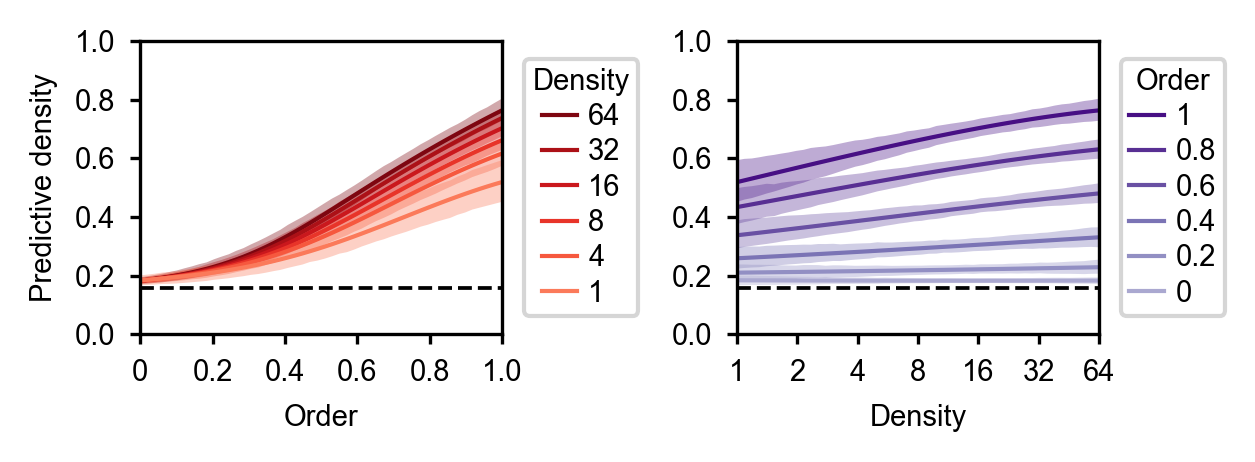

In [289]:
# ============================================================
# Plot 3 (ELPD@0) — Predictive density at y=0
# Two panels (Order | Density)
#
# CHANGE REQUESTED:
#   - compute posterior mean + HDI in *log space*, then exp() for plotting
#   - y-axis label: "Predictive density"
#   - y-lims: 0 to 1
#   - dashed uniform reference at density = 1/(2*pi)
#   - keep Arial + transparent backgrounds
# ============================================================

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import vonmises

# ----------------------------
# Style
# ----------------------------
DPI = 300
AX_LW     = 0.8
TICK_LW   = 0.8
TICK_LEN  = 2.5
LINE_LW   = 1.0
FONT_SIZE = 7

mpl.rcParams.update({
    "font.family": "Arial",
    "font.size": FONT_SIZE,
    "axes.labelsize": FONT_SIZE,
    "axes.titlesize": FONT_SIZE,
    "legend.fontsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,

    "axes.linewidth": AX_LW,
    "lines.linewidth": LINE_LW,

    "xtick.major.width": TICK_LW,
    "ytick.major.width": TICK_LW,
    "xtick.major.size": TICK_LEN,
    "ytick.major.size": TICK_LEN,

    "savefig.dpi": DPI,
    "figure.dpi": DPI,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

def _style_axis(ax):
    for s in ax.spines.values():
        s.set_linewidth(AX_LW)

# ----------------------------
# transforms / helpers
# ----------------------------
def normalize(x):
    return x * 2.0 - 1.0

def log2_scale(x, min_size=1., max_size=64.):
    return np.log2(x / min_size) / np.log2(max_size / min_size)

DENS_MIN, DENS_MAX = 1.0, 64.0

def softplus(x):
    x = np.asarray(x)
    return np.where(x > 20, x, np.log1p(np.exp(x)))

def circular_modulo(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def posterior_linpred(idata, prefix, X_df):
    post = idata.posterior

    if prefix:
        coefs = [v for v in post.data_vars if v.startswith(prefix)]
        key_intercept = f"{prefix}Intercept"
    else:
        coefs = [v for v in post.data_vars if (not v.startswith("kappa_"))]
        key_intercept = "Intercept"

    if key_intercept not in post:
        raise ValueError(f"Intercept for prefix '{prefix}' not found in posterior.")

    def flat(name):
        return post[name].stack(sample=("chain", "draw")).values

    n = len(X_df)
    eta = flat(key_intercept)[:, None] * np.ones((1, n), dtype=float)

    for coef in coefs:
        if coef == key_intercept:
            continue
        col = coef.replace(prefix, "")
        if col in X_df.columns:
            eta += flat(coef)[:, None] * X_df[col].to_numpy()[None, :]

    return eta

def _compute_training_means(merged_df):
    t_order = normalize(merged_df["order"].astype(float).to_numpy())
    t_density = normalize(
        log2_scale(merged_df["density"].astype(float).to_numpy(), DENS_MIN, DENS_MAX)
    )
    return {"t_order": np.mean(t_order), "t_density": np.mean(t_density)}

TRAIN_MEANS = _compute_training_means(merged_df)

def make_X(order_vals, density_vals, idata, center_predictors=True, interaction_from_centered=True):
    X = pd.DataFrame({"order": order_vals, "density": density_vals})
    X["t_order"]   = normalize(X["order"].astype(float))
    X["t_density"] = normalize(log2_scale(X["density"].astype(float), DENS_MIN, DENS_MAX))

    if center_predictors:
        X["t_order"]   = X["t_order"]   - TRAIN_MEANS["t_order"]
        X["t_density"] = X["t_density"] - TRAIN_MEANS["t_density"]

    has_interaction = (
        ("t_density:t_order" in idata.posterior.data_vars) or
        ("kappa_t_density:t_order" in idata.posterior.data_vars)
    )
    if has_interaction:
        if interaction_from_centered:
            X["t_density:t_order"] = X["t_density"] * X["t_order"]
        else:
            X_raw_order   = normalize(pd.Series(order_vals).astype(float))
            X_raw_density = normalize(
                log2_scale(pd.Series(density_vals).astype(float), DENS_MIN, DENS_MAX)
            )
            X["t_density:t_order"] = np.asarray(X_raw_density) * np.asarray(X_raw_order)

    return X

# ----------------------------
# posterior predictive density at y=0 (compute in log, plot in exp(log))
# ----------------------------
def posterior_elpd0(idata, X, hdi_prob=0.9):
    eta_mu    = posterior_linpred(idata, prefix="",       X_df=X)
    eta_kappa = posterior_linpred(idata, prefix="kappa_", X_df=X)

    mu    = circular_modulo(eta_mu)
    kappa = softplus(eta_kappa)

    # log predictive density at y=0 for each posterior draw
    logp0 = vonmises.logpdf(0.0, kappa, loc=mu)  # (S, n_points)

    # mean and HDI in log space
    mean_log = np.mean(logp0, axis=0)
    hdi_log  = az.hdi(logp0, hdi_prob=hdi_prob, skipna=True)

    # exponentiate for plotting
    return {
        "mean": np.exp(mean_log),
        "low":  np.exp(hdi_log[:, 0]),
        "high": np.exp(hdi_log[:, 1]),
        "mean_log": mean_log,     # kept in case you want it later
        "low_log":  hdi_log[:, 0],
        "high_log": hdi_log[:, 1],
    }

# -----------------------------
# prediction grids
# -----------------------------
dens_levels  = np.sort(merged_df["density"].unique())[::-1]
order_levels = np.sort(merged_df["order"].unique())[::-1]

order_grid   = np.linspace(order_levels.min(), order_levels.max(), 50)
density_grid = np.geomspace(max(dens_levels.min(), 1e-6), dens_levels.max(), 50)

pred_i = {}
for d in dens_levels:
    X = make_X(
        order_grid,
        np.full_like(order_grid, d, dtype=float),
        idata_hierarchical,
        center_predictors=True,
        interaction_from_centered=True,
    )
    keep_cols = ["t_order", "t_density"] + (["t_density:t_order"] if "t_density:t_order" in X.columns else [])
    pred_i[d] = posterior_elpd0(idata_hierarchical, X[keep_cols], hdi_prob=0.9)

pred_ii = {}
for o in order_levels:
    X = make_X(
        np.full_like(density_grid, o, dtype=float),
        density_grid,
        idata_hierarchical,
        center_predictors=True,
        interaction_from_centered=True,
    )
    keep_cols = ["t_order", "t_density"] + (["t_density:t_order"] if "t_density:t_order" in X.columns else [])
    pred_ii[o] = posterior_elpd0(idata_hierarchical, X[keep_cols], hdi_prob=0.9)

# -----------------------------
# plot sizing
# -----------------------------
FIG_W = 1.8 * 2 + 0.6
FIG_H = 1.55

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(FIG_W, FIG_H), dpi=DPI)

# Transparent backgrounds
fig.patch.set_facecolor("none")
fig.patch.set_alpha(0)
for ax in (ax1, ax2):
    ax.set_facecolor("none")
    ax.patch.set_facecolor("none")
    ax.patch.set_alpha(0)

cmap_density = plt.cm.Reds
cmap_order   = plt.cm.Purples

FILL_ALPHA = 0.35
CMAP_MIN, CMAP_MAX = 0.45, 0.95

# Uniform reference in density space
p_uniform = 1.0 / (2.0 * np.pi)

# Panel i (vary order, colored by density levels)
colors_d = np.linspace(CMAP_MAX, CMAP_MIN, len(dens_levels))
h_i, l_i = [], []
for i, d in enumerate(dens_levels):
    col = cmap_density(colors_d[i])
    y  = pred_i[d]["mean"]
    lo = pred_i[d]["low"]
    hi = pred_i[d]["high"]

    ax1.fill_between(order_grid, lo, hi, color=col, alpha=FILL_ALPHA, edgecolor="none", zorder=1)
    line, = ax1.plot(order_grid, y, color=col, lw=LINE_LW, zorder=2)
    h_i.append(line); l_i.append(f"{d:g}")

ax1.set_xlabel("Order")
ax1.set_ylabel("Predictive density")
ax1.set_xlim(order_grid.min(), order_grid.max())

ax1.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_xticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1.0"])

# dashed uniform reference
ax1.axhline(p_uniform, ls="--", color="k", lw=0.9, zorder=0)

_style_axis(ax1)
ax1.legend(
    h_i, l_i, title="Density",
    loc="center left", bbox_to_anchor=(1.02, 0.5),
    frameon=True, handlelength=1.2, borderpad=0.3,
    labelspacing=0.25, handletextpad=0.4
)

# Panel ii (vary density, colored by order levels)
colors_o = np.linspace(CMAP_MAX, CMAP_MIN, len(order_levels))
h_ii, l_ii = [], []
for i, o in enumerate(order_levels):
    col = cmap_order(colors_o[i])
    y  = pred_ii[o]["mean"]
    lo = pred_ii[o]["low"]
    hi = pred_ii[o]["high"]

    ax2.fill_between(density_grid, lo, hi, color=col, alpha=FILL_ALPHA, edgecolor="none", zorder=1)
    line, = ax2.plot(density_grid, y, color=col, lw=LINE_LW, zorder=2)
    h_ii.append(line)
    l_ii.append(f"{o:.1f}" if (o % 1) else f"{int(o)}")

ax2.set_xscale("log", base=2)
ax2.set_xlabel("Density")
ax2.set_xlim(density_grid.min(), density_grid.max())
ax2.set_xticks([1, 2, 4, 8, 16, 32, 64])
ax2.set_xticklabels([1, 2, 4, 8, 16, 32, 64])

# dashed uniform reference
ax2.axhline(p_uniform, ls="--", color="k", lw=0.9, zorder=0)

_style_axis(ax2)
ax2.legend(
    h_ii, l_ii, title="Order",
    loc="center left", bbox_to_anchor=(1.02, 0.5),
    frameon=True, handlelength=1.2, borderpad=0.3,
    labelspacing=0.25, handletextpad=0.4
)

# Fixed y-limits as requested
ax1.set_ylim(0.0, 1.0)
ax2.set_ylim(0.0, 1.0)

fig.tight_layout()
fig.savefig(
    "../figures/order_density_elpd0.pdf",
    dpi=DPI, bbox_inches="tight", pad_inches=0.01,
    transparent=True
)
plt.show()


/tmp/ipykernel_539555/1030258134.py:142: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(pdfs, hdi_prob=hdi_prob, skipna=True)  # (T, 2)
/tmp/ipykernel_539555/1030258134.py:142: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(pdfs, hdi_prob=hdi_prob, skipna=True)  # (T, 2)
/tmp/ipykernel_539555/1030258134.py:142: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(pdfs, hdi_prob=hdi_prob, skipna=True)  # (T, 2)
/tmp/ipykernel_539555/1030258134.py:142: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = az.hdi(

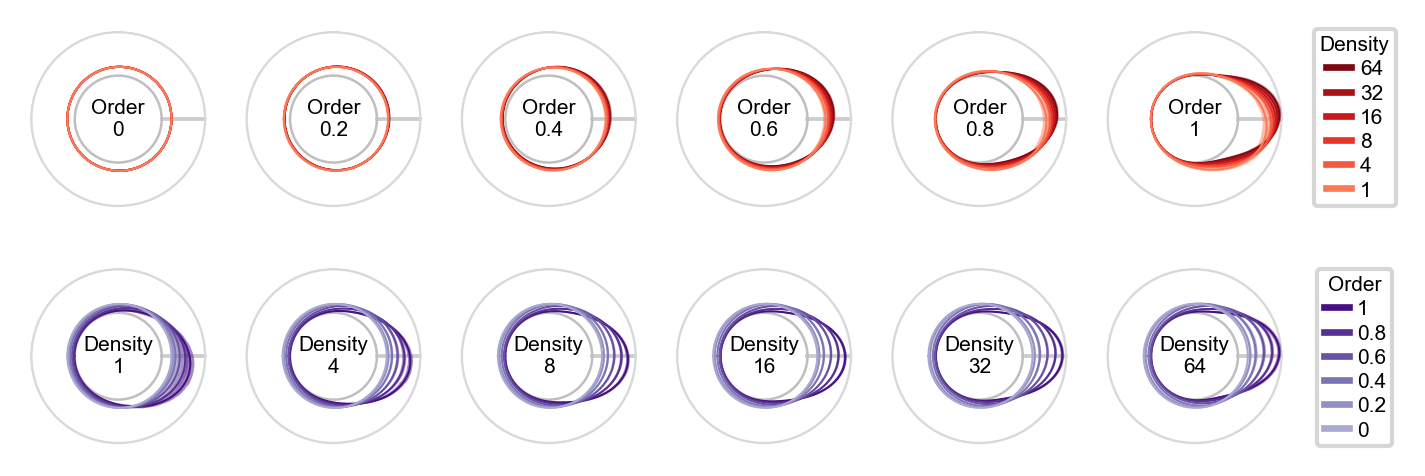

In [341]:
"""
2 rows of POLAR small-multiples with *multiple* von Mises predictive PDFs per panel.

Row 1 (columns = each ORDER level):
    within each panel: sweep DENSITY levels (colored by Reds, like your ELPD plot)

Row 2 (columns = each DENSITY level):
    within each panel: sweep ORDER levels (colored by Purples, like your ELPD plot)

Each curve shows:
  - median posterior predictive PDF (line)
  - 90% HDI band for the PDF (fill)   <-- now clearly visible
  - “HDI bars” as arcs on the inner ring: 90% interval for posterior μ (circular)

ASSUMES you already have from your ELPD code:
  - merged_df
  - idata_hierarchical
  - make_X(...)
  - posterior_linpred(...)
  - softplus(...)
  - circular_modulo(...)
"""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

# ----------------------------
# Style (match your existing)
# ----------------------------
DPI = 300
AX_LW     = 0.8
TICK_LW   = 0.8
TICK_LEN  = 2.5
LINE_LW   = 0.5
FONT_SIZE = 5

mpl.rcParams.update({
    "font.size": FONT_SIZE,
    "axes.labelsize": FONT_SIZE,
    "axes.titlesize": FONT_SIZE,
    "legend.fontsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,

    "font.family": "Arial",
    "svg.fonttype": "none",

    "axes.linewidth": AX_LW,
    "lines.linewidth": LINE_LW,

    "xtick.major.width": TICK_LW,
    "ytick.major.width": TICK_LW,
    "xtick.major.size":  TICK_LEN,
    "ytick.major.size":  TICK_LEN,

    "savefig.dpi": DPI,
    "figure.dpi": DPI,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# ----------------------------
# Knobs
# ----------------------------
HDI_PROB      = 0.90
MAX_DRAWS     = 1200      # subsample posterior draws for speed
EDGE_RADIUS   = 1.0
AMP           = 1.0       # radial amplitude after normalization

BAND_ALPHA    = 1.0      # <-- more visible HDI bands
ARC_LW        = 1
ARC_BASE      = EDGE_RADIUS - 0.05
ARC_STEP      = 0.028     # arcs step inward per curve so they don't overlap
OUTER_LW      = 0.6

CMAP_MIN, CMAP_MAX = 0.45, 0.95
cmap_density = plt.cm.Reds
cmap_order   = plt.cm.Purples

# ----------------------------
# von Mises pdf (no SciPy)
# ----------------------------
def vonmises_pdf(theta, mu, kappa):
    return np.exp(kappa * np.cos(theta - mu)) / (2 * np.pi * np.i0(kappa))

def angle_wrap(x):
    return (x + np.pi) % (2*np.pi) - np.pi

def circular_mean(mu_draws):
    return np.angle(np.mean(np.exp(1j * mu_draws)))

def mu_interval_central(mu_draws, prob=0.9):
    """Practical circular 'HDI-like' interval: unwrap around circular mean then take central interval."""
    mu0 = circular_mean(mu_draws)
    d   = np.angle(np.exp(1j * (mu_draws - mu0)))  # deltas in (-pi, pi]
    a = (1 - prob) / 2 * 100
    b = (1 + prob) / 2 * 100
    lo_d, hi_d = np.percentile(d, [a, b])
    lo = angle_wrap(mu0 + lo_d)
    hi = angle_wrap(mu0 + hi_d)
    return mu0, lo, hi

def _subsample_draws(mu, kappa, max_draws, rng):
    S = mu.shape[0]
    if S <= max_draws:
        return mu, kappa
    idx = rng.choice(S, size=max_draws, replace=False)
    return mu[idx], kappa[idx]

def posterior_mu_kappa_at(idata, order_val, density_val):
    X = make_X(
        np.array([order_val], dtype=float),
        np.array([density_val], dtype=float),
        idata,
        center_predictors=True,
        interaction_from_centered=True,
    )
    keep_cols = ["t_order", "t_density"] + (["t_density:t_order"] if "t_density:t_order" in X.columns else [])
    X = X[keep_cols]

    eta_mu    = posterior_linpred(idata, prefix="",       X_df=X)      # (S, 1)
    eta_kappa = posterior_linpred(idata, prefix="kappa_", X_df=X)      # (S, 1)

    mu    = circular_modulo(eta_mu[:, 0])
    kappa = softplus(eta_kappa[:, 0])
    return mu, kappa

def posterior_pdf_summary(idata, order_val, density_val, theta_grid, hdi_prob=0.9, max_draws=1200, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    mu, kappa = posterior_mu_kappa_at(idata, order_val, density_val)
    mu, kappa = _subsample_draws(mu, kappa, max_draws, rng)

    pdfs = vonmises_pdf(theta_grid[None, :], mu[:, None], kappa[:, None])  # (S, T)

    med = np.median(pdfs, axis=0)
    hdi = az.hdi(pdfs, hdi_prob=hdi_prob, skipna=True)  # (T, 2)
    lo, hi = hdi[:, 0], hdi[:, 1]

    mu0, mu_lo, mu_hi = mu_interval_central(mu, prob=hdi_prob)
    return dict(med=med, lo=lo, hi=hi, mu0=mu0, mu_lo=mu_lo, mu_hi=mu_hi)

def plot_arc(ax, th_lo, th_hi, r, color, lw):
    """Draw an arc (HDI bar) at radius r from th_lo to th_hi, handling wrap-around."""
    th_lo = angle_wrap(th_lo)
    th_hi = angle_wrap(th_hi)
    if th_lo <= th_hi:
        th = np.linspace(th_lo, th_hi, 200)
        ax.plot(th, np.full_like(th, r), color=color, lw=lw, solid_capstyle="round", zorder=5)
    else:
        th1 = np.linspace(th_lo, np.pi, 140)
        th2 = np.linspace(-np.pi, th_hi, 140)
        ax.plot(th1, np.full_like(th1, r), color=color, lw=lw, solid_capstyle="round", zorder=5)
        ax.plot(th2, np.full_like(th2, r), color=color, lw=lw, solid_capstyle="round", zorder=5)

# --- NEW polar formatting: 0° right, only dashed 0° line, rings only ---
def format_polar(ax):
    ax.set_theta_zero_location("E")  # 0° at right
    ax.set_theta_direction(1)        # CCW positive
    ax.spines["polar"].set_visible(False)

    # no angle ticks/labels, no crosshair grid
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.grid(False)

    # no radial tick labels
    ax.set_yticks([])
    ax.set_yticklabels([])

    # dashed stimulus line at 0°
    ax.plot([0, 0], [EDGE_RADIUS, RMAX], color="0.80", lw=0.9, ls="-", zorder=0)

    # radial rings (baseline + max)
    ax.add_artist(Circle((0, 0), EDGE_RADIUS,       transform=ax.transData._b,
                         color="0.75", fill=False, linewidth=OUTER_LW))
    ax.add_artist(Circle((0, 0), EDGE_RADIUS + AMP, transform=ax.transData._b,
                         color="0.85", fill=False, linewidth=OUTER_LW))

# ----------------------------
# Levels (use your actual unique levels)
# ----------------------------
dens_levels  = np.sort(merged_df["density"].unique())[::-1]
order_levels = np.sort(merged_df["order"].unique())[::-1]

# ----------------------------
# Angle grid + precompute summaries for all combos
# ----------------------------
rng = np.random.default_rng(123)
theta = np.linspace(-np.pi, np.pi, 900, endpoint=False)

dens_pos  = np.linspace(CMAP_MAX, CMAP_MIN, len(dens_levels))
order_pos = np.linspace(CMAP_MAX, CMAP_MIN, len(order_levels))
dens_colors  = {d: cmap_density(dens_pos[i]) for i, d in enumerate(dens_levels)}
order_colors = {o: cmap_order(order_pos[i])  for i, o in enumerate(order_levels)}

summ = {}
peak_max = 0.0
for o in order_levels:
    for d in dens_levels:
        res = posterior_pdf_summary(
            idata_hierarchical, float(o), float(d),
            theta_grid=theta,
            hdi_prob=HDI_PROB,
            max_draws=MAX_DRAWS,
            rng=rng
        )
        summ[(float(o), float(d))] = res
        peak_max = max(peak_max, res["hi"].max())

def to_r(y):
    return EDGE_RADIUS + AMP * (y / (peak_max + 1e-12))

RMAX = EDGE_RADIUS + AMP * 1.03

# ----------------------------
# Figure layout: 2 rows of polar panels
# ----------------------------
n1 = len(order_levels)
n2 = len(dens_levels)
ncol = max(n1, n2)

PANEL_W = 0.8
FIG_H   = 2.0
fig, axes = plt.subplots(
    2, ncol,
    figsize=(PANEL_W * ncol, FIG_H),
    dpi=DPI,
    subplot_kw={"projection": "polar"},
    squeeze=True
)

for j in range(ncol):
    if j >= n1:
        axes[0, j].axis("off")
    if j >= n2:
        axes[1, j].axis("off")



# ----------------------------
# Row 1: panels = ORDER; curves = DENSITY (Reds)
#   Bands = PDF HDI90 (outlined band, no alpha)
# ----------------------------
for j, o in enumerate(order_levels[::-1]):
    ax = axes[0, j]
    format_polar(ax)
    ax.set_ylim(0, RMAX)

    # draw bands first (so medians are always visible on top)
    for i, d in enumerate(dens_levels):
        col = dens_colors[d]
        res = summ[(float(o), float(d))]

        # 90% HDI band for PDF
        ax.fill_between(
            theta,
            to_r(res["lo"]),
            to_r(res["hi"]),
            facecolor=col,
            edgecolor="none",
            zorder=1,
            alpha=0.5,
        )

    # median lines on top
    for i, d in enumerate(dens_levels):
        col = dens_colors[d]
        res = summ[(float(o), float(d))]
        ax.plot(theta, to_r(res["med"]), color=col, lw=LINE_LW, zorder=3)

    # centered label (instead of title)
    ax.text(
        0.5, 0.5, f"Order\n{float(o):g}",
        ha="center", va="center",
        fontsize=FONT_SIZE,
        color="k",
        transform=ax.transAxes,
        zorder=10
    )

# ----------------------------
# Row 2: panels = DENSITY; curves = ORDER (Purples)
#   Bands = PDF HDI90 (outlined band, no alpha)
# ----------------------------
for j, d in enumerate(dens_levels[::-1]):
    ax = axes[1, j]
    format_polar(ax)
    ax.set_ylim(0, RMAX)

    for i, o in enumerate(order_levels):
        col = order_colors[o]
        res = summ[(float(o), float(d))]

        ax.fill_between(
            theta,
            to_r(res["lo"]),
            to_r(res["hi"]),
            facecolor=col,
            edgecolor="none",
            zorder=1,
            alpha=0.5
        )

    for i, o in enumerate(order_levels):
        col = order_colors[o]
        res = summ[(float(o), float(d))]
        ax.plot(theta, to_r(res["med"]), color=col, lw=LINE_LW, zorder=3)

    ax.text(
        0.5, 0.5, f"Density\n{float(d):g}",
        ha="center", va="center",
        fontsize=FONT_SIZE,
        color="k",
        transform=ax.transAxes,
        zorder=10
    )

# ----------------------------
# Legends (one for density, one for order) using the SAME palettes as ELPD
# ----------------------------
dens_handles = [Line2D([0], [0], color=dens_colors[d], lw=1.6) for d in dens_levels]
dens_labels  = [f"{d:g}" for d in dens_levels]
order_handles = [Line2D([0], [0], color=order_colors[o], lw=1.6) for o in order_levels]
order_labels  = [f"{o:g}" for o in order_levels]

fig.subplots_adjust(left=0.03, right=0.90, top=0.92, bottom=0.06, wspace=0.22, hspace=-0.15)

fig.legend(dens_handles, dens_labels, title="Density",
           loc="center", bbox_to_anchor=(0.95, 0.69),
           frameon=True, handlelength=1.2, borderpad=0.3,
           labelspacing=0.25, handletextpad=0.4)

fig.legend(order_handles, order_labels, title="Order",
           loc="center", bbox_to_anchor=(0.95, 0.29),
           frameon=True, handlelength=1.2, borderpad=0.3,
           labelspacing=0.25, handletextpad=0.4)


fig.savefig("../figures/order_density_polar_pdfs_grid.svg", format="svg")
fig.savefig("../figures/order_density_polar_pdfs_grid.pdf", bbox_inches="tight")

plt.show()


/tmp/ipykernel_539555/2783145956.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10 = mpl.cm.get_cmap("tab10")


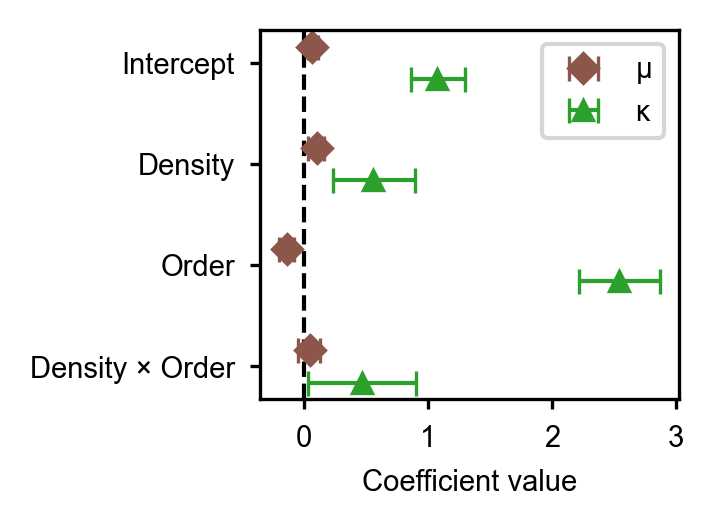

In [114]:
# ============================================================
# Coefficient posteriors (fixed effects only), μ vs κ
# 95% HDI intervals + point estimate (mean)
# ============================================================

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az

post = idata_hierarchical.posterior

TERMS = [
    ("Intercept",        "Intercept",               "kappa_Intercept"),
    ("Density",          "t_density",               "kappa_t_density"),
    ("Order",            "t_order",                 "kappa_t_order"),
    ("Density × Order",  "t_density:t_order",       "kappa_t_density:t_order"),
]

def _stack_1d(varname: str) -> np.ndarray:
    if varname not in post.data_vars:
        raise KeyError(
            f"Missing '{varname}' in idata.posterior. "
            f"Available: {list(post.data_vars)[:30]} ..."
        )
    return post[varname].stack(sample=("chain", "draw")).values.astype(float)

def circular_modulo(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def circular_mean(theta):
    z = np.exp(1j * np.asarray(theta, float))
    return float(circular_modulo(np.angle(z.mean())))

def circular_hdi(theta, hdi_prob=0.95):
    theta = np.asarray(theta, float)
    mu_c = circular_mean(theta)
    centered = circular_modulo(theta - mu_c)
    h = az.hdi(centered, hdi_prob=hdi_prob, skipna=True)
    low_c, high_c = float(h[0]), float(h[1])
    low = float(circular_modulo(low_c + mu_c))
    high = float(circular_modulo(high_c + mu_c))
    return low, high, mu_c

def linear_hdi_mean(x, hdi_prob=0.95):
    x = np.asarray(x, float)
    h = az.hdi(x, hdi_prob=hdi_prob, skipna=True)
    return float(x.mean()), float(h[0]), float(h[1])

rows = []
for pretty, mu_name, k_name in TERMS:
    mu_draws = _stack_1d(mu_name)
    k_draws  = _stack_1d(k_name)

    if mu_name == "Intercept":
        mu_lo, mu_hi, mu_m = circular_hdi(mu_draws, hdi_prob=0.95)
        rows.append(("mu", pretty, float(mu_m), float(mu_lo), float(mu_hi)))
    else:
        mu_m, mu_lo, mu_hi = linear_hdi_mean(mu_draws, hdi_prob=0.95)
        rows.append(("mu", pretty, float(mu_m), float(mu_lo), float(mu_hi)))

    k_m, k_lo, k_hi = linear_hdi_mean(k_draws, hdi_prob=0.95)
    rows.append(("kappa", pretty, float(k_m), float(k_lo), float(k_hi)))

terms_order = [t[0] for t in TERMS]
y_base = np.arange(len(terms_order), dtype=float)

mu_stats = {term: (mean, lo, hi) for (sub, term, mean, lo, hi) in rows if sub == "mu"}
k_stats  = {term: (mean, lo, hi) for (sub, term, mean, lo, hi) in rows if sub == "kappa"}

mu_mean = np.array([mu_stats[t][0] for t in terms_order], float)
mu_lo   = np.array([mu_stats[t][1] for t in terms_order], float)
mu_hi   = np.array([mu_stats[t][2] for t in terms_order], float)

k_mean = np.array([k_stats[t][0] for t in terms_order], float)
k_lo   = np.array([k_stats[t][1] for t in terms_order], float)
k_hi   = np.array([k_stats[t][2] for t in terms_order], float)

def circ_dist(a, b):
    return float(circular_modulo(b - a))

mu_xerr = np.zeros((2, len(terms_order)), float)
for i, term in enumerate(terms_order):
    if term == "Intercept":
        lo_w = abs(circ_dist(mu_lo[i], mu_mean[i]))
        hi_w = abs(circ_dist(mu_mean[i], mu_hi[i]))
        mu_xerr[:, i] = [lo_w, hi_w]
    else:
        mu_xerr[:, i] = [mu_mean[i] - mu_lo[i], mu_hi[i] - mu_mean[i]]

k_xerr = np.vstack([k_mean - k_lo, k_hi - k_mean])

dy = 0.16
y_mu = y_base - dy
y_k  = y_base + dy

tab10 = mpl.cm.get_cmap("tab10")
MU_COLOR = tab10(5)   # brown
K_COLOR  = tab10(2)   # green

plt.figure(figsize=(1.8, 0.4 * 4), dpi=300)

plt.errorbar(
    mu_mean, y_mu, xerr=mu_xerr,
    fmt="D", color=MU_COLOR, ecolor=MU_COLOR,   # diamond
    capsize=3, elinewidth=1, capthick=1,
    markersize=5, markeredgewidth=0.8,
    label="μ"
)
plt.errorbar(
    k_mean, y_k, xerr=k_xerr,
    fmt="^", color=K_COLOR, ecolor=K_COLOR,     # triangle-up
    capsize=3, elinewidth=1, capthick=1,
    markersize=5, markeredgewidth=0.8,
    label="κ"
)

plt.axvline(0.0, linestyle="--", linewidth=1, color="k", zorder=0)

plt.yticks(y_base, terms_order)
plt.gca().invert_yaxis()
plt.xlabel("Coefficient value")
plt.legend(loc="upper right", frameon=True)
plt.savefig("../figures/order_density_coefficients.pdf", dpi=300, bbox_inches="tight", pad_inches=0.01)
plt.show()


/tmp/ipykernel_539555/1506632427.py:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab10 = mpl.cm.get_cmap("tab10")


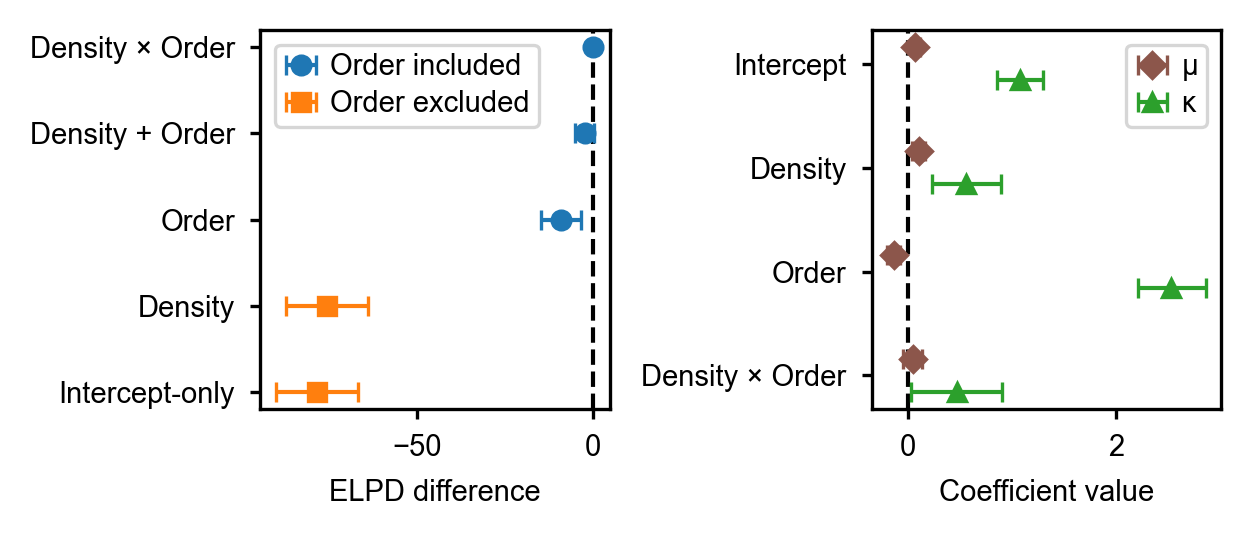

    pretty_name        elpd  delta_elpd  se_delta_elpd  pareto_k_max      best_model
Density × Order -590.667657    0.000000       0.000000      0.287320 Density × Order
Density + Order -592.910828   -2.243171       2.654880      0.217270 Density × Order
          Order -599.760660   -9.093003       5.747258      0.242104 Density × Order
        Density -666.410289  -75.742632      11.605621      0.106757 Density × Order
 Intercept-only -669.276441  -78.608784      11.645056      0.079849 Density × Order


In [287]:
# ============================================================
# Single figure with 2 subplots (SWAPPED):
#   LEFT  = Model comparison (ΔELPD)
#   RIGHT = Model coefficients (μ vs κ)
# ============================================================

import ast
import textwrap
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az

# ----------------------------
# Style
# ----------------------------
DPI = 300
AX_LW     = 0.8
TICK_LW   = 0.8
TICK_LEN  = 2.5
LINE_LW   = 1.0
ERR_LW    = 1.0
CAPSIZE   = 2.5
CAPTHICK  = 1.0
MS        = 4.5
MEW       = 0.8
FONT_SIZE = 7

mpl.rcParams.update({
    "font.size": FONT_SIZE,
    "axes.labelsize": FONT_SIZE,
    "axes.titlesize": FONT_SIZE,
    "legend.fontsize": FONT_SIZE,
    "xtick.labelsize": FONT_SIZE,
    "ytick.labelsize": FONT_SIZE,

    "axes.linewidth": AX_LW,
    "lines.linewidth": LINE_LW,

    "xtick.major.width": TICK_LW,
    "ytick.major.width": TICK_LW,
    "xtick.major.size": TICK_LEN,
    "ytick.major.size": TICK_LEN,

    "savefig.dpi": DPI,
    "figure.dpi": DPI,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

def _style_spines(ax):
    for s in ax.spines.values():
        s.set_linewidth(AX_LW)

def _finish_axis(ax, xlabel, yticks=None, yticklabels=None, legend_loc=None, vline0=True):
    if vline0:
        ax.axvline(0.0, linestyle="--", linewidth=ERR_LW, color="k", zorder=0)

    if yticks is not None:
        ax.set_yticks(yticks)
    if yticklabels is not None:
        ax.set_yticklabels(yticklabels)

    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    _style_spines(ax)

    if legend_loc is not None:
        leg = ax.legend(
            loc=legend_loc, frameon=True,
            handlelength=1.2, borderpad=0.3,
            labelspacing=0.3, handletextpad=0.4
        )
        leg.get_frame().set_linewidth(AX_LW)

tab10 = mpl.cm.get_cmap("tab10")
ELPD_INCL_COLOR = tab10(0)
ELPD_EXCL_COLOR = tab10(1)
MU_COLOR        = tab10(5)  # brown
K_COLOR         = tab10(2)  # green

# ----------------------------
# Model comparison data
# ----------------------------
RES_PATH = "mu_kappa_matched_model_sweep_pointwise_delta.parquet"
res_df = pd.read_parquet(RES_PATH)

def wrap_label(s, width=40):
    return textwrap.fill(str(s), width=width)

def _as_list(x):
    if x is None:
        return []
    if isinstance(x, (list, tuple)):
        return list(x)
    if isinstance(x, np.ndarray):
        return x.ravel().tolist()
    if isinstance(x, str):
        try:
            v = ast.literal_eval(x)
            if isinstance(v, np.ndarray):
                return v.ravel().tolist()
            if isinstance(v, (list, tuple)):
                return list(v)
        except Exception:
            return [x]
        return [x]
    try:
        if pd.isna(x):
            return []
    except Exception:
        pass
    return [str(x)]

res_df["has_order"] = res_df["terms"].apply(lambda t: any("t_order" in s for s in _as_list(t)))
res_df = res_df.sort_values("delta_elpd", ascending=False).reset_index(drop=True)

y_m = np.arange(len(res_df))
y_labels = [wrap_label(n, 40) for n in res_df["pretty_name"]]

g_incl = res_df[res_df["has_order"]].copy()
g_excl = res_df[~res_df["has_order"]].copy()
g_incl["y"] = g_incl.index.to_numpy()
g_excl["y"] = g_excl.index.to_numpy()

use_se = "se_delta_elpd" in res_df.columns and (not res_df["se_delta_elpd"].isna().all())

# ----------------------------
# Coefficient data
# ----------------------------
post = idata_hierarchical.posterior

TERMS = [
    ("Intercept",        "Intercept",               "kappa_Intercept"),
    ("Density",          "t_density",               "kappa_t_density"),
    ("Order",            "t_order",                 "kappa_t_order"),
    ("Density × Order",  "t_density:t_order",       "kappa_t_density:t_order"),
]

def _stack_1d(varname: str) -> np.ndarray:
    if varname not in post.data_vars:
        raise KeyError(
            f"Missing '{varname}' in idata.posterior. "
            f"Available: {list(post.data_vars)[:30]} ..."
        )
    return post[varname].stack(sample=("chain", "draw")).values.astype(float)

def circular_modulo(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def circular_mean(theta):
    z = np.exp(1j * np.asarray(theta, float))
    return float(circular_modulo(np.angle(z.mean())))

def circular_hdi(theta, hdi_prob=0.95):
    theta = np.asarray(theta, float)
    mu_c = circular_mean(theta)
    centered = circular_modulo(theta - mu_c)
    h = az.hdi(centered, hdi_prob=hdi_prob, skipna=True)
    low_c, high_c = float(h[0]), float(h[1])
    low = float(circular_modulo(low_c + mu_c))
    high = float(circular_modulo(high_c + mu_c))
    return low, high, mu_c

def linear_hdi_mean(x, hdi_prob=0.95):
    x = np.asarray(x, float)
    h = az.hdi(x, hdi_prob=hdi_prob, skipna=True)
    return float(x.mean()), float(h[0]), float(h[1])

def circ_dist(a, b):
    return float(circular_modulo(b - a))

rows = []
for pretty, mu_name, k_name in TERMS:
    mu_draws = _stack_1d(mu_name)
    k_draws  = _stack_1d(k_name)

    if mu_name == "Intercept":
        mu_lo, mu_hi, mu_m = circular_hdi(mu_draws, hdi_prob=0.95)
        rows.append(("mu", pretty, float(mu_m), float(mu_lo), float(mu_hi)))
    else:
        mu_m, mu_lo, mu_hi = linear_hdi_mean(mu_draws, hdi_prob=0.95)
        rows.append(("mu", pretty, float(mu_m), float(mu_lo), float(mu_hi)))

    k_m, k_lo, k_hi = linear_hdi_mean(k_draws, hdi_prob=0.95)
    rows.append(("kappa", pretty, float(k_m), float(k_lo), float(k_hi)))

terms_order = [t[0] for t in TERMS]
y_base = np.arange(len(terms_order), dtype=float)

mu_stats = {term: (mean, lo, hi) for (sub, term, mean, lo, hi) in rows if sub == "mu"}
k_stats  = {term: (mean, lo, hi) for (sub, term, mean, lo, hi) in rows if sub == "kappa"}

mu_mean = np.array([mu_stats[t][0] for t in terms_order], float)
mu_lo   = np.array([mu_stats[t][1] for t in terms_order], float)
mu_hi   = np.array([mu_stats[t][2] for t in terms_order], float)

k_mean = np.array([k_stats[t][0] for t in terms_order], float)
k_lo   = np.array([k_stats[t][1] for t in terms_order], float)
k_hi   = np.array([k_stats[t][2] for t in terms_order], float)

mu_xerr = np.zeros((2, len(terms_order)), float)
for i, term in enumerate(terms_order):
    if term == "Intercept":
        lo_w = abs(circ_dist(mu_lo[i], mu_mean[i]))
        hi_w = abs(circ_dist(mu_mean[i], mu_hi[i]))
        mu_xerr[:, i] = [lo_w, hi_w]
    else:
        mu_xerr[:, i] = [mu_mean[i] - mu_lo[i], mu_hi[i] - mu_mean[i]]

k_xerr = np.vstack([k_mean - k_lo, k_hi - k_mean])

dy = 0.16
y_mu = y_base - dy
y_k  = y_base + dy

# ----------------------------
# Draw
# ----------------------------
ROW_H = 0.36
n_rows = max(len(res_df), len(terms_order))
fig_h = ROW_H * n_rows

fig, (ax_elpd, ax_coef) = plt.subplots(
    1, 2,
    figsize=(1.8 * 2 + 0.6, fig_h),
    dpi=DPI
)

if use_se:
    ax_elpd.errorbar(
        g_incl["delta_elpd"], g_incl["y"], xerr=g_incl["se_delta_elpd"],
        fmt="o", color=ELPD_INCL_COLOR, ecolor=ELPD_INCL_COLOR,
        ms=MS, mew=MEW,
        capsize=CAPSIZE, elinewidth=ERR_LW, capthick=CAPTHICK,
        label="Order included"
    )
    ax_elpd.errorbar(
        g_excl["delta_elpd"], g_excl["y"], xerr=g_excl["se_delta_elpd"],
        fmt="s", color=ELPD_EXCL_COLOR, ecolor=ELPD_EXCL_COLOR,
        ms=MS, mew=MEW,
        capsize=CAPSIZE, elinewidth=ERR_LW, capthick=CAPTHICK,
        label="Order excluded"
    )
else:
    ax_elpd.plot(
        g_incl["delta_elpd"], g_incl["y"], "o",
        color=ELPD_INCL_COLOR, ms=MS, mew=MEW, label="Order included"
    )
    ax_elpd.plot(
        g_excl["delta_elpd"], g_excl["y"], "s",
        color=ELPD_EXCL_COLOR, ms=MS, mew=MEW, label="Order excluded"
    )

_finish_axis(
    ax_elpd,
    xlabel="ELPD difference",
    yticks=y_m,
    yticklabels=y_labels,
    legend_loc="upper left",
    vline0=True
)

ax_coef.errorbar(
    mu_mean, y_mu, xerr=mu_xerr,
    fmt="D", color=MU_COLOR, ecolor=MU_COLOR,
    ms=MS, mew=MEW,
    capsize=CAPSIZE, elinewidth=ERR_LW, capthick=CAPTHICK,
    label="μ"
)
ax_coef.errorbar(
    k_mean, y_k, xerr=k_xerr,
    fmt="^", color=K_COLOR, ecolor=K_COLOR,
    ms=MS, mew=MEW,
    capsize=CAPSIZE, elinewidth=ERR_LW, capthick=CAPTHICK,
    label="κ"
)

_finish_axis(
    ax_coef,
    xlabel="Coefficient value",
    yticks=y_base,
    yticklabels=terms_order,
    legend_loc="upper right",
    vline0=True
)

fig.tight_layout()
fig.savefig(
    "../figures/order_density_model_selection_and_coefficients.pdf",
    dpi=DPI, bbox_inches="tight", pad_inches=0.01
)
plt.show()

print(res_df[["pretty_name", "elpd", "delta_elpd", "se_delta_elpd", "pareto_k_max", "best_model"]].to_string(index=False))


/tmp/ipykernel_539555/3297359868.py:180: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi  = az.hdi(align, hdi_prob=hdi_prob, skipna=True)  # (n,2)
/tmp/ipykernel_539555/3297359868.py:180: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi  = az.hdi(align, hdi_prob=hdi_prob, skipna=True)  # (n,2)
/tmp/ipykernel_539555/3297359868.py:180: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi  = az.hdi(align, hdi_prob=hdi_prob, skipna=True)  # (n,2)
/tmp/ipykernel_539555/3297359868.py:180: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi  = az.

Hierarchical bootstrap (cells):   0%|          | 0/36 [00:00<?, ?it/s]

/tmp/ipykernel_539555/3297359868.py:501: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


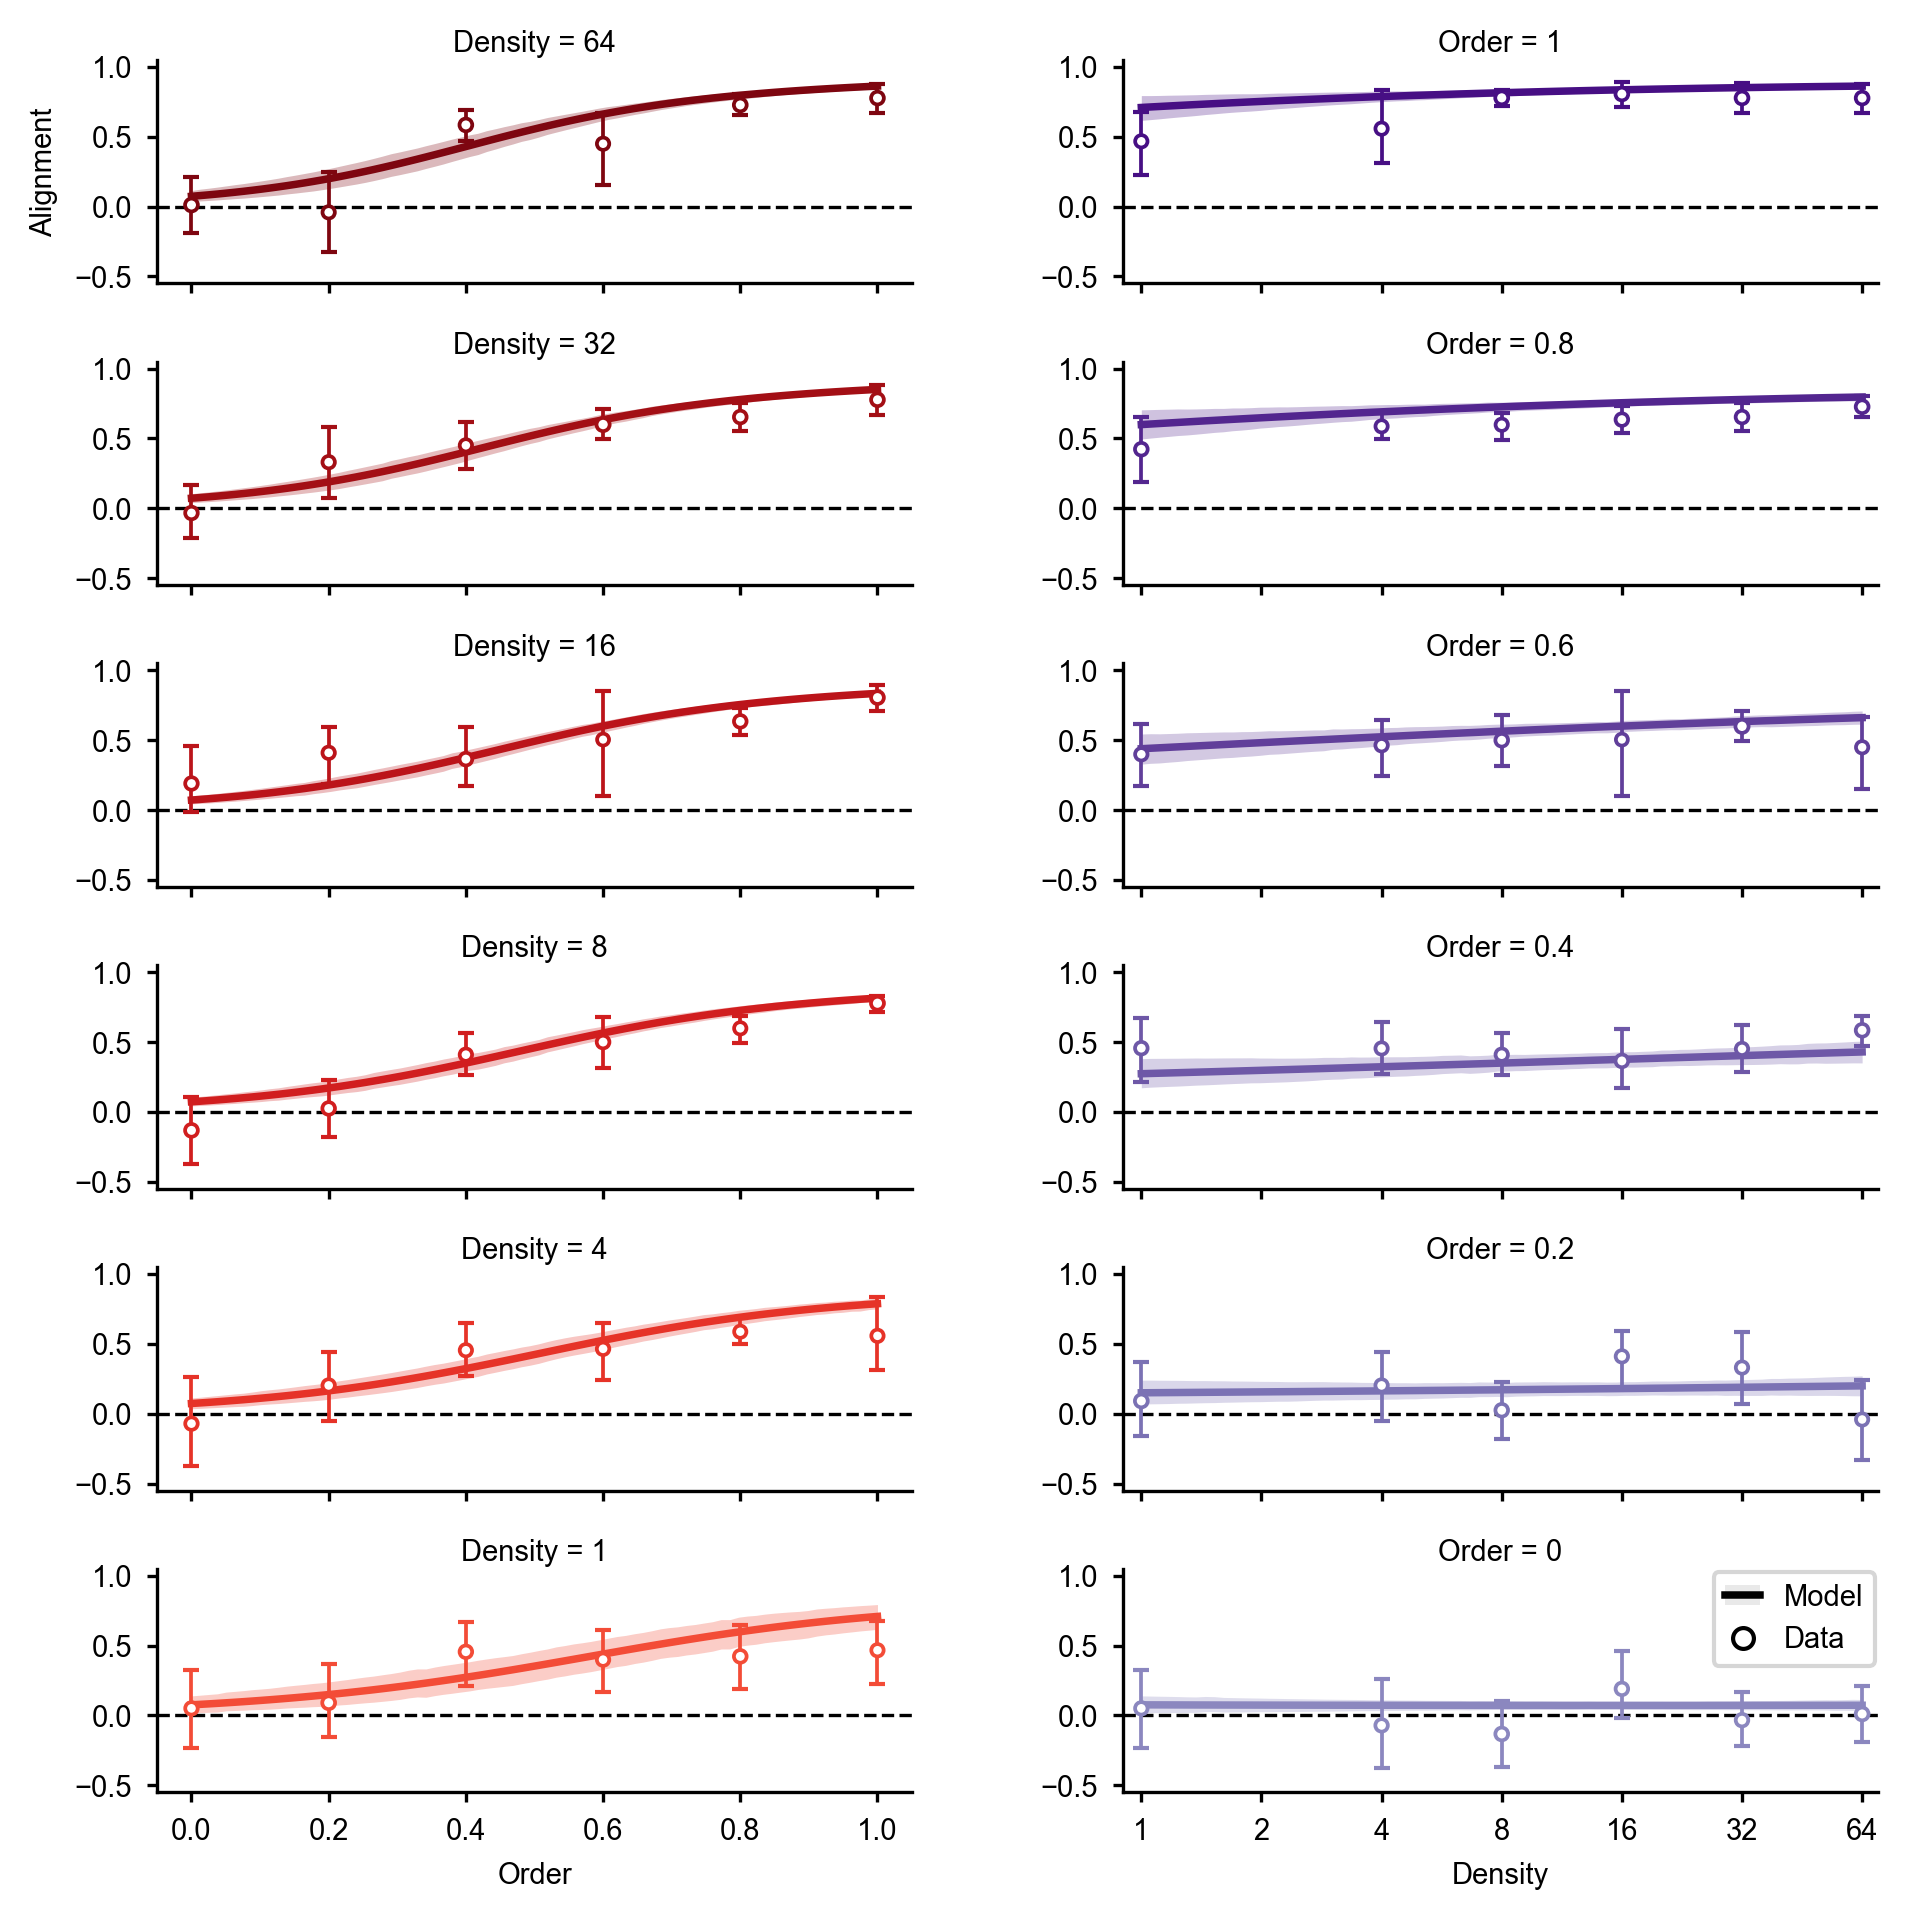

In [181]:
# ============================================================
# FULL UPDATED CODE (SMALL MULTIPLES) — with PDF export
# Each line gets its own subplot + its matching bootstrap points/intervals.
# Layout: 2 columns
#   Left column:  alignment vs Order, one row per Density level
#   Right column: alignment vs Density, one row per Order level
# ============================================================

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az
from scipy.special import i0, i1

from joblib import Parallel, delayed
from tqdm.auto import tqdm
import contextlib
import joblib

from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from matplotlib.legend_handler import HandlerBase


# ----------------------------
# Global style (kept consistent with your other figures)
# ----------------------------
DPI = 300
AX_LW     = 0.8
TICK_LW   = 0.8
TICK_LEN  = 2.5

mpl.rcParams.update({
    "font.size": 7,
    "axes.labelsize": 7,
    "axes.titlesize": 7,
    "legend.fontsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,

    "axes.linewidth": AX_LW,
    "xtick.major.width": TICK_LW,
    "ytick.major.width": TICK_LW,
    "xtick.major.size": TICK_LEN,
    "ytick.major.size": TICK_LEN,

    "savefig.dpi": DPI,
    "figure.dpi": DPI,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})


class HandlerPatchOverLine(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height,
                       fontsize, trans):
        band, line = orig_handle  # (Patch, Line2D)

        r = Rectangle(
            (xdescent, ydescent), width, height,
            facecolor=band.get_facecolor(),
            edgecolor="none",
            alpha=band.get_alpha(),
            transform=trans
        )

        l = Line2D(
            [xdescent, xdescent + width],
            [ydescent + 0.5 * height, ydescent + 0.5 * height],
            color=line.get_color(),
            lw=line.get_linewidth(),
            transform=trans
        )

        return [r, l]


# ----------------------------
# Transforms used in the model
# ----------------------------
def normalize(x):
    return x * 2.0 - 1.0

def log2_scale(x, min_size=1., max_size=64.):
    return np.log2(x / min_size) / np.log2(max_size / min_size)

DENS_MIN, DENS_MAX = 1.0, 64.0

def softplus(x):
    x = np.asarray(x)
    return np.where(x > 20, x, np.log1p(np.exp(x)))

def circular_modulo(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def A_of_kappa(kappa):
    return i1(kappa) / i0(kappa)


# ----------------------------
# Posterior linear predictors
# ----------------------------
def posterior_linpred(idata, prefix, X_df):
    post = idata.posterior

    if prefix:
        coefs = [v for v in post.data_vars if v.startswith(prefix)]
        key_intercept = f"{prefix}Intercept"
    else:
        coefs = [v for v in post.data_vars if (not v.startswith("kappa_"))]
        key_intercept = "Intercept"

    if key_intercept not in post.data_vars:
        raise ValueError(f"Intercept '{key_intercept}' not found in posterior.")

    def flat(name):
        return post[name].stack(sample=("chain", "draw")).values  # (S,)

    n = len(X_df)
    eta = flat(key_intercept)[:, None] * np.ones((1, n), dtype=float)

    for coef in coefs:
        if coef == key_intercept:
            continue
        col = coef.replace(prefix, "")
        if col in X_df.columns:
            eta += flat(coef)[:, None] * X_df[col].to_numpy()[None, :]

    return eta  # (S, n)


# -----------------------------
# Bambi-style centering
# -----------------------------
def _compute_training_means(merged_df):
    t_order = normalize(merged_df["order"].astype(float).to_numpy())
    t_density = normalize(
        log2_scale(merged_df["density"].astype(float).to_numpy(), DENS_MIN, DENS_MAX)
    )
    return {"t_order": np.mean(t_order), "t_density": np.mean(t_density)}

TRAIN_MEANS = _compute_training_means(merged_df)

def make_X(order_vals, density_vals, idata, center_predictors=True, interaction_from_centered=True):
    X = pd.DataFrame({"order": order_vals, "density": density_vals})
    X["t_order"]   = normalize(X["order"].astype(float))
    X["t_density"] = normalize(log2_scale(X["density"].astype(float), DENS_MIN, DENS_MAX))

    if center_predictors:
        X["t_order"]   = X["t_order"]   - TRAIN_MEANS["t_order"]
        X["t_density"] = X["t_density"] - TRAIN_MEANS["t_density"]

    has_interaction = (
        ("t_density:t_order" in idata.posterior.data_vars) or
        ("kappa_t_density:t_order" in idata.posterior.data_vars)
    )
    if has_interaction:
        if interaction_from_centered:
            X["t_density:t_order"] = X["t_density"] * X["t_order"]
        else:
            X_raw_order   = normalize(pd.Series(order_vals).astype(float))
            X_raw_density = normalize(
                log2_scale(pd.Series(density_vals).astype(float), DENS_MIN, DENS_MAX)
            )
            X["t_density:t_order"] = np.asarray(X_raw_density) * np.asarray(X_raw_order)

    return X

def posterior_alignment(idata, X, hdi_prob=0.95):
    eta_mu    = posterior_linpred(idata, prefix="",       X_df=X)
    eta_kappa = posterior_linpred(idata, prefix="kappa_", X_df=X)

    mu    = circular_modulo(eta_mu)
    kappa = softplus(eta_kappa)

    align = A_of_kappa(kappa) * np.cos(mu)  # (S, n)

    mean = align.mean(axis=0)
    hdi  = az.hdi(align, hdi_prob=hdi_prob, skipna=True)  # (n,2)
    return {"mean": mean, "low": hdi[:, 0], "high": hdi[:, 1]}


# ============================================================
# joblib <-> tqdm glue
# ============================================================
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()


# ============================================================
# Empirical hierarchical bootstrap per treatment cell (parallel)
# ============================================================
def hierarchical_bootstrap_cells_parallel(
    df_steps,
    B=1000,
    ci=0.95,
    seed=123,
    n_jobs=-1,
    prefer="threads",
    verbose=0,
):
    rng_master = np.random.default_rng(seed)

    records = []
    for aid, g in df_steps.groupby("animal_id", observed=True):
        dens = float(g["density"].iloc[0])
        ordv = float(g["order"].iloc[0])
        u = np.exp(1j * g["y"].to_numpy())
        records.append({"animal_id": aid, "density": dens, "order": ordv, "u": u})
    animal_tbl = pd.DataFrame(records)

    cell_groups = {}
    for (dens, ordv), sub in animal_tbl.groupby(["density", "order"], observed=True):
        cell_groups[(float(dens), float(ordv))] = sub["animal_id"].to_numpy()

    u_by_animal = dict(zip(animal_tbl["animal_id"], animal_tbl["u"]))

    def _hdi_1d(x, prob):
        h = az.hdi(x, hdi_prob=prob, skipna=True)
        h = np.asarray(h)
        if h.ndim == 2:
            return float(h[0, 0]), float(h[0, 1])
        return float(h[0]), float(h[1])

    def _bootstrap_one_cell(cell_key, animals, cell_seed):
        rng = np.random.default_rng(cell_seed)
        animals = np.asarray(animals)
        nA = len(animals)
        boots = np.empty(B, dtype=float)

        for b in range(B):
            samp_animals = animals[rng.integers(0, nA, size=nA)]
            z_sum = 0.0 + 0.0j

            for aid in samp_animals:
                u = u_by_animal[aid]
                idx = rng.integers(0, len(u), size=len(u))
                z_sum += u[idx].mean()

            boots[b] = np.real(z_sum / nA)

        low, high = _hdi_1d(boots, ci)

        return {
            "density": cell_key[0],
            "order": cell_key[1],
            "n_animals": int(nA),
            "emp_mean": float(boots.mean()),
            "emp_low":  float(low),
            "emp_high": float(high),
        }

    cells = list(cell_groups.items())
    cell_seeds = rng_master.integers(0, 2**32 - 1, size=len(cells), dtype=np.uint32)

    with tqdm_joblib(tqdm(total=len(cells), desc="Hierarchical bootstrap (cells)")):
        out = Parallel(n_jobs=n_jobs, prefer=prefer, verbose=verbose)(
            delayed(_bootstrap_one_cell)(cell_key, animals, int(cell_seeds[i]))
            for i, (cell_key, animals) in enumerate(cells)
        )

    return pd.DataFrame(out)


# ============================================================
# Build grids, compute model predictions, compute bootstrap
# ============================================================
# DESCENDING so subplot rows run largest -> smallest (matching your other figures)
dens_levels  = np.sort(merged_df["density"].unique())[::-1]
order_levels = np.sort(merged_df["order"].unique())[::-1]

order_grid   = np.linspace(order_levels.min(), order_levels.max(), 80)
density_grid = np.geomspace(max(dens_levels.min(), 1e-6), dens_levels.max(), 80)

pred_i = {}
for d in dens_levels:
    X = make_X(
        order_grid,
        np.full_like(order_grid, d, dtype=float),
        idata_hierarchical,
        center_predictors=True,
        interaction_from_centered=True,
    )
    keep_cols = ["t_order", "t_density"] + (["t_density:t_order"] if "t_density:t_order" in X.columns else [])
    pred_i[d] = posterior_alignment(idata_hierarchical, X[keep_cols], hdi_prob=0.95)

pred_ii = {}
for o in order_levels:
    X = make_X(
        np.full_like(density_grid, o, dtype=float),
        density_grid,
        idata_hierarchical,
        center_predictors=True,
        interaction_from_centered=True,
    )
    keep_cols = ["t_order", "t_density"] + (["t_density:t_order"] if "t_density:t_order" in X.columns else [])
    pred_ii[o] = posterior_alignment(idata_hierarchical, X[keep_cols], hdi_prob=0.95)

emp = hierarchical_bootstrap_cells_parallel(
    df,
    B=1000,
    ci=0.95,
    seed=123,
    n_jobs=-1,
    prefer="threads",
)

def emp_for_density(d):
    # keep within-panel x ordering increasing (order 0 -> 1)
    sub = emp.loc[np.isclose(emp["density"], float(d))].sort_values("order")
    return None if sub.empty else sub

def emp_for_order(o):
    # keep within-panel x ordering increasing (density 1 -> 64)
    sub = emp.loc[np.isclose(emp["order"], float(o))].sort_values("density")
    return None if sub.empty else sub


# ============================================================
# SMALL MULTIPLES PLOT
# ============================================================
n_rows = max(len(dens_levels), len(order_levels))

fig_h = max(2.2, 1.25 * n_rows)
fig = plt.figure(figsize=(7.4, fig_h), dpi=DPI)
gs = fig.add_gridspec(n_rows, 2, wspace=0.28, hspace=0.35, width_ratios=[1.0, 1.0])

# Avoid very pale colormap values so bands remain visible
# Keep "high = darker" while ordering is descending
dens_cols = [plt.cm.Reds(v)    for v in np.linspace(0.95, 0.58, len(dens_levels))]
ord_cols  = [plt.cm.Purples(v) for v in np.linspace(0.95, 0.58, len(order_levels))]

Y_LIM = (-0.55, 1.05)
Y_TICKS = [-0.5, 0.0, 0.5, 1.0]

BAND_ALPHA = 0.28
LINE_LW = 1.8
DATA_LW = 0.9


# ---- Left column: each density slice (alignment vs Order) ----
for r in range(n_rows):
    ax = fig.add_subplot(gs[r, 0])

    if r >= len(dens_levels):
        ax.axis("off")
        continue

    d = float(dens_levels[r])
    col = dens_cols[r]

    y  = np.asarray(pred_i[d]["mean"], float)
    lo = np.asarray(pred_i[d]["low"], float)
    hi = np.asarray(pred_i[d]["high"], float)

    ax.plot(order_grid, y, color=col, lw=LINE_LW, zorder=3)
    ax.fill_between(order_grid, lo, hi, color=col, alpha=BAND_ALPHA, linewidth=0, zorder=2)

    sub = emp_for_density(d)
    if sub is not None:
        x = sub["order"].to_numpy(float)
        m = sub["emp_mean"].to_numpy(float)
        el = m - sub["emp_low"].to_numpy(float)
        eh = sub["emp_high"].to_numpy(float) - m

        nA = sub["n_animals"].to_numpy(int)
        ms = 2.6 + 0.12 * np.sqrt(nA)

        ax.errorbar(
            x, m, yerr=np.vstack([el, eh]),
            fmt="o", ms=0, lw=DATA_LW, color=col,
            zorder=4, capsize=2
        )
        ax.scatter(
            x, m, s=(ms**2),
            facecolors="white", edgecolors=col,
            linewidths=DATA_LW, zorder=5
        )

    ax.set_title(f"Density = {d:g}", loc="center", pad=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(*Y_LIM)
    ax.set_yticks(Y_TICKS)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.axhline(0, linestyle="--", color="k", lw=0.8, zorder=1)

    if r < n_rows - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Order")
        ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

    if r == 0:
        ax.set_ylabel("Alignment")
    else:
        ax.set_ylabel("")


# ---- Right column: each order slice (alignment vs Density) ----
for r in range(n_rows):
    ax = fig.add_subplot(gs[r, 1])

    if r >= len(order_levels):
        ax.axis("off")
        continue

    o = float(order_levels[r])
    col = ord_cols[r]

    y  = np.asarray(pred_ii[o]["mean"], float)
    lo = np.asarray(pred_ii[o]["low"], float)
    hi = np.asarray(pred_ii[o]["high"], float)

    ax.plot(density_grid, y, color=col, lw=LINE_LW, zorder=3)
    ax.fill_between(density_grid, lo, hi, color=col, alpha=BAND_ALPHA, linewidth=0, zorder=2)

    sub = emp_for_order(o)
    if sub is not None:
        x = sub["density"].to_numpy(float)
        m = sub["emp_mean"].to_numpy(float)
        el = m - sub["emp_low"].to_numpy(float)
        eh = sub["emp_high"].to_numpy(float) - m

        nA = sub["n_animals"].to_numpy(int)
        ms = 2.6 + 0.12 * np.sqrt(nA)

        ax.errorbar(
            x, m, yerr=np.vstack([el, eh]),
            fmt="o", ms=0, lw=DATA_LW, color=col,
            zorder=4, capsize=2
        )
        ax.scatter(
            x, m, s=(ms**2),
            facecolors="white", edgecolors=col,
            linewidths=DATA_LW, zorder=5
        )

    ax.set_title(f"Order = {o:g}", loc="center", pad=2)

    ax.set_xscale("log", base=2)
    ax.set_xlim(0.9, 70)
    ax.set_ylim(*Y_LIM)
    ax.set_yticks(Y_TICKS)
    ax.set_xticks([1, 2, 4, 8, 16, 32, 64])
    ax.set_xticklabels([1, 2, 4, 8, 16, 32, 64])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.axhline(0, linestyle="--", color="k", lw=0.8, zorder=1)
    ax.set_ylabel("")

    if r < n_rows - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Density")

    if r == 5:
        model_handle = (
            Patch(facecolor="0.70", alpha=BAND_ALPHA, edgecolor="none"),
            Line2D([0], [0], color="k", lw=LINE_LW),
        )
        data_handle = Line2D(
            [0], [0],
            marker="o",
            linestyle="none",
            markerfacecolor="white",
            markeredgecolor="k",
            color="k",
            markersize=5,
        )

        ax.legend(
            [model_handle, data_handle],
            ["Model", "Data"],
            handler_map={tuple: HandlerPatchOverLine()},
            frameon=True,
            loc="upper right",
            borderaxespad=0.1,
            handlelength=1.2,
        )


fig.tight_layout()

OUT_PDF = "../figures/order_density_alignment_ppc_bootstrap.pdf"
fig.savefig(OUT_PDF, dpi=DPI, bbox_inches="tight", pad_inches=0.01)
plt.show()


Hierarchical bootstrap (data cells):   0%|          | 0/36 [00:00<?, ?it/s]

Hierarchical bootstrap (model cells):   0%|          | 0/36 [00:00<?, ?it/s]

/tmp/ipykernel_539555/3646597347.py:561: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


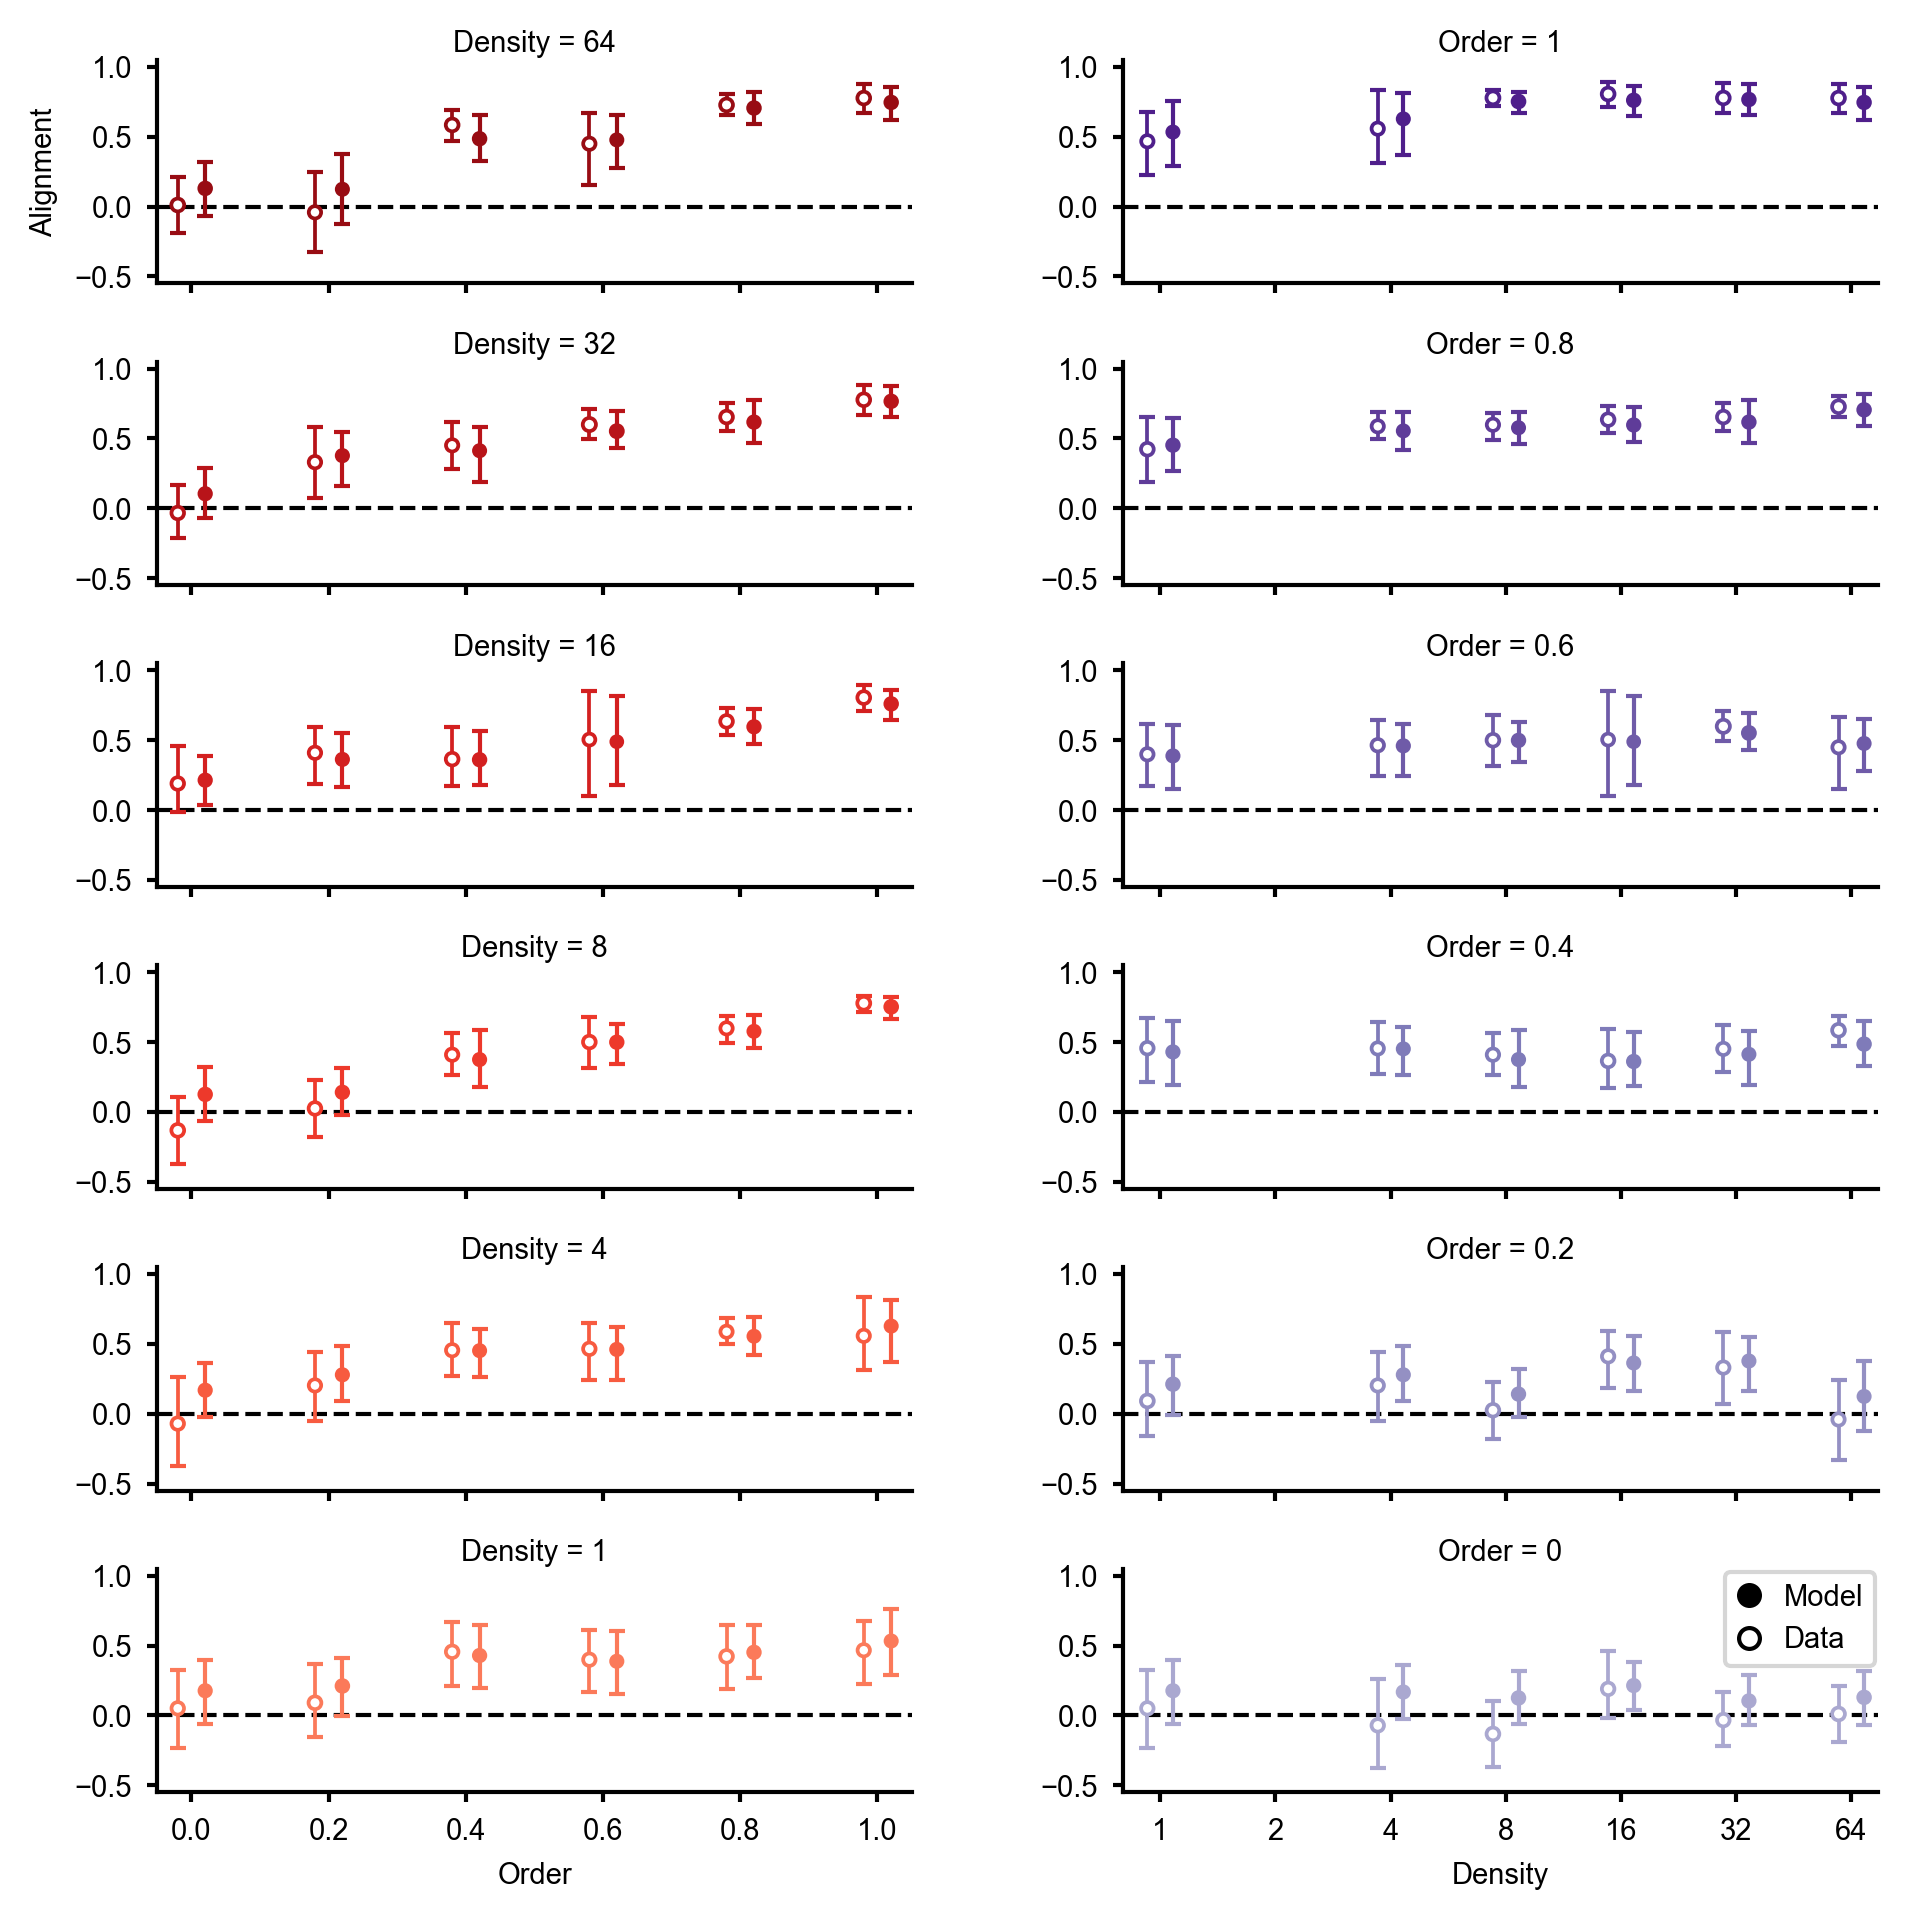

In [182]:
# ============================================================
# SMALL-MULTIPLES (DOTS + ERRORBARS, MODEL vs DATA at observed cells)
#   - Data: hierarchical bootstrap per observed (density, order) cell
#   - Model: posterior predictive sampled from individual-level likelihoods
#            + same hierarchical bootstrap procedure (animals + steps)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from math import pi

from joblib import Parallel, delayed
from tqdm.auto import tqdm
import contextlib
import joblib

from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase


# ----------------------------
# transforms used in the model
# ----------------------------
def normalize(x):
    return np.asarray(x, dtype=float) * 2.0 - 1.0

def log2_scale(x, min_size=1.0, max_size=64.0):
    x = np.asarray(x, dtype=float)
    return np.log2(x / min_size) / np.log2(max_size / min_size)

DENS_MIN, DENS_MAX = 1.0, 64.0

def softplus(x):
    x = np.asarray(x)
    return np.where(x > 20, x, np.log1p(np.exp(x)))

def circular_modulo(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def alignment_stat(y):
    y = np.asarray(y, dtype=float)
    return float(np.real(np.exp(1j * y).mean()))


# -----------------------------
# Bambi-style centering
# -----------------------------
def _compute_training_means(merged_df):
    t_order = normalize(merged_df["order"].astype(float).to_numpy())
    t_density = normalize(log2_scale(merged_df["density"].astype(float).to_numpy(), DENS_MIN, DENS_MAX))
    return {"t_order": float(np.mean(t_order)), "t_density": float(np.mean(t_density))}

TRAIN_MEANS = _compute_training_means(merged_df)


# ============================================================
# joblib <-> tqdm glue
# ============================================================
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()


# ============================================================
# Empirical hierarchical bootstrap per treatment cell (parallel)
# ============================================================
def hierarchical_bootstrap_cells_parallel(
    df_steps,
    B=1000,
    ci=0.95,              # interpreted as HDI probability mass
    seed=123,
    n_jobs=-1,
    prefer="threads",
    verbose=0,
):
    rng_master = np.random.default_rng(seed)

    records = []
    for aid, g in df_steps.groupby("animal_id", observed=True):
        dens = float(g["density"].iloc[0])
        ordv = float(g["order"].iloc[0])
        u = np.exp(1j * g["y"].to_numpy())
        records.append({"animal_id": str(aid), "density": dens, "order": ordv, "u": u})
    animal_tbl = pd.DataFrame(records)

    cell_groups = {}
    for (dens, ordv), sub in animal_tbl.groupby(["density", "order"], observed=True):
        cell_groups[(float(dens), float(ordv))] = sub["animal_id"].to_numpy()

    u_by_animal = dict(zip(animal_tbl["animal_id"], animal_tbl["u"]))

    def _hdi_1d(x, prob):
        h = az.hdi(x, hdi_prob=prob, skipna=True)
        h = np.asarray(h)
        if h.ndim == 2:
            return float(h[0, 0]), float(h[0, 1])
        return float(h[0]), float(h[1])

    def _bootstrap_one_cell(cell_key, animals, cell_seed):
        rng = np.random.default_rng(cell_seed)
        animals = np.asarray(animals)
        nA = len(animals)
        boots = np.empty(B, dtype=float)

        for b in range(B):
            samp_animals = animals[rng.integers(0, nA, size=nA)]
            z_sum = 0.0 + 0.0j

            for aid in samp_animals:
                u = u_by_animal[aid]
                idx = rng.integers(0, len(u), size=len(u))
                z_sum += u[idx].mean()

            boots[b] = np.real(z_sum / nA)

        low, high = _hdi_1d(boots, ci)

        return {
            "density": cell_key[0],
            "order": cell_key[1],
            "n_animals": int(nA),
            "emp_mean": float(boots.mean()),
            "emp_low":  float(low),
            "emp_high": float(high),
        }

    cells = list(cell_groups.items())
    cell_seeds = rng_master.integers(0, 2**32 - 1, size=len(cells), dtype=np.uint32)

    with tqdm_joblib(tqdm(total=len(cells), desc="Hierarchical bootstrap (data cells)")):
        out = Parallel(n_jobs=n_jobs, prefer=prefer, verbose=verbose)(
            delayed(_bootstrap_one_cell)(cell_key, animals, int(cell_seeds[i]))
            for i, (cell_key, animals) in enumerate(cells)
        )

    return pd.DataFrame(out)


# ============================================================
# Model: individual-level likelihood sampling + same hierarchical bootstrap
# ============================================================
def ppc_hierarchical_bootstrap_cells_parallel(
    df_steps,
    merged_df,
    idata,
    B=600,
    ci=0.95,
    seed=2025,
    n_jobs=-1,
    prefer="threads",
    verbose=0,
    bootstrap_steps=True,
):
    rng_master = np.random.default_rng(seed)
    post = idata.posterior

    animal_dim = None
    for d in post.dims:
        if "animal_id" in d:
            animal_dim = d
            break
    if animal_dim is None:
        raise KeyError(f"Could not find an animal dimension containing 'animal_id'. Found dims: {list(post.dims)}")

    def stack_samples_1d(name, default_zero=False):
        if name not in post.data_vars:
            if default_zero:
                S = int(post.sizes["chain"] * post.sizes["draw"])
                return np.zeros(S, dtype=float)
            raise KeyError(f"Missing posterior variable: {name}")
        return post[name].stack(sample=("chain", "draw")).values.astype(float)

    def stack_samples_re(name):
        if name not in post.data_vars:
            raise KeyError(f"Missing posterior random effect: {name}")
        da = post[name].stack(sample=("chain", "draw")).transpose("sample", animal_dim)
        return da.values.astype(float)

    b0    = stack_samples_1d("Intercept")
    b_td  = stack_samples_1d("t_density", default_zero=True)
    b_to  = stack_samples_1d("t_order", default_zero=True)
    b_int = stack_samples_1d("t_density:t_order", default_zero=True)

    k0    = stack_samples_1d("kappa_Intercept")
    k_td  = stack_samples_1d("kappa_t_density", default_zero=True)
    k_to  = stack_samples_1d("kappa_t_order", default_zero=True)
    k_int = stack_samples_1d("kappa_t_density:t_order", default_zero=True)

    mu_re    = stack_samples_re("1|animal_id")
    kappa_re = stack_samples_re("kappa_1|animal_id")

    S_total = b0.shape[0]
    post_animal_ids = post.coords[animal_dim].values.astype(str)
    post_index = {aid: i for i, aid in enumerate(post_animal_ids)}

    df_local = df_steps.copy()
    df_local["animal_id"] = df_local["animal_id"].astype(str)

    animal_tbl = (
        df_local.groupby("animal_id", observed=True)
        .agg(density=("density", "first"),
             order=("order", "first"),
             n_steps=("y", "size"))
        .reset_index()
    )

    animal_tbl["t_order"]   = normalize(animal_tbl["order"].astype(float)) - TRAIN_MEANS["t_order"]
    animal_tbl["t_density"] = normalize(log2_scale(animal_tbl["density"].astype(float), DENS_MIN, DENS_MAX)) - TRAIN_MEANS["t_density"]
    animal_tbl["t_int"]     = animal_tbl["t_order"] * animal_tbl["t_density"]

    animal_tbl["post_idx"] = animal_tbl["animal_id"].map(post_index)
    if animal_tbl["post_idx"].isna().any():
        bad = animal_tbl.loc[animal_tbl["post_idx"].isna(), "animal_id"].tolist()[:10]
        raise ValueError(
            "Some df animal_id levels not found in posterior coords. "
            f"Examples: {bad}\nPosterior coord example: {post_animal_ids[:10].tolist()}"
        )
    animal_tbl["post_idx"] = animal_tbl["post_idx"].astype(int)

    dens_arr     = animal_tbl["density"].to_numpy(float)
    order_arr    = animal_tbl["order"].to_numpy(float)
    nsteps_arr   = animal_tbl["n_steps"].to_numpy(int)
    torder_arr   = animal_tbl["t_order"].to_numpy(float)
    tdens_arr    = animal_tbl["t_density"].to_numpy(float)
    tint_arr     = animal_tbl["t_int"].to_numpy(float)
    postidx_arr  = animal_tbl["post_idx"].to_numpy(int)

    cell_to_rows = {}
    for i in range(len(animal_tbl)):
        key = (float(dens_arr[i]), float(order_arr[i]))
        cell_to_rows.setdefault(key, []).append(i)

    def _hdi_1d(x, prob):
        h = az.hdi(x, hdi_prob=prob, skipna=True)
        h = np.asarray(h)
        if h.ndim == 2:
            return float(h[0, 0]), float(h[0, 1])
        return float(h[0]), float(h[1])

    def _one_cell(cell_key, row_idx_list, cell_seed):
        rng = np.random.default_rng(cell_seed)
        rows = np.asarray(row_idx_list, dtype=int)
        nA = len(rows)
        boots = np.empty(B, dtype=float)

        for b in range(B):
            samp_rows = rows[rng.integers(0, nA, size=nA)]
            s = int(rng.integers(0, S_total))

            z_sum = 0.0 + 0.0j
            for rr in samp_rows:
                j = int(postidx_arr[rr])
                n_steps = int(nsteps_arr[rr])

                eta_mu = (
                    b0[s]
                    + b_td[s]  * tdens_arr[rr]
                    + b_to[s]  * torder_arr[rr]
                    + b_int[s] * tint_arr[rr]
                    + mu_re[s, j]
                )
                eta_kappa = (
                    k0[s]
                    + k_td[s]  * tdens_arr[rr]
                    + k_to[s]  * torder_arr[rr]
                    + k_int[s] * tint_arr[rr]
                    + kappa_re[s, j]
                )

                mu = circular_modulo(eta_mu)
                kappa = softplus(eta_kappa)

                y_rep = rng.vonmises(mu, kappa, size=n_steps)
                u = np.exp(1j * y_rep)

                if bootstrap_steps:
                    idx = rng.integers(0, n_steps, size=n_steps)
                    z_sum += u[idx].mean()
                else:
                    z_sum += u.mean()

            boots[b] = float(np.real(z_sum / nA))

        low, high = _hdi_1d(boots, ci)
        return {
            "density": cell_key[0],
            "order": cell_key[1],
            "n_animals": int(nA),
            "model_mean": float(boots.mean()),
            "model_low":  float(low),
            "model_high": float(high),
        }

    cells = list(cell_to_rows.items())
    cell_seeds = rng_master.integers(0, 2**32 - 1, size=len(cells), dtype=np.uint32)

    with tqdm_joblib(tqdm(total=len(cells), desc="Hierarchical bootstrap (model cells)")):
        out = Parallel(n_jobs=n_jobs, prefer=prefer, verbose=verbose)(
            delayed(_one_cell)(cell_key, row_idx_list, int(cell_seeds[i]))
            for i, (cell_key, row_idx_list) in enumerate(cells)
        )

    return pd.DataFrame(out)


# ============================================================
# Compute bootstrap summaries (data + model)
# ============================================================
emp = hierarchical_bootstrap_cells_parallel(
    df,
    B=1000,
    ci=0.95,
    seed=123,
    n_jobs=-1,
    prefer="threads",
)

mod = ppc_hierarchical_bootstrap_cells_parallel(
    df,
    merged_df,
    idata_hierarchical,
    B=600,
    ci=0.95,
    seed=2025,
    n_jobs=-1,
    prefer="threads",
    bootstrap_steps=True,
)

# DESCENDING so subplot rows run largest -> smallest
dens_levels  = np.sort(merged_df["density"].unique())[::-1]
order_levels = np.sort(merged_df["order"].unique())[::-1]


# ============================================================
# SMALL MULTIPLES PLOT (DOTS + ERRORBARS)
# ============================================================
plt.rcParams.update({
    "font.size": 8,
    "ytick.major.width": 1,
    "xtick.major.width": 1,
    "axes.linewidth": 1,
    "font.family": "Arial"
})

n_rows = max(len(dens_levels), len(order_levels))
fig_h = max(2.2, 1.25 * n_rows)
fig = plt.figure(figsize=(7.4, fig_h), dpi=300)
gs = fig.add_gridspec(n_rows, 2, wspace=0.28, hspace=0.35, width_ratios=[1.0, 1.0])

# keep "high = darker" while ordering is descending
dens_cols = [plt.cm.Reds(v) for v in np.linspace(0.90, 0.45, len(dens_levels))]
ord_cols  = [plt.cm.Purples(v) for v in np.linspace(0.90, 0.45, len(order_levels))]

Y_LIM = (-0.55, 1.05)
Y_TICKS = [-0.5, 0.0, 0.5, 1.0]

DX_ORDER = 0.02
DENS_FAC = 1.08


# ---- Left column: each density slice (alignment vs Order) ----
for r in range(n_rows):
    ax = fig.add_subplot(gs[r, 0])

    if r >= len(dens_levels):
        ax.axis("off")
        continue

    d = float(dens_levels[r])
    col = dens_cols[r]

    subd = emp.loc[np.isclose(emp["density"], d)].sort_values("order")   # within-panel x: low->high
    subm = mod.loc[np.isclose(mod["density"], d)].sort_values("order")
    if subd.empty and subm.empty:
        ax.axis("off")
        continue

    sub = pd.merge(subd, subm, on=["density", "order"], how="outer",
                   suffixes=("", "_model")).sort_values("order")

    x = sub["order"].to_numpy(float)
    x_data  = x - DX_ORDER
    x_model = x + DX_ORDER

    nA = sub["n_animals"].to_numpy()
    if np.all(pd.isna(nA)):
        nA = sub["n_animals_model"].to_numpy()
    nA = np.where(pd.isna(nA), 1.0, nA).astype(float)
    ms = 2.6 + 0.12 * np.sqrt(nA)

    if "emp_mean" in sub.columns:
        m = sub["emp_mean"].to_numpy(float)
        lo = sub["emp_low"].to_numpy(float)
        hi = sub["emp_high"].to_numpy(float)
        ok = ~np.isnan(m) & ~np.isnan(lo) & ~np.isnan(hi)
        if np.any(ok):
            ax.errorbar(
                x_data[ok], m[ok],
                yerr=np.vstack([m[ok] - lo[ok], hi[ok] - m[ok]]),
                fmt="o", ms=0, lw=0.9, color=col, zorder=3, capsize=2
            )
            ax.scatter(
                x_data[ok], m[ok],
                s=(ms[ok] ** 2),
                facecolors="white", edgecolors=col,
                linewidths=0.9, zorder=4
            )

    if "model_mean" in sub.columns:
        m = sub["model_mean"].to_numpy(float)
        lo = sub["model_low"].to_numpy(float)
        hi = sub["model_high"].to_numpy(float)
        ok = ~np.isnan(m) & ~np.isnan(lo) & ~np.isnan(hi)
        if np.any(ok):
            ax.errorbar(
                x_model[ok], m[ok],
                yerr=np.vstack([m[ok] - lo[ok], hi[ok] - m[ok]]),
                fmt="o", ms=0, lw=1.0, color=col, zorder=5, capsize=2
            )
            ax.scatter(
                x_model[ok], m[ok],
                s=(ms[ok] ** 2) * 0.9,
                facecolors=col, edgecolors=col,
                linewidths=0.8, zorder=6
            )

    ax.set_title(f"Density = {d:g}", loc="center", pad=2)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(*Y_LIM)
    ax.set_yticks(Y_TICKS)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if r < n_rows - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Order")
        ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

    if r == 0:
        ax.set_ylabel("Alignment")
    else:
        ax.set_ylabel("")

    ax.axhline(0, linestyle="--", color="k", zorder=0)


# ---- Right column: each order slice (alignment vs Density) ----
for r in range(n_rows):
    ax = fig.add_subplot(gs[r, 1])

    if r >= len(order_levels):
        ax.axis("off")
        continue

    o = float(order_levels[r])
    col = ord_cols[r]

    subd = emp.loc[np.isclose(emp["order"], o)].sort_values("density")   # within-panel x: low->high
    subm = mod.loc[np.isclose(mod["order"], o)].sort_values("density")
    if subd.empty and subm.empty:
        ax.axis("off")
        continue

    sub = pd.merge(subd, subm, on=["density", "order"], how="outer",
                   suffixes=("", "_model")).sort_values("density")

    x = sub["density"].to_numpy(float)
    x_data  = x / DENS_FAC
    x_model = x * DENS_FAC

    nA = sub["n_animals"].to_numpy()
    if np.all(pd.isna(nA)):
        nA = sub["n_animals_model"].to_numpy()
    nA = np.where(pd.isna(nA), 1.0, nA).astype(float)
    ms = 2.6 + 0.12 * np.sqrt(nA)

    if "emp_mean" in sub.columns:
        m = sub["emp_mean"].to_numpy(float)
        lo = sub["emp_low"].to_numpy(float)
        hi = sub["emp_high"].to_numpy(float)
        ok = ~np.isnan(m) & ~np.isnan(lo) & ~np.isnan(hi)
        if np.any(ok):
            ax.errorbar(
                x_data[ok], m[ok],
                yerr=np.vstack([m[ok] - lo[ok], hi[ok] - m[ok]]),
                fmt="o", ms=0, lw=0.9, color=col, zorder=3, capsize=2
            )
            ax.scatter(
                x_data[ok], m[ok],
                s=(ms[ok] ** 2),
                facecolors="white", edgecolors=col,
                linewidths=0.9, zorder=4
            )

    if "model_mean" in sub.columns:
        m = sub["model_mean"].to_numpy(float)
        lo = sub["model_low"].to_numpy(float)
        hi = sub["model_high"].to_numpy(float)
        ok = ~np.isnan(m) & ~np.isnan(lo) & ~np.isnan(hi)
        if np.any(ok):
            ax.errorbar(
                x_model[ok], m[ok],
                yerr=np.vstack([m[ok] - lo[ok], hi[ok] - m[ok]]),
                fmt="o", ms=0, lw=1.0, color=col, zorder=5, capsize=2
            )
            ax.scatter(
                x_model[ok], m[ok],
                s=(ms[ok] ** 2) * 0.9,
                facecolors=col, edgecolors=col,
                linewidths=0.8, zorder=6
            )

    ax.set_title(f"Order = {o:g}", loc="center", pad=2)

    if r == 5:
        data_proxy = Line2D([0], [0], marker="o", linestyle="none",
                            markerfacecolor="white", markeredgecolor="black",
                            markeredgewidth=1.0, color="black", markersize=5)
        model_proxy = Line2D([0], [0], marker="o", linestyle="none",
                             markerfacecolor="black", markeredgecolor="black",
                             color="black", markersize=5)
        ax.legend([model_proxy, data_proxy], ["Model", "Data"],
                  loc="upper right", frameon=True, borderaxespad=0.1,
                  handlelength=0.8, fontsize=7)

    ax.set_xscale("log", base=2)
    ax.set_xlim(0.8, 75)
    ax.set_ylim(*Y_LIM)
    ax.set_yticks(Y_TICKS)
    ax.set_xticks([1, 2, 4, 8, 16, 32, 64])
    ax.set_xticklabels([1, 2, 4, 8, 16, 32, 64])

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if r < n_rows - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Density")

    ax.set_ylabel("")
    ax.axhline(0, linestyle="--", color="k", zorder=0)


fig.tight_layout()

OUT_PDF = "../figures/order_density_cell_ppc_dots.pdf"
fig.savefig(OUT_PDF, dpi=300, bbox_inches="tight", pad_inches=0.01)

OUT_PNG = "../figures/order_density_cell_ppc_dots.png"
fig.savefig(OUT_PNG, dpi=300, bbox_inches="tight", pad_inches=0.01)

plt.show()


[OK] posterior draws S=4000, animals=440
[OK] mu_re shape=(4000, 440) kappa_re shape=(4000, 440)


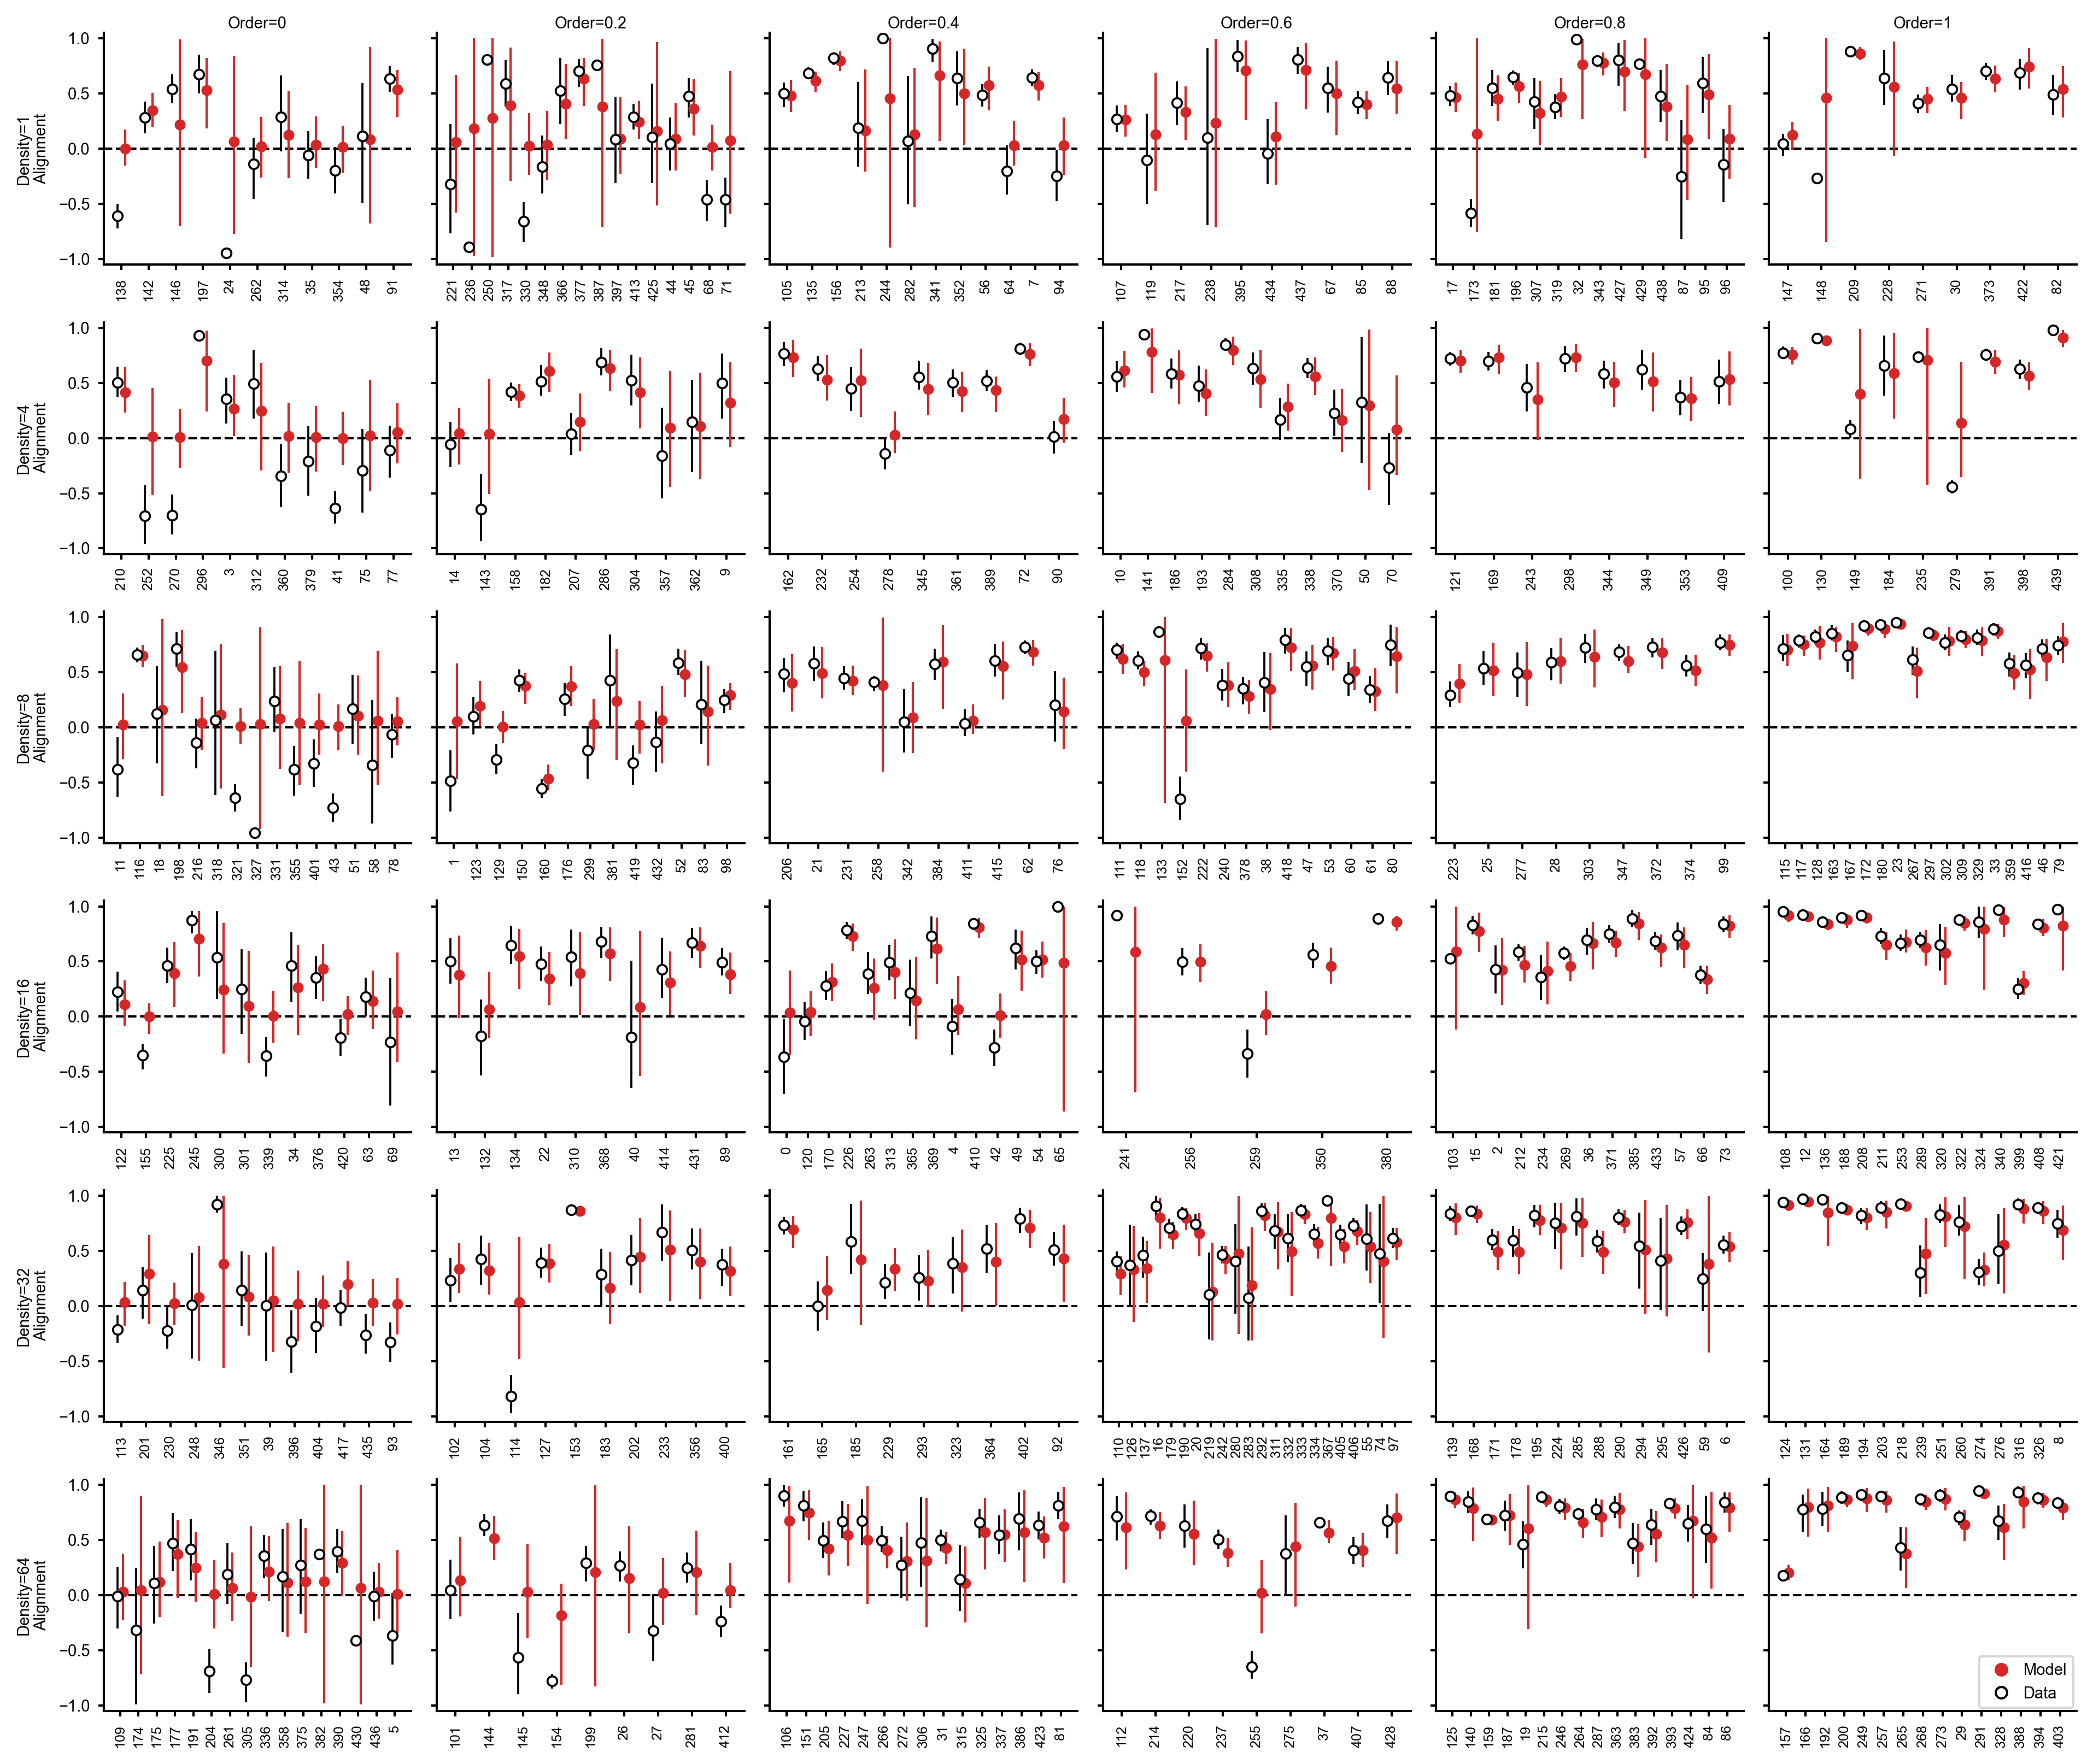

In [132]:
# ============================================================
# INDIVIDUAL-LEVEL PPC BY TREATMENT CELL (density × order)
# FULL UPDATED CODE (with correct RE stacking order)
#
# Each subplot = one (density, order) combination.
# x-axis = individual (animal) within that cell
# y-axis = alignment statistic: Re(mean(exp(i*y)))
#
# For each individual:
#   - Data: within-individual bootstrap CI (resample steps within that animal)
#   - Model: posterior predictive CI (simulate same N steps using that animal's RE + fixed)
#
# Requires in memory:
#   merged_df : original df with columns density, order
#   df        : step-level df used for fitting, columns: animal_id, y, density, order
#   idata_hierarchical : fitted InferenceData from bambi
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

# ============================================================
# SETTINGS
# ============================================================
DENS_MIN, DENS_MAX = 1.0, 64.0
HDP = 0.95

B_BOOT = 800          # within-animal bootstrap reps (data)
BOOT_SEED = 123

S_PPC = 400           # posterior draws per animal for PPC reps (model)
PPC_SEED = 2025       # base seed for PPC

ANIMAL_DIM = "animal_id__factor_dim"  # from your idata.posterior dims

# ============================================================
# TRANSFORMS (match your model)
# ============================================================
def normalize(x):
    return np.asarray(x, dtype=float) * 2.0 - 1.0

def log2_scale(x, min_size=1., max_size=64.):
    x = np.asarray(x, dtype=float)
    return np.log2(x / min_size) / np.log2(max_size / min_size)

def softplus(x):
    x = np.asarray(x)
    return np.where(x > 20, x, np.log1p(np.exp(x)))

def circular_modulo(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def alignment_stat(y):
    y = np.asarray(y, dtype=float)
    return float(np.real(np.exp(1j * y).mean()))

# ============================================================
# TRAINING MEANS (center_predictors=True)
# ============================================================
def compute_training_means(merged_df):
    t_order = normalize(merged_df["order"].astype(float).to_numpy())
    t_density = normalize(log2_scale(merged_df["density"].astype(float).to_numpy(), DENS_MIN, DENS_MAX))
    return {"t_order": float(np.mean(t_order)), "t_density": float(np.mean(t_density))}

TRAIN_MEANS = compute_training_means(merged_df)

# ============================================================
# WITHIN-ANIMAL BOOTSTRAP (DATA)
# ============================================================
def bootstrap_alignment(y, B=800, seed=123):
    rng = np.random.default_rng(seed)
    u = np.exp(1j * np.asarray(y, dtype=float))
    n = len(u)
    boots = np.empty(B, dtype=float)
    for b in range(B):
        idx = rng.integers(0, n, size=n)
        boots[b] = float(np.real(u[idx].mean()))
    return boots

# ============================================================
# POSTERIOR ACCESS (your parameter names)
# ============================================================
post = idata_hierarchical.posterior
if ANIMAL_DIM not in post.dims:
    raise KeyError(f"Expected dim '{ANIMAL_DIM}' not in posterior. Found dims: {list(post.dims)}")

def stack_samples_1d(da):
    """For fixed effects: dims (chain, draw) -> (S,)"""
    return da.stack(sample=("chain", "draw")).values

def stack_samples_re(da, animal_dim):
    """
    For random effects: ensure output is (S, n_animals) no matter how dims are ordered.
    """
    da2 = da.stack(sample=("chain", "draw")).transpose("sample", animal_dim)
    return da2.values

# fixed effects (mu)
b0    = stack_samples_1d(post["Intercept"])                 # (S,)
b_td  = stack_samples_1d(post["t_density"])                 # (S,)
b_to  = stack_samples_1d(post["t_order"])                   # (S,)
b_int = stack_samples_1d(post["t_density:t_order"])         # (S,)

# fixed effects (kappa pre-softplus)
k0    = stack_samples_1d(post["kappa_Intercept"])           # (S,)
k_td  = stack_samples_1d(post["kappa_t_density"])           # (S,)
k_to  = stack_samples_1d(post["kappa_t_order"])             # (S,)
k_int = stack_samples_1d(post["kappa_t_density:t_order"])   # (S,)

# random intercepts (already present; stack + transpose correctly!)
mu_re    = stack_samples_re(post["1|animal_id"], ANIMAL_DIM)         # (S, n_animals)
kappa_re = stack_samples_re(post["kappa_1|animal_id"], ANIMAL_DIM)   # (S, n_animals)

S_total = b0.shape[0]
n_animals_post = mu_re.shape[1]
print(f"[OK] posterior draws S={S_total}, animals={n_animals_post}")
print(f"[OK] mu_re shape={mu_re.shape} kappa_re shape={kappa_re.shape}")

# ============================================================
# BUILD 1-ROW-PER-ANIMAL TABLE (each animal has 1 treatment)
# ============================================================
df_local = df.copy()
df_local["animal_id"] = df_local["animal_id"].astype(str)

y_by_animal = {aid: g["y"].to_numpy() for aid, g in df_local.groupby("animal_id", observed=True)}

animal_tbl = (
    df_local.groupby("animal_id", observed=True)
    .agg(density=("density", "first"), order=("order", "first"), n_steps=("y", "size"))
    .reset_index()
)

# centered predictors used in model
animal_tbl["t_order"]   = normalize(animal_tbl["order"].astype(float)) - TRAIN_MEANS["t_order"]
animal_tbl["t_density"] = normalize(log2_scale(animal_tbl["density"].astype(float), DENS_MIN, DENS_MAX)) - TRAIN_MEANS["t_density"]
animal_tbl["t_int"]     = animal_tbl["t_order"] * animal_tbl["t_density"]

# map animal_id -> posterior index using coords on ANIMAL_DIM
post_animal_ids = post.coords[ANIMAL_DIM].values.astype(str)
post_index = {aid: i for i, aid in enumerate(post_animal_ids)}

animal_tbl["post_idx"] = animal_tbl["animal_id"].map(post_index)
if animal_tbl["post_idx"].isna().any():
    bad = animal_tbl.loc[animal_tbl["post_idx"].isna(), "animal_id"].tolist()[:10]
    raise ValueError(
        "Some df animal_id levels not found in posterior coords. "
        f"Examples: {bad}\nPosterior coord example: {post_animal_ids[:10].tolist()}"
    )
animal_tbl["post_idx"] = animal_tbl["post_idx"].astype(int)

# ============================================================
# COMPUTE DATA BOOTSTRAP + MODEL PPC (per animal)
# ============================================================
rng_master = np.random.default_rng(PPC_SEED)
out_rows = []

for row in animal_tbl.itertuples(index=False):
    aid = row.animal_id
    j = int(row.post_idx)
    n_steps = int(row.n_steps)
    y_obs = y_by_animal[aid]

    # ---- DATA bootstrap ----
    boots = bootstrap_alignment(y_obs, B=B_BOOT, seed=BOOT_SEED + j)
    data_mean = float(boots.mean())
    data_low, data_high = az.hdi(boots, hdi_prob=HDP, skipna=True)
    data_low, data_high = float(data_low), float(data_high)

    # ---- MODEL PPC ----
    draw_idx = rng_master.choice(S_total, size=min(S_PPC, S_total), replace=False)

    eta_mu = (
        b0[draw_idx]
        + b_td[draw_idx]  * float(row.t_density)
        + b_to[draw_idx]  * float(row.t_order)
        + b_int[draw_idx] * float(row.t_int)
        + mu_re[draw_idx, j]
    )

    eta_kappa = (
        k0[draw_idx]
        + k_td[draw_idx]  * float(row.t_density)
        + k_to[draw_idx]  * float(row.t_order)
        + k_int[draw_idx] * float(row.t_int)
        + kappa_re[draw_idx, j]
    )

    mu = circular_modulo(eta_mu)
    kappa = softplus(eta_kappa)

    rng = np.random.default_rng(PPC_SEED + 10_000 + j)
    reps = np.empty(len(draw_idx), dtype=float)
    for i in range(len(draw_idx)):
        y_rep = rng.vonmises(mu[i], kappa[i], size=n_steps)
        reps[i] = alignment_stat(y_rep)

    model_mean = float(reps.mean())
    model_low, model_high = az.hdi(reps, hdi_prob=HDP, skipna=True)

    out_rows.append({
        "animal_id": aid,
        "density": float(row.density),
        "order": float(row.order),
        "data_mean": data_mean,
        "data_low": float(data_low),
        "data_high": float(data_high),
        "model_mean": model_mean,
        "model_low": float(model_low),
        "model_high": float(model_high),
    })

ppc_df = pd.DataFrame(out_rows)

# ============================================================
# PLOT: grid of subplots by (density, order)
# ============================================================
plt.rcParams.update({
    "font.size": 8,
    "ytick.major.width": 1,
    "xtick.major.width": 1,
    "axes.linewidth": 1,
    "font.family": "Arial",
})

dens_levels = np.sort(ppc_df["density"].unique())
order_levels = np.sort(ppc_df["order"].unique())

nrows = len(dens_levels)
ncols = len(order_levels)

fig_w = max(6.8, 2.2 * ncols)
fig_h = max(3.2, 1.8 * nrows)
fig, axs = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), dpi=300, sharey=True)

axs = np.atleast_2d(axs).reshape(nrows, ncols)

Y_LIM = (-1.05, 1.05)
Y_TICKS = [-1.0, -0.5, 0.0, 0.5, 1.0]

for ri, d in enumerate(dens_levels):
    for ci, o in enumerate(order_levels):
        ax = axs[ri, ci]
        sub = ppc_df.loc[(np.isclose(ppc_df["density"], d)) & (np.isclose(ppc_df["order"], o))].copy()

        if sub.empty:
            ax.axis("off")
            continue

        sub = sub.sort_values("animal_id").reset_index(drop=True)
        x = np.arange(len(sub), dtype=float)
        x_data  = x - 0.14
        x_model = x + 0.14

        # Data: black intervals + open circles
        ax.vlines(x_data, sub["data_low"], sub["data_high"], colors="black", lw=0.9, zorder=2)
        ax.scatter(x_data, sub["data_mean"], s=18, facecolors="white", edgecolors="black",
                   linewidths=0.9, zorder=3)

        # Model: red intervals + filled circles
        ax.vlines(x_model, sub["model_low"], sub["model_high"], colors="tab:red", lw=1.0, zorder=1)
        ax.scatter(x_model, sub["model_mean"], s=16, facecolors="tab:red", edgecolors="tab:red",
                   linewidths=0.8, zorder=2)

        ax.set_ylim(*Y_LIM)
        ax.set_yticks(Y_TICKS)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        ax.set_xticks(x)
        ax.set_xticklabels(sub["animal_id"].tolist(), rotation=90, fontsize=6)

        if ri == 0:
            ax.set_title(f"Order={o:g}", pad=2)
        if ci == 0:
            ax.set_ylabel(f"Density={d:g}\nAlignment")
        else:
            ax.set_ylabel("")
        ax.axhline(0, linestyle="--", color="k", zorder=0)

# Legend once for whole fig
from matplotlib.lines import Line2D
data_proxy = Line2D([0], [0], marker="o", linestyle="none",
                    markerfacecolor="white", markeredgecolor="black",
                    markeredgewidth=1.0, color="black", markersize=5)
model_proxy = Line2D([0], [0], marker="o", linestyle="none",
                     markerfacecolor="tab:red", markeredgecolor="tab:red",
                     color="tab:red", markersize=5)

ax_last = axs[-1, -1]
ax_last.legend(
    [model_proxy, data_proxy],
    ["Model", "Data"],
    loc="lower right",
    frameon=True,
    borderaxespad=0.2,
    handletextpad=0.4,
)

# ---- Save figure (Supplement 3) ----
fig.tight_layout(rect=[0, 0, 0.97, 1])

OUT_PDF = "../figures/order_density_individual_cell_ppc.pdf"
fig.savefig(OUT_PDF, dpi=300, bbox_inches="tight", pad_inches=0.01)

OUT_PNG = "../figures/order_density_individual_cell_ppc.png"
fig.savefig(OUT_PNG, dpi=300, bbox_inches="tight", pad_inches=0.01)

plt.show()
